In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math as ma
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from astropy import units as u
import astropy 
from scipy.interpolate import interp1d

from scipy.io import readsav

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import lymanAbs as lyA

import gc
import glob
import re

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [3]:
gc.collect()

260

In [4]:
np.set_printoptions(linewidth=100)
labelsize=20

# Load SB99

In [5]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
sb99path = '/Users/earnric/Research/Research-Observability/Software-Models/STARBURST99/STARBURST99-runs'
file = "/padova02-op/padova02.spectrum1"
SB02  = np.loadtxt(sb99path+file,skiprows=6) #

In [6]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# sb99path = '/Users/earnric/Research/Research-Observability/Software-Models/STARBURST99/STARBURST99-runs'
# file = "/geneva02/geneva02.spectrum1"
# SB02g  = np.loadtxt(sb99path+file,skiprows=6) #

In [7]:
#
# STARBURST 99 SEDs are for 1e6 M_sun... Normalize to 1 M_sun
#
sbage100      = (SB02[:,0] > 99.9e6) & (SB02[:,0] < 100.1e6)
SB02_100Myr = SB02[sbage100]
SB02_100Myr[:,2] = 10**(SB02_100Myr[:,2] - 6.0) # Normalize to 1 M_sun
SB02_100Myr[:,3] = 10**(SB02_100Myr[:,3] - 6.0) # Normalize to 1 M_sun
print(len(SB02_100Myr))
rsSB02_100MyrWaveLn, rsSB02_100MyrLperA = lyA.rsSEDwavelen(SB02_100Myr[:,1],SB02_100Myr[:,2],2)

# sbage100g      = (SB02g[:,0] > 99.9e6) & (SB02g[:,0] < 100.1e6)
# SB02g_100Myr = SB02g[sbage100]
# SB02g_100Myr[:,2] = 10**(SB02g_100Myr[:,2] - 6.0) # Normalize to 1 M_sun
# SB02g_100Myr[:,3] = 10**(SB02g_100Myr[:,3] - 6.0) # Normalize to 1 M_sun
# print(len(SB02g_100Myr))

1221


# Load BC03

In [8]:
# SETHs data with star formation
bc03path = '/Users/earnric/Research/Research-Observability/Software-Models/for_rick-sethRoot'
file = "/bc2003_lr_m62_salp_ssp_tau0_0100_dust0_00.100myr"
BC03  = np.loadtxt(bc03path+file,skiprows=6)
print(BC03.shape)
# So col 0 is wavelen(A), and the other columns are flux at the "log ages" in bcAgeArray

# BC03 Padova 1994 SSP
bc03ssppath = '/Users/earnric/Research/Research-Observability/Software-Models/BC03/bc03/Padova1994/salpeter'
file = '/bc2003_lr_m62_salp_ssp.100myr'
BC03ssp  = np.loadtxt(bc03ssppath+file,skiprows=6)
print(BC03ssp.shape)
# So col 0 is wavelen(A), and the other columns are flux at the "log ages" in bcAgeArray

solarL = 3.826e33

(1221, 2)
(1221, 2)


In [9]:
# Extract columns and convert from solar luminosity to erg/s/A
BC03_100Myrseth = np.dstack((BC03[:,0], BC03[:,1] * solarL)).reshape(1221,2)

BC03_100ssp = np.dstack((BC03ssp[:,0], BC03ssp[:,1] * solarL)).reshape(1221,2)

rsBC03seth_100MyrWaveLn, rsBC03seth_100MyrLperA = lyA.rsSEDwavelen(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],2)
rsBC03ssp_100MyrWaveLn,  rsBC03ssp_100MyrLperA = lyA.rsSEDwavelen(BC03_100ssp[:,0],BC03_100ssp[:,1],2)


# Load Schaerer

In [10]:
# SCHAERER data
# Note that col 0 is wavelength (Ang) and col 2 is total flux (erg s^-1 A^-1)
# Load all the Schaerer SEDS
# Derive the age of the SED file from the extension: 31 = 1e4 yr, dt = 1e0.05
#
logBaseAge = 4
dt         = 0.05

sedPath = '/Users/earnric/Research/Research-Observability/Software-Models/Schaerer'

# Schaerer format: lambda [A]     F_la(stellar) F_la(total)  fluxes in  [erg s^-1 A^-1]
sedFilePattern = sedPath + '/hytrac_mar08_e020/e020_sal_100_001_is2.[0-9]*' # Z = 1e-7, log age spacing = 0.05 dex
sedFiles = glob.glob(sedFilePattern)
# Remove the non-SED files from the list
sedFiles=[a for a in sedFiles if not re.search('is2\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
pos = [aFile.find('.') for aFile in sedFiles] # Get the position of the final "."
sedFile02exts = [int(aFile[i+1:]) for i,aFile in zip(pos,sedFiles)] # Get a list of numbers pasts "." in each file
sedsZ02 = np.array([np.loadtxt(file,skiprows=16) for file in sedFiles])

#
# Convert the extension number (31,...) to 'log age' of the sed 
# For the is2 files, we can map the extension to log age via: 0.05 ext + 2.45 = log age
#
sedAgeZ02 = np.multiply(sedFile02exts, 0.05) + 2.45 # just keep 2 decimal places... 
# sort by age -- the following generates an ordered list of INDICES that indexes the arrays in age-order
Z02AgeSortIndx = sedAgeZ02.argsort()

Z = 0.02 # This is the metallicity of the file we're working with
#
# BUILD A SORTED (in time) ARRAY
# Prepend the age onto each sed array such that it has the form:
# [[[log age,  lambda, total L/A], [log age,  lambda2, total L/A],...],
#  [[log age2, lambda, total L/A], [log age2,  lambda2, total L/A], ...],
# ... ]
#
Zm02 = [np.insert(sed[:,[0,2]],[0],[[age] for ii in range(0,len(sed))], axis=1) 
       for age,sed in zip(sedAgeZ02[Z02AgeSortIndx], sedsZ02[Z02AgeSortIndx])]


In [11]:
# Map log age to an index in our array
def logAToI(a):
    return int(round((a-4.0)/0.05))

In [12]:
logAge = 8.0 # This is the ~ 10kyr SED
theSed = Zm02[logAToI(logAge)]
#
# Add units, convert to freq space... 
#
wavelnSch = theSed[:,1] * u.angstrom
LperASch  = theSed[:,2] * u.erg / u.second / u.angstrom

rsSch_100MyrWaveLn, rsSch_100MyrLperA = lyA.rsSEDwavelen(wavelnSch,LperASch,2)
rsSch_100MyrFreq, rsSch_100MyrLperHz = lyA.rsSEDwavelen((wavelnSch[::-1]).to(u.Hz, equivalencies=u.spectral()),
                                (LperASch * wavelnSch**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1],2)
print(rsSch_100MyrWaveLn,'\n', rsSch_100MyrLperA)
print(rsSch_100MyrFreq,'\n', rsSch_100MyrLperHz)

[  2.72700000e+02   2.80500000e+02   2.88300000e+02 ...,   3.60000000e+06   4.20000000e+06
   4.80000000e+06] Angstrom 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   4.76727337e-37   2.55831146e-37
   1.49185122e-37]
[  5.62110859e+12   6.42412410e+12   7.49481145e+12 ...,   9.35876560e+16   9.61900935e+16
   9.89414053e+16] Hz 
 [  1.27392769e-43   1.67258726e-43   2.28987537e-43 ...,   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


In [13]:
hubbleFilters = lf.loadHubbleFilters()
jhkFilters = lf.loadJHKFilters()

dict keys: 
F105W_WFC3
F125W_WFC3
F160W_WFC3
F435W_ACS
F275W_WFC3
F850LP_ACS
F336W_WFC3
F775W_ACS
F225W_WFC3
F606W_ACS
F098M_WFC3
dict keys: 
H
J
Ks


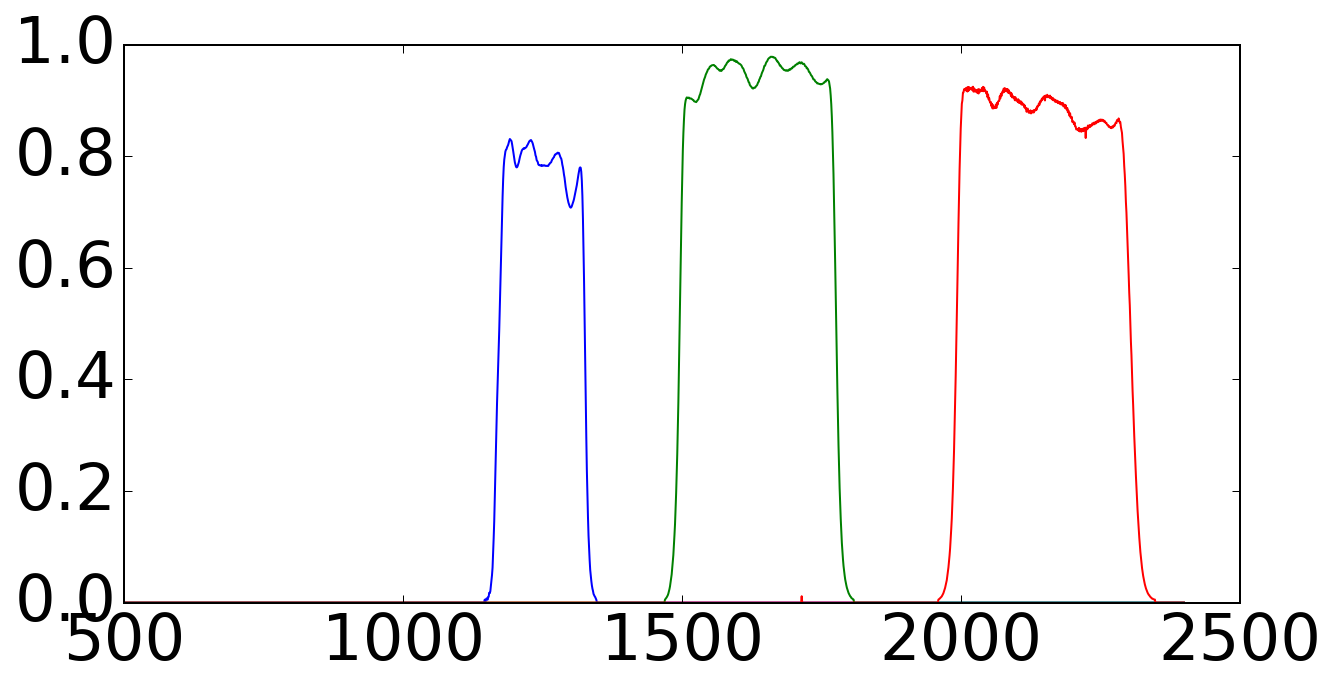

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.plot(np.arange(500,2400),jhkFilters['J'](np.arange(500,2400)),'b')
ax.plot(np.arange(500,2400),jhkFilters['H'](np.arange(500,2400)),'g')
ax.plot(np.arange(500,2400),jhkFilters['Ks'](np.arange(500,2400)),'r')

23296

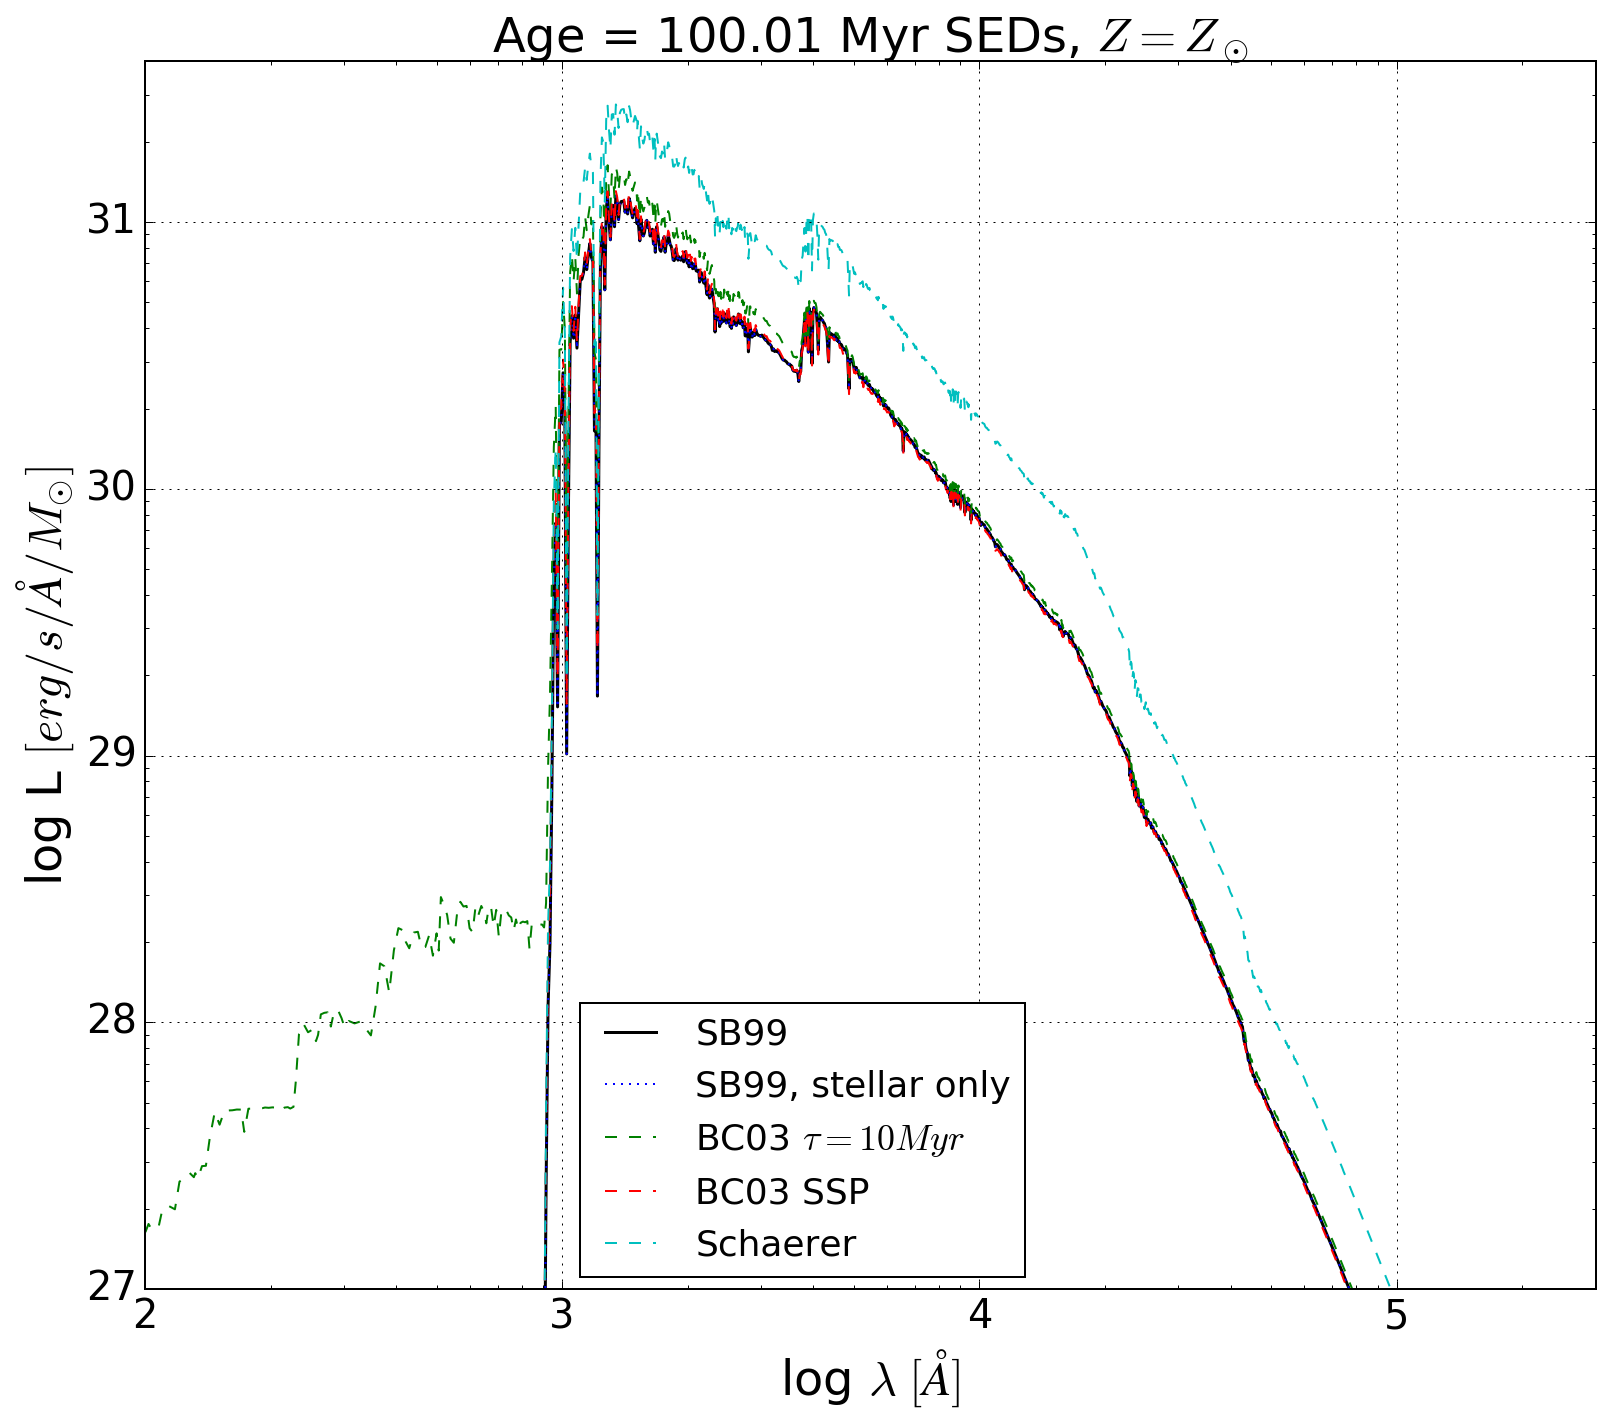

In [51]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(SB02_100Myr[:,1],SB02_100Myr[:,2],'k-',lw=1.5)
ax.plot(SB02_100Myr[:,1],SB02_100Myr[:,3],'b:')
# ax.plot(SB02g_100Myr[:,1],SB02g_100Myr[:,2],'r:')
ax.plot(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],'g--')
ax.plot(BC03_100ssp[:,0],BC03_100ssp[:,1],'r--')
ax.plot(wavelnSch,LperASch,'c--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([100,3e5])
ax.set_ylim([1e27,4e31])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99','SB99, stellar only',#'SB99, GENEVA',
           r'BC03 $\tau=10Myr$','BC03 SSP','Schaerer'],
              loc=(0.3,0.01), fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Age = %.2lf Myr SEDs, $Z = Z_\odot$'%(SB02[sbage100][0,0]/1e6), fontsize=24)
gc.collect()

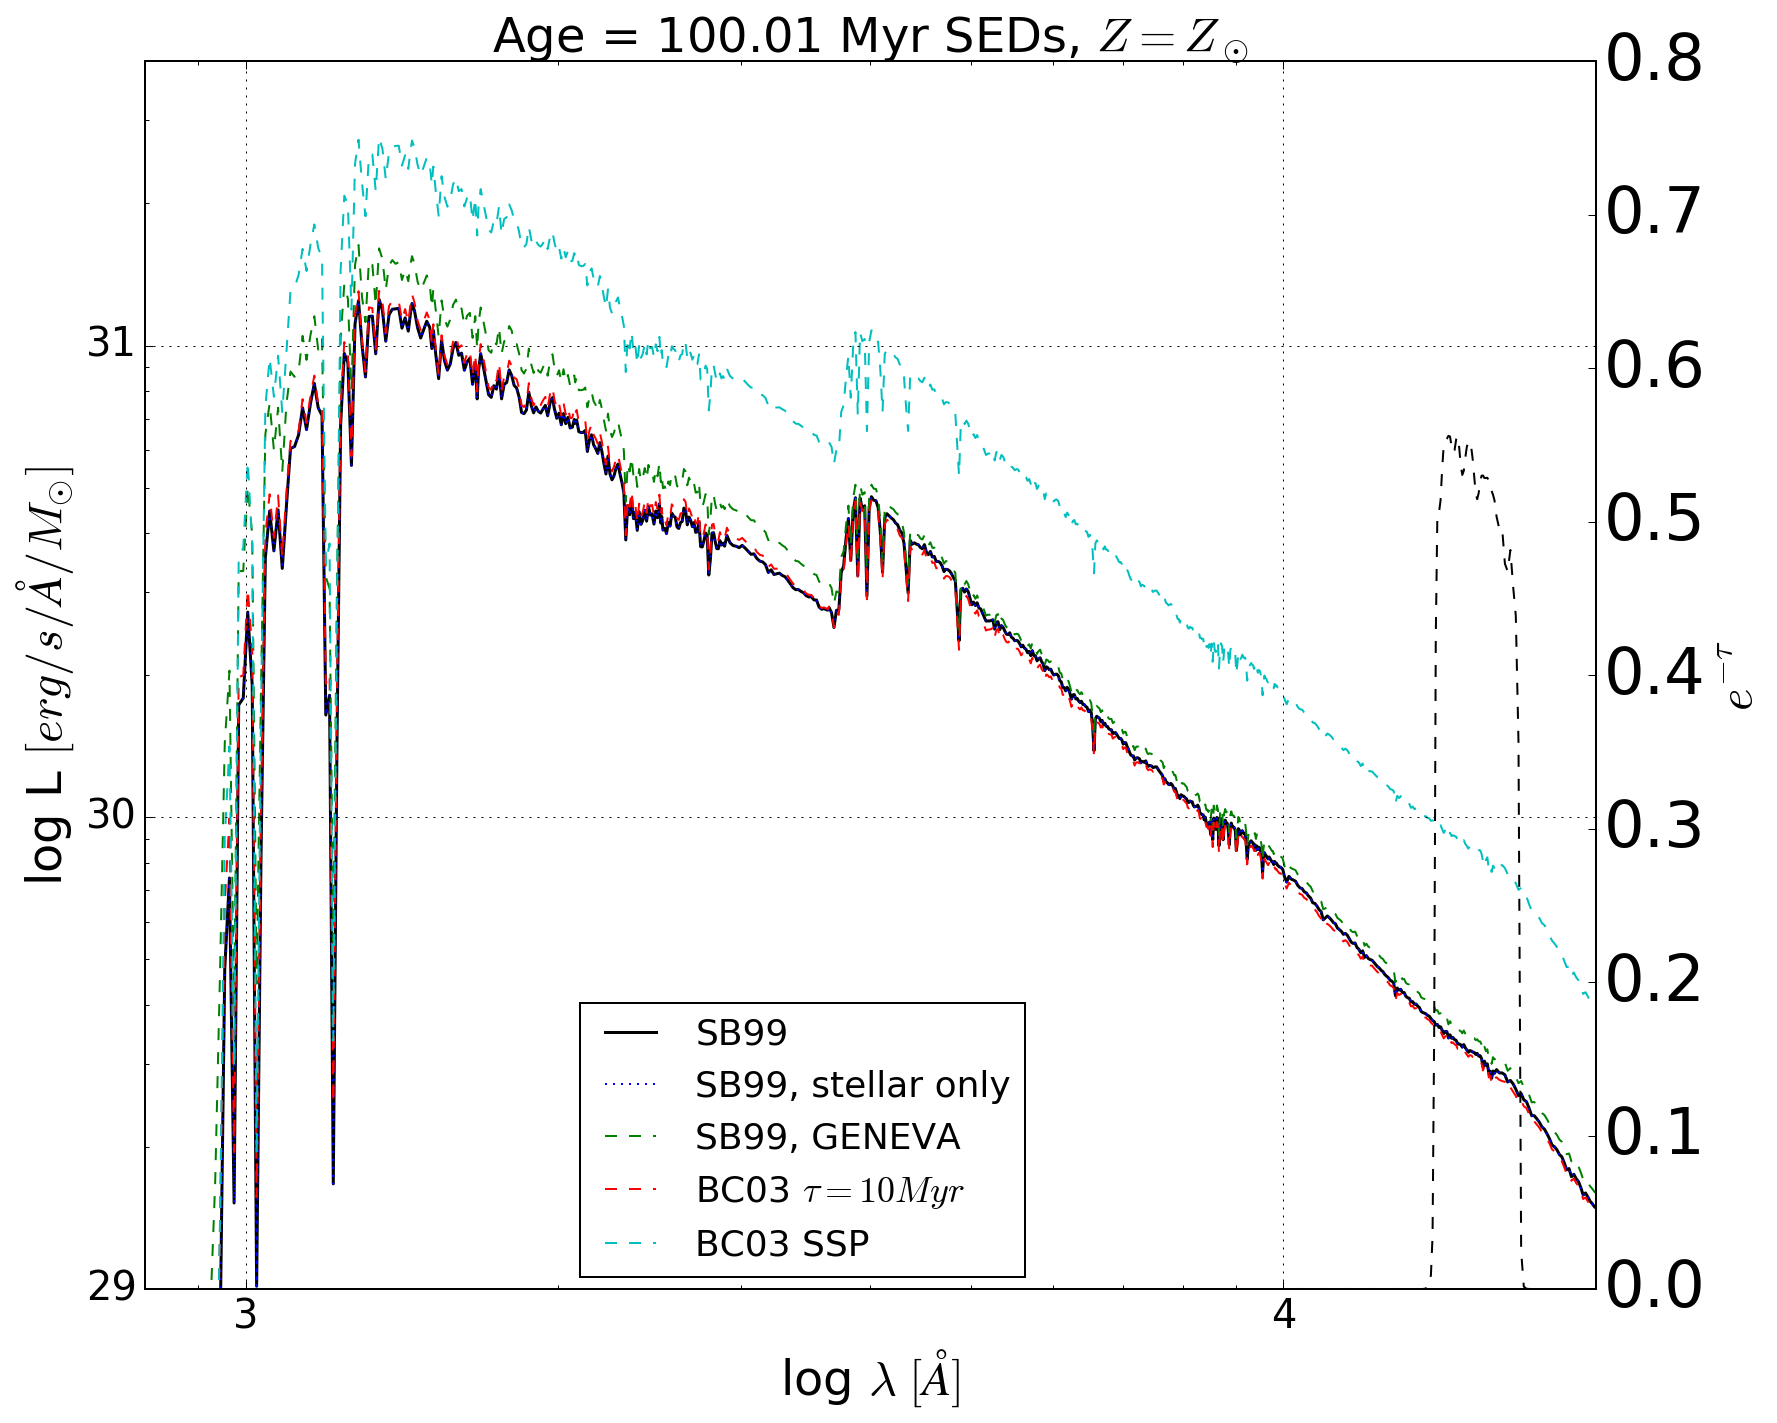

In [17]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(SB02_100Myr[:,1],SB02_100Myr[:,2],'k-',lw=1.5)
ax.plot(SB02_100Myr[:,1],SB02_100Myr[:,3],'b:')
# ax.plot(SB02g_100Myr[:,1],SB02g_100Myr[:,2],'r:')
ax.plot(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],'g--')
ax.plot(BC03_100ssp[:,0],BC03_100ssp[:,1],'r--')
ax.plot(wavelnSch,LperASch,'c--')

ax2 = ax.twinx()
ax2.set_ylim([0,0.8])
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_100ssp[:,0],hubbleFilters['F160W_WFC3'](BC03_100ssp[:,0]),'k--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([800,2e4])
ax.set_ylim([1e29,4e31])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99','SB99, stellar only','SB99, GENEVA',
           r'BC03 $\tau=10Myr$','BC03 SSP','Schaerer'],
              loc=(0.3,0.01), fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Age = %.2lf Myr SEDs, $Z = Z_\odot$'%(SB02[sbage100][0,0]/1e6), fontsize=24)


21070

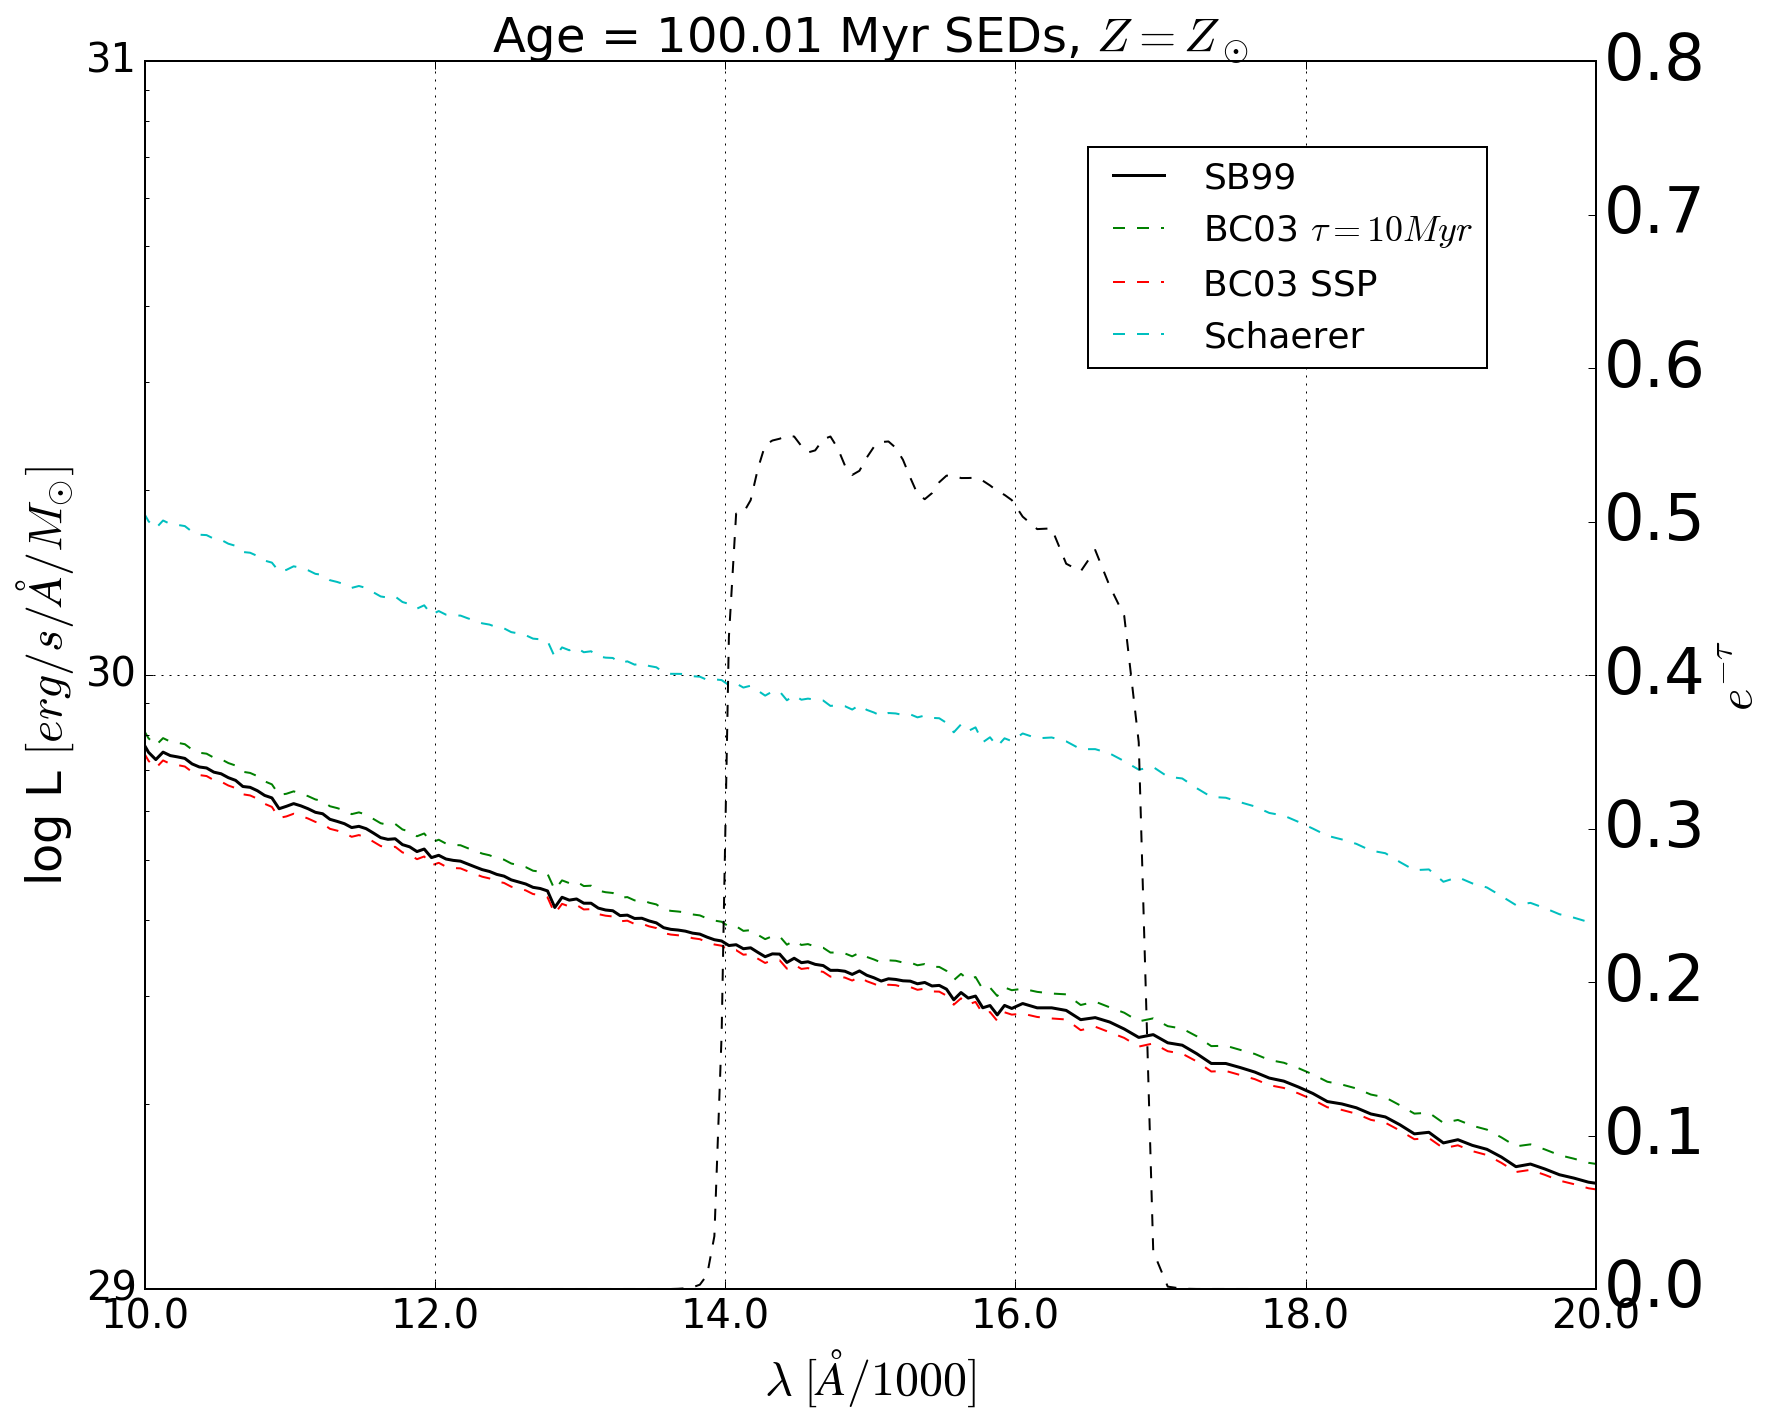

In [18]:
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.plot(SB02_100Myr[:,1],SB02_100Myr[:,2],'k-',lw=1.5)
ax.plot(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],'g--')
ax.plot(BC03_100ssp[:,0],BC03_100ssp[:,1],'r--')
ax.plot(wavelnSch,LperASch,'c--')

ax2 = ax.twinx()
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylim([0,0.8])
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_100ssp[:,0],hubbleFilters['F160W_WFC3'](BC03_100ssp[:,0]),'k--')

ax.set_xscale('linear')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e4,2e4])
ax.set_ylim([1e29,1e31])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99', r'BC03 $\tau=10Myr$','BC03 SSP','Schaerer'],
              loc=(0.65,0.75), fontsize=18 )

#fig.suptitle('Pop III SEDs', fontsize=24)
ax.set_title('Age = %.2lf Myr SEDs, $Z = Z_\odot$'%(SB02[sbage100][0,0]/1e6), fontsize=24)
gc.collect()

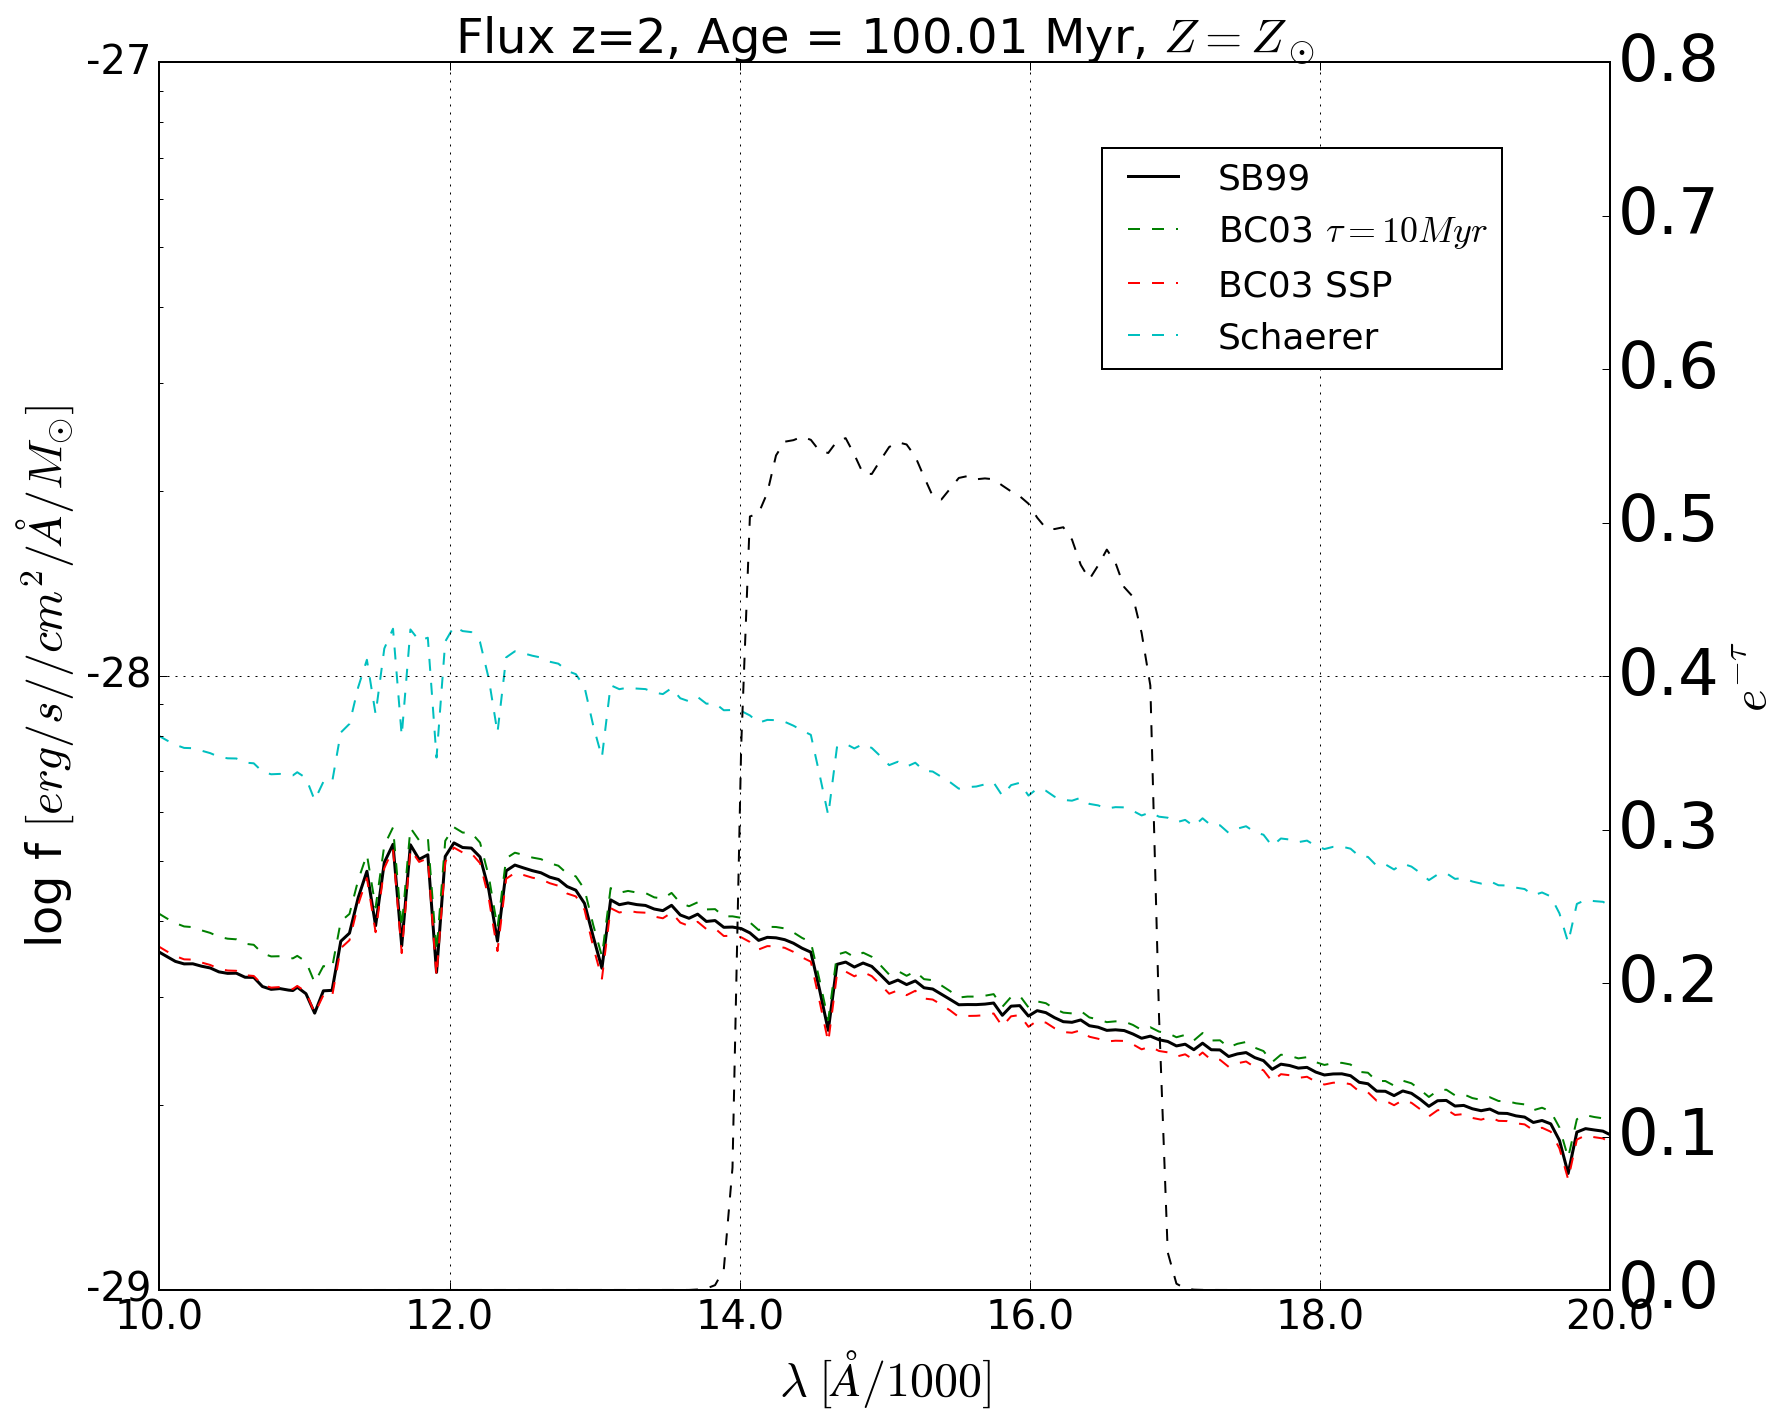

In [20]:
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsSB02_100MyrWaveLn, rsSB02_100MyrLperA,'k-',lw=1.5)
ax.plot(rsBC03seth_100MyrWaveLn, rsBC03seth_100MyrLperA,'g--')
ax.plot(rsBC03ssp_100MyrWaveLn, rsBC03ssp_100MyrLperA,'r--')
ax.plot(rsSch_100MyrWaveLn, rsSch_100MyrLperA,'c--')

ax2 = ax.twinx()
ax2.set_xlim([1e4,2e4])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F160W_WFC3'](rsBC03ssp_100MyrWaveLn),'k--')

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e4,2e4])
ax.set_ylim([1e-29,1e-27])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99',r'BC03 $\tau=10Myr$','BC03 SSP','Schaerer'],
              loc=(0.65,0.75), fontsize=18 )

ax.set_title('Flux z=2, Age = %.2lf Myr, $Z = Z_\odot$'%(SB02[sbage100][0,0]/1e6), fontsize=24)


# Seth flux, my flux - BC03

In [14]:
#
# Load Seth's data for z = 2
# PADOVA data 1994
#
sethPath = '/Users/earnric/Research/Research-Observability/Software-Models/sethData'
sethFile160z2 = sethPath + '/F160W_WFC3_bc_2.00' # IDL Save file
sethFile225z2 = sethPath + '/F225W_WFC3_bc_2.00' # IDL Save file
sethFile435z2 = sethPath + '/F435W_ACS_bc_2.00'  # IDL Save file
sethFile098z2 = sethPath + '/F098M_WFC3_bc_2.00' # IDL Save file
seth160z2Data = readsav(sethFile160z2)
seth225z2Data = readsav(sethFile225z2)
seth435z2Data = readsav(sethFile435z2)
seth098z2Data = readsav(sethFile098z2)
seth160z2Data.keys()

dict_keys(['tau', 'filtfluxz', 'wave', 'av', 'age'])

In [16]:
seth160z2Data['av'],seth160z2Data['tau']

(array([ 0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,  1.        ,  1.20000005,
         1.39999998,  1.60000002,  1.79999995,  2.        ,  2.20000005,  2.4000001 ,  2.5999999 ,
         2.79999995,  3.        ,  3.20000005,  3.4000001 ,  3.5999999 ,  3.79999995,  4.        ], dtype=float32),
 array([  9.99999978e-03,   1.93000007e-02,   3.73000018e-02,   7.19999969e-02,   1.38899997e-01,
          2.68299997e-01,   5.17899990e-01,   1.00000000e+02,   1.00000000e+01,   1.38950005e+01,
          1.00000000e+00,   1.93070006e+00,   2.68269997e+01,   3.72760010e+00,   5.17947006e+01,
          7.19689989e+00], dtype=float32))

In [15]:
#
# Load Seth's data for z = 6
# PADOVA data 1994
#
sethFile160z6 = sethPath + '/F160W_WFC3_bc_6.00' # IDL Save file
sethFile225z6 = sethPath + '/F225W_WFC3_bc_6.00' # IDL Save file
sethFile435z6 = sethPath + '/F435W_ACS_bc_6.00'  # IDL Save file
sethFile098z6 = sethPath + '/F098M_WFC3_bc_6.00' # IDL Save file
seth160z6Data = readsav(sethFile160z6)
seth225z6Data = readsav(sethFile225z6)
seth435z6Data = readsav(sethFile435z6)
seth098z6Data = readsav(sethFile098z6)
seth160z6Data.keys()

dict_keys(['tau', 'filtfluxz', 'wave', 'av', 'age'])

In [16]:
seth225z6Data['filtfluxz'][seth225z6Data['filtfluxz'] > 0]

array([], dtype=float64)

In [17]:
import importlib
importlib.reload(lyA)
importlib.reload(lf)

<module 'loadfilt' from '/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules/loadfilt.py'>

# Determine filter flux for my SB99 data

In [18]:
#
# Compute z = 2 hubble filter fluxes
# Do redshift and IGM absorption with the lyA.filterFluxC routine.
#
sbages = np.unique(SB02[:,0])
filterFluxsF160z2 = []
filterFluxsF225z2 = []
filterFluxsF435z2 = []
filterFluxsF098z2 = []
for age in sbages[::10]: # Just computer every 10th age... 
    sbAgeCond = (SB02[:,0] == age)
    SB02AtAge = SB02[sbAgeCond]
    SB02AtAge[:,2] = SB02AtAge[:,2] - 6.0 # Normalize to 1 M_sun
    SB02AtAge[:,3] = SB02AtAge[:,3] - 6.0 # Normalize to 1 M_sun
    # Redshift (2) and convolve with filter... 
    SB99_z2F160Fluxz2 = lyA.filterFluxC(hubbleFilters['F160W_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],2.0)
    SB99_z2F225Fluxz2 = lyA.filterFluxC(hubbleFilters['F225W_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],2.0)
    SB99_z2F435Fluxz2 = lyA.filterFluxC(hubbleFilters['F435W_ACS'],SB02AtAge[:,1],10**SB02AtAge[:,2],2.0)
    SB99_z2F098Fluxz2 = lyA.filterFluxC(hubbleFilters['F098M_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],2.0)
    filterFluxsF160z2 += [age, SB99_z2F160Fluxz2]
    filterFluxsF225z2 += [age, SB99_z2F225Fluxz2]
    filterFluxsF435z2 += [age, SB99_z2F435Fluxz2]
    filterFluxsF098z2 += [age, SB99_z2F098Fluxz2]

In [19]:
filterFluxsF160z2 = np.reshape(filterFluxsF160z2, (int(len(filterFluxsF160z2)/2), 2))
filterFluxsF225z2 = np.reshape(filterFluxsF225z2, (int(len(filterFluxsF225z2)/2), 2))
filterFluxsF435z2 = np.reshape(filterFluxsF435z2, (int(len(filterFluxsF435z2)/2), 2))
filterFluxsF098z2 = np.reshape(filterFluxsF098z2, (int(len(filterFluxsF098z2)/2), 2))

In [20]:
#
# Compute z = 6 hubble filter fluxes
# Do redshift and IGM absorption with the lyA.filterFluxC routine.
#
sbages = np.unique(SB02[:,0])
filterFluxsF160z6 = []
filterFluxsF225z6 = []
filterFluxsF435z6 = []
filterFluxsF098z6 = []
for age in sbages[::10]: # Just compute every 10th sed... 
    sbAgeCond = (SB02[:,0] == age)
    SB02AtAge = SB02[sbAgeCond]
    SB02AtAge[:,2] = SB02AtAge[:,2] - 6.0 # Normalize to 1 M_sun, total flux
    SB02AtAge[:,3] = SB02AtAge[:,3] - 6.0 # Normalize to 1 M_sun, stellar only
    # Redshift (6) and convolve with filter... 
    SB99_z6F160Fluxz6 = lyA.filterFluxC(hubbleFilters['F160W_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],6.0)
    SB99_z6F225Fluxz6 = lyA.filterFluxC(hubbleFilters['F225W_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],6.0)
    SB99_z6F435Fluxz6 = lyA.filterFluxC(hubbleFilters['F435W_ACS'],SB02AtAge[:,1],10**SB02AtAge[:,2],6.0)
    SB99_z6F098Fluxz6 = lyA.filterFluxC(hubbleFilters['F098M_WFC3'],SB02AtAge[:,1],10**SB02AtAge[:,2],6.0)
    filterFluxsF160z6 += [age, SB99_z6F160Fluxz6]
    filterFluxsF225z6 += [age, SB99_z6F225Fluxz6]
    filterFluxsF435z6 += [age, SB99_z6F435Fluxz6]
    filterFluxsF098z6 += [age, SB99_z6F098Fluxz6]

In [21]:
filterFluxsF160z6 = np.reshape(filterFluxsF160z6, (int(len(filterFluxsF160z6)/2), 2))
filterFluxsF225z6 = np.reshape(filterFluxsF225z6, (int(len(filterFluxsF225z6)/2), 2))
filterFluxsF435z6 = np.reshape(filterFluxsF435z6, (int(len(filterFluxsF435z6)/2), 2))
filterFluxsF098z6 = np.reshape(filterFluxsF098z6, (int(len(filterFluxsF098z6)/2), 2))

## Load the RAW SEDs for Seth's BC03 filer fluxes... remember: these have star formation

In [22]:
# SETHs data with star formation
bc03SethPath = '/Users/earnric/Research/Research-Observability/Software-Models/for_rick-sethRoot'
sethFiles = '/bc2003_lr_m62_salp_ssp_tau0_0100_dust0_00.*yr'
sethFilePattern = bc03SethPath + sethFiles 
sethFiles = glob.glob(sethFilePattern)

BC03_all  = [np.loadtxt(file,skiprows=6) for file in sethFiles]
print(len(BC03_all))

BC03_seth = [np.dstack((BC03[:,0], BC03[:,1]*solarL)).reshape(1221,2) for BC03 in BC03_all]
# Now we have an array of BC03 samples using Seths tau
BC03_seth = np.array(BC03_seth)

22


In [23]:
# Since we have star formation in the BC03 files, we need to adjust the flux by the mass at each
# age... The mass in stars in contained in the .color file... col 0 is log age, col 8 is mass (gal) in solar masses
color = '/bc2003_lr_m62_salp_ssp_tau0_0100_dust0_00.4color'
colorFile = np.loadtxt(bc03SethPath+color)
massNorm = colorFile[:,[0,8]] # Get log age and mass (galaxy) columns
massNormFunc = interp1d(10**massNorm[:,0],massNorm[:,1],kind='slinear',bounds_error=False,fill_value=0.0)

In [24]:
# Extract ages
BC03_seth_ages = [] # empty list of ages
for file in sethFiles: # Same list of files we load above... 
    with open(file) as fp:
        for i, line in enumerate(fp):
            if i == 3: # Line with the age in yr
                BC03_seth_ages += [float(line[10:])] # get the age line and convert to a float
BC03_ageSort = np.array(BC03_seth_ages).argsort()

BC03_seth_ages = np.array(BC03_seth_ages)

# Create a sorted list of ages... 
BC03_seth      = BC03_seth[BC03_ageSort]
BC03_seth_ages = BC03_seth_ages[BC03_ageSort]

# print(BC03_seth[BC03_ageSort])
print(BC03_seth_ages)

[  1.25900000e+05   5.01200000e+05   1.00000000e+06   1.99500000e+06   3.98100000e+06
   5.01200000e+06   7.94300000e+06   1.00000000e+07   1.31800000e+07   1.51400000e+07
   1.99500000e+07   2.51200000e+07   3.00000000e+07   4.75000000e+07   5.00000000e+07
   1.01500000e+08   1.01500000e+08   2.02600000e+08   5.08800000e+08   5.08800000e+08
   7.18700000e+08   7.18700000e+08]


In [25]:
# Create a list of ages and fluxes in the filter... 
# Do the redshift 2 and filter convolution
# CORRECT for the mass of stars at any given age... 
BC03_z2F160FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F160W_WFC3'],BC03seth[:,0],BC03seth[:,1],2.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z2F160FluxSeth = np.array(BC03_z2F160FluxSeth)

BC03_z2F225FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F225W_WFC3'],BC03seth[:,0],BC03seth[:,1],2.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z2F225FluxSeth = np.array(BC03_z2F225FluxSeth)

BC03_z2F098FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F098M_WFC3'],BC03seth[:,0],BC03seth[:,1],2.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z2F098FluxSeth = np.array(BC03_z2F098FluxSeth)

BC03_z2F435FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F435W_ACS'],BC03seth[:,0],BC03seth[:,1],2.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z2F435FluxSeth = np.array(BC03_z2F435FluxSeth)

In [26]:
# Create a list of ages and fluxes in the filter... 
# Do the redshift 6 and filter convolution
# CORRECT for the mass of stars at any given age... 
BC03_z6F160FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F160W_WFC3'],BC03seth[:,0],BC03seth[:,1],6.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z6F160FluxSeth = np.array(BC03_z6F160FluxSeth)

BC03_z6F225FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F225W_WFC3'],BC03seth[:,0],BC03seth[:,1],6.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z6F225FluxSeth = np.array(BC03_z6F225FluxSeth)

BC03_z6F098FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F098M_WFC3'],BC03seth[:,0],BC03seth[:,1],6.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z6F098FluxSeth = np.array(BC03_z6F098FluxSeth)

BC03_z6F435FluxSeth = [[age,lyA.filterFluxC(hubbleFilters['F435W_ACS'],BC03seth[:,0],BC03seth[:,1],6.0)/massNormFunc(age)] 
                           for age,BC03seth in zip(BC03_seth_ages,BC03_seth)]
BC03_z6F435FluxSeth = np.array(BC03_z6F435FluxSeth)

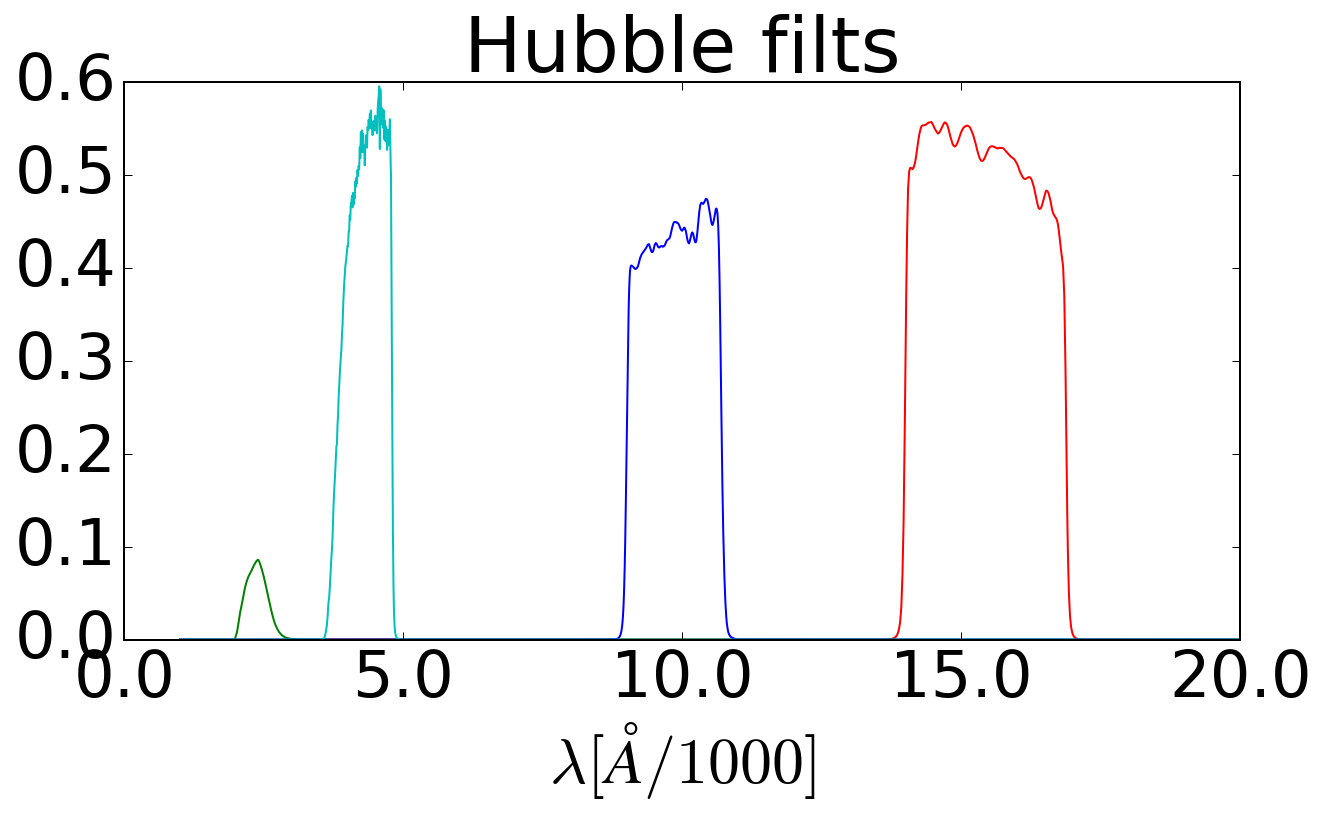

In [66]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
theRange = np.arange(1000,2e4)
ax.plot(theRange,hubbleFilters['F160W_WFC3'](theRange),'r-')
ax.plot(theRange,hubbleFilters['F225W_WFC3'](theRange),'g-')
ax.plot(theRange,hubbleFilters['F098M_WFC3'](theRange),'b-')
ax.plot(theRange,hubbleFilters['F435W_ACS'](theRange),'c-')
ax.xaxis.set_major_formatter(divfmt)
ax.set_xlabel(r'$\lambda [\AA/1000]$')
ax.set_title(r'Hubble filts')

444

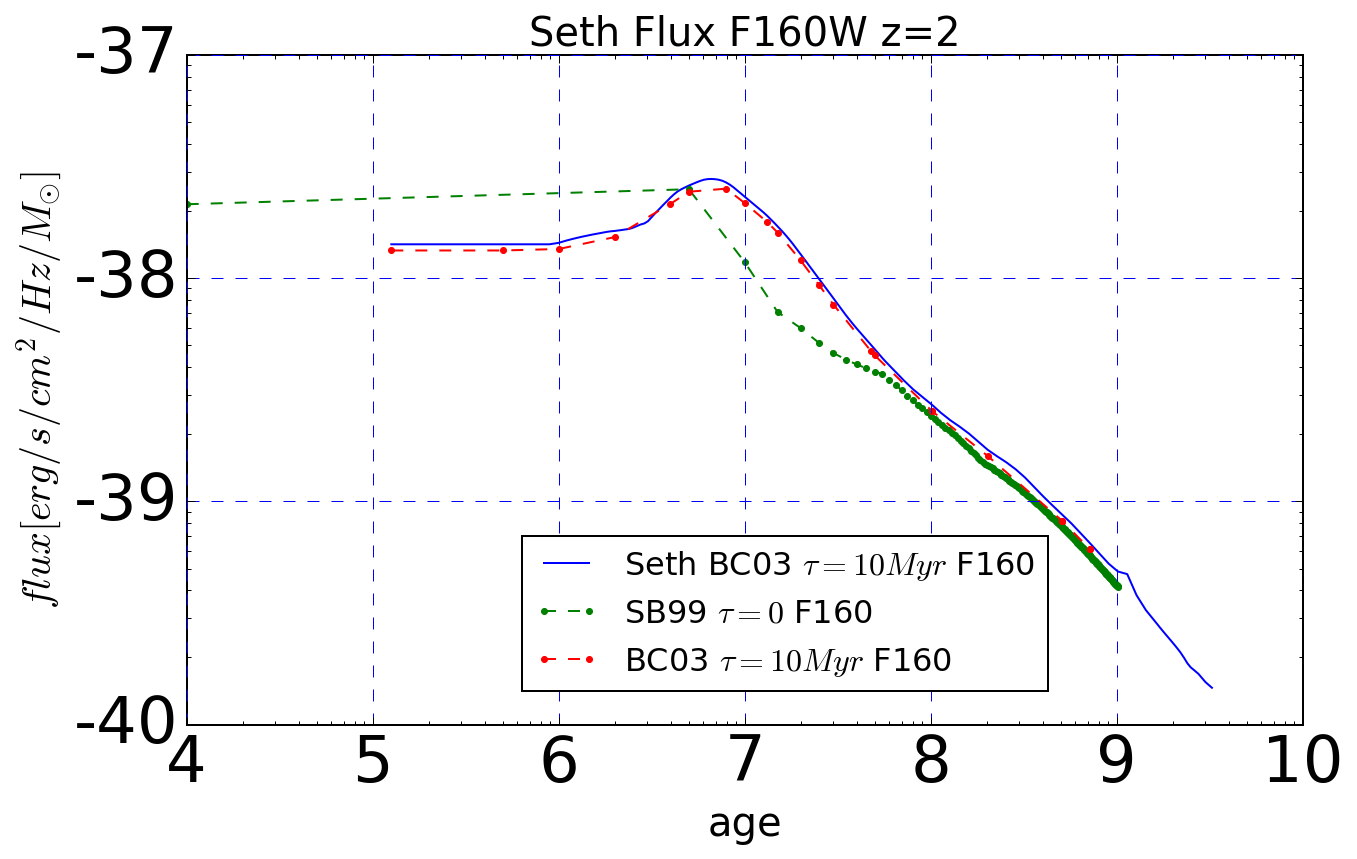

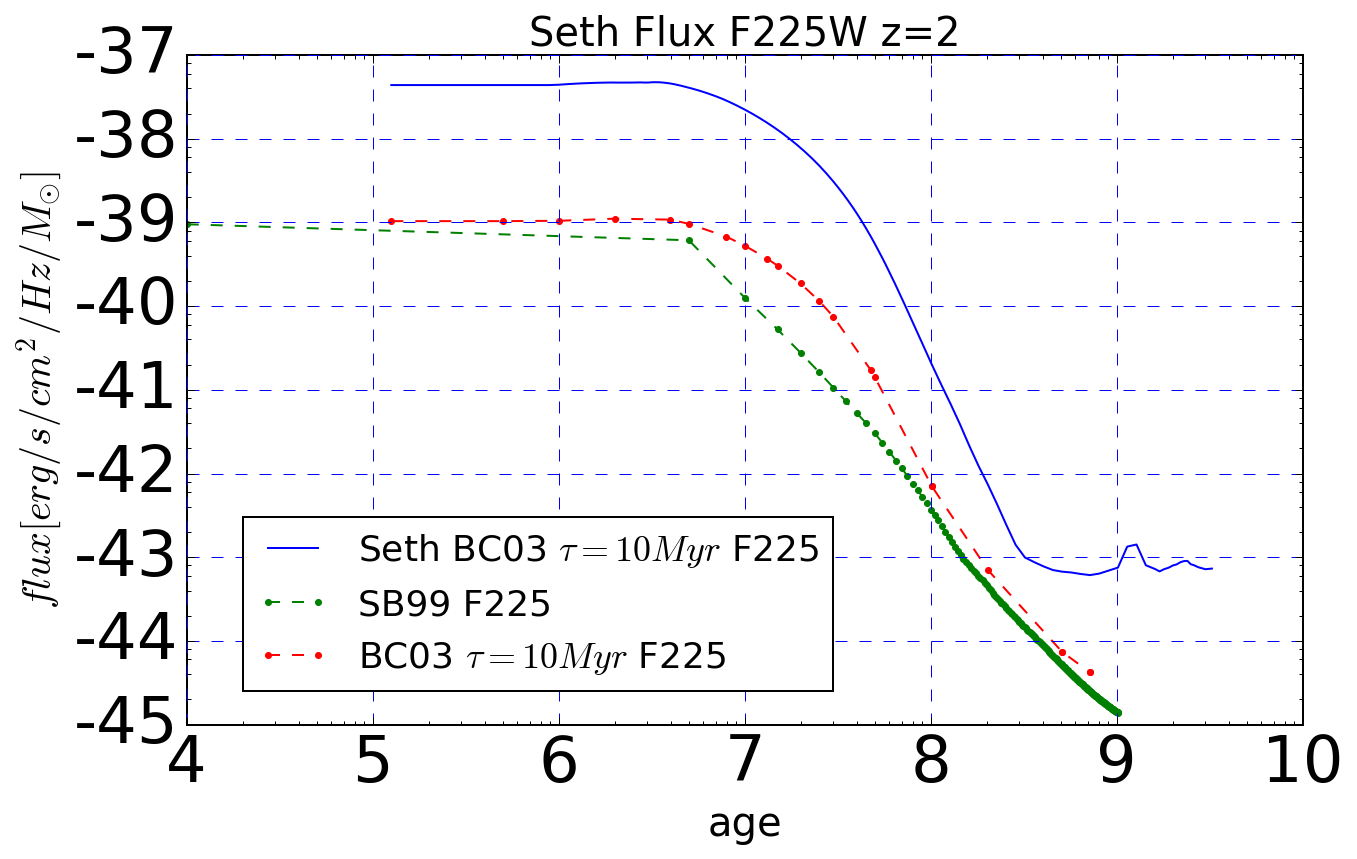

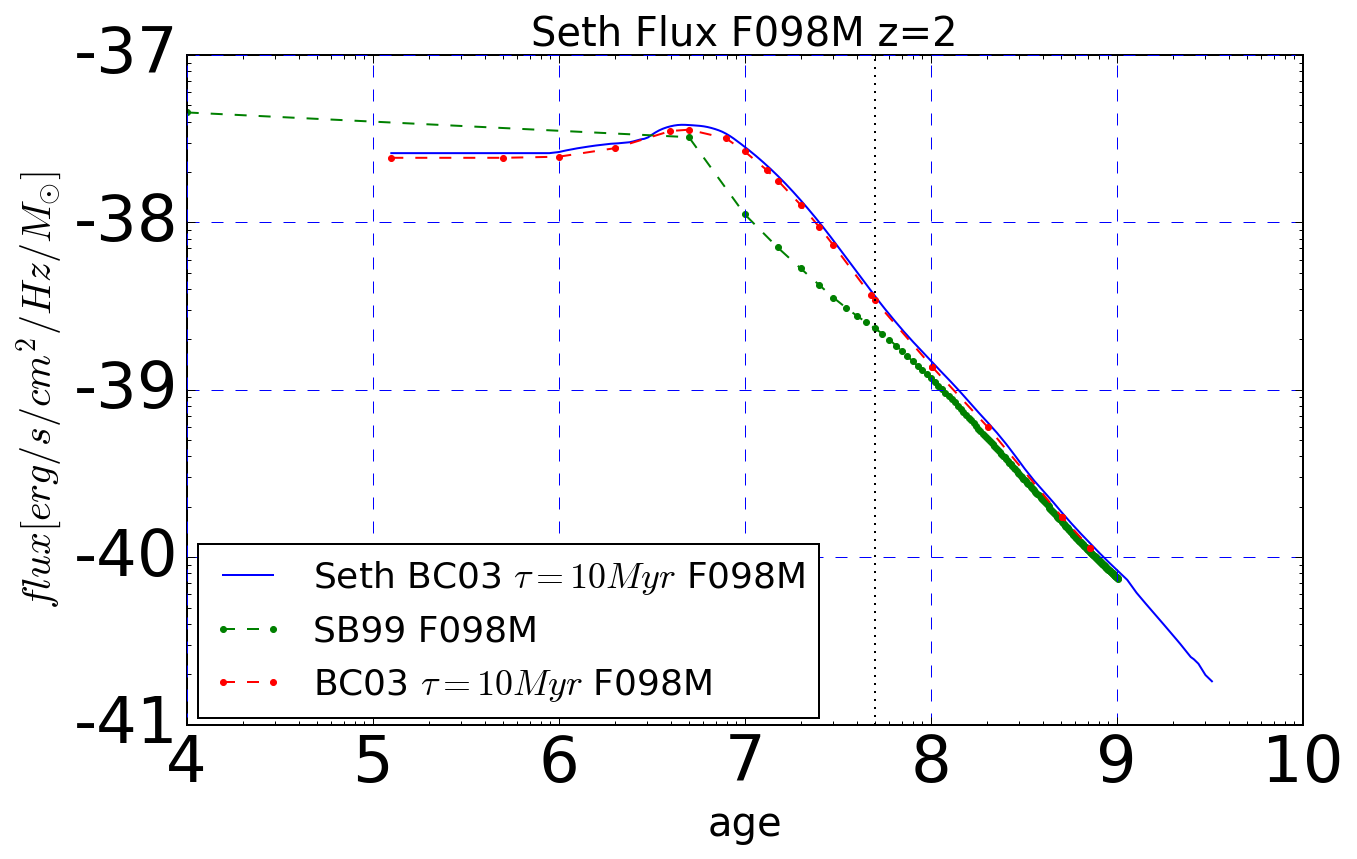

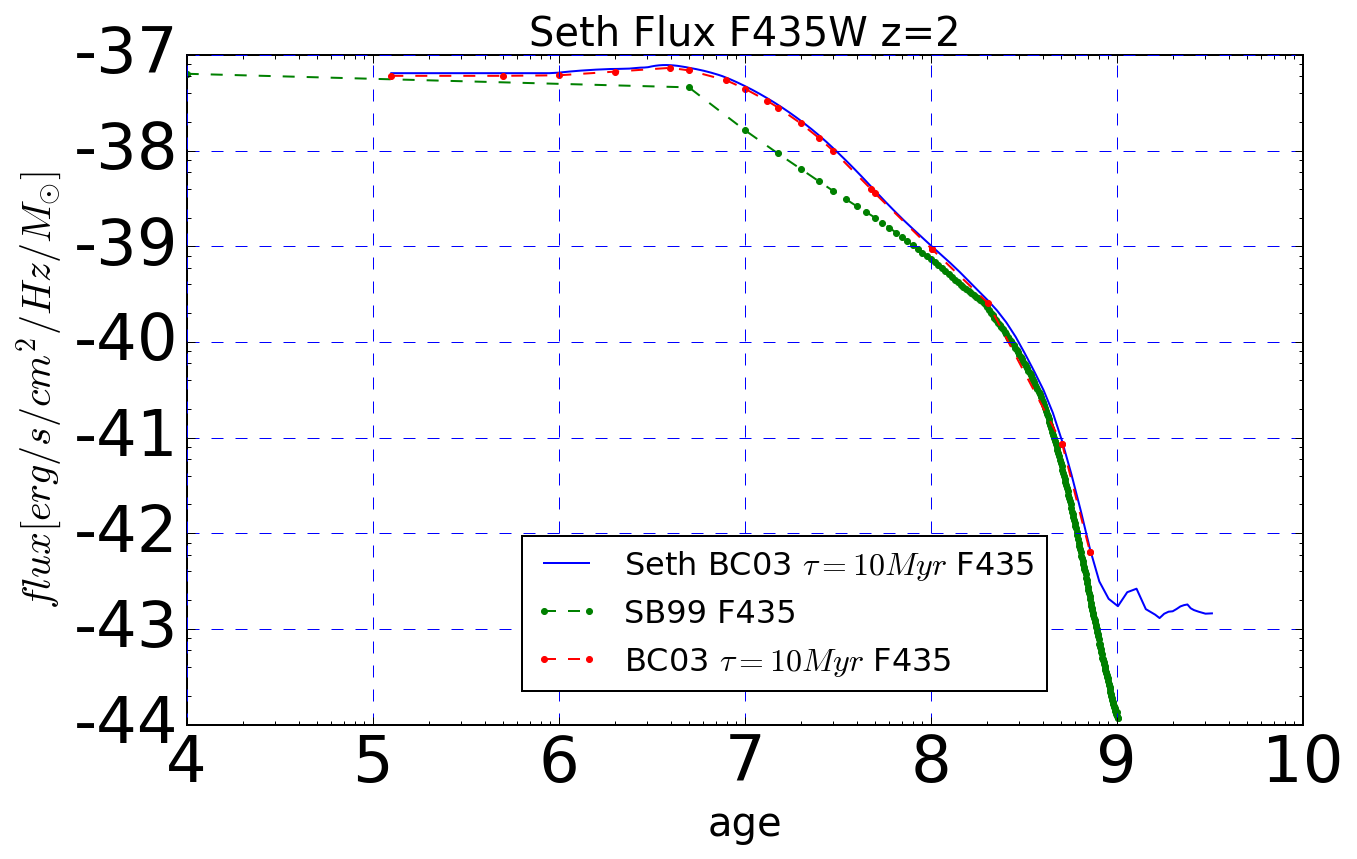

In [29]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth160z2Data['age'],seth160z2Data['filtfluxz'][0][0])
ax.plot(filterFluxsF160z2[:,0],filterFluxsF160z2[:,1],"g.--")
ax.plot(BC03_z2F160FluxSeth[:,0],BC03_z2F160FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F160W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F160',r'SB99 $\tau=0$ F160', r'BC03 $\tau=10Myr$ F160'],
              loc=(0.3,0.05), fontsize=16 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth225z2Data['age'],seth225z2Data['filtfluxz'][0][0])
ax.plot(filterFluxsF225z2[:,0],filterFluxsF225z2[:,1],"g.--")
ax.plot(BC03_z2F225FluxSeth[:,0],BC03_z2F225FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F225W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F225','SB99 F225', r'BC03 $\tau=10Myr$ F225'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth098z2Data['age'],seth098z2Data['filtfluxz'][0][0])
ax.plot(filterFluxsF098z2[:,0],filterFluxsF098z2[:,1],"g.--")
ax.plot(BC03_z2F098FluxSeth[:,0],BC03_z2F098FluxSeth[:,1],"r.--")
ax.plot([50e6,50e6],[1e-41,1e-37],'k:')
# ax.annotate('50 Myr', xy=(50e6, 1e-41), xytext=(50e6, 2e-41),size=16,
#             arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F098M z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F098M','SB99 F098M', r'BC03 $\tau=10Myr$ F098M'],
              loc=(0.01,0.01), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth435z2Data['age'],seth435z2Data['filtfluxz'][0][0])
ax.plot(filterFluxsF435z2[:,0],filterFluxsF435z2[:,1],"g.--")
ax.plot(BC03_z2F435FluxSeth[:,0],BC03_z2F435FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F435W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F435','SB99 F435',r'BC03 $\tau=10Myr$ F435'],
              loc=(0.3,0.05), fontsize=16 )
gc.collect()



445

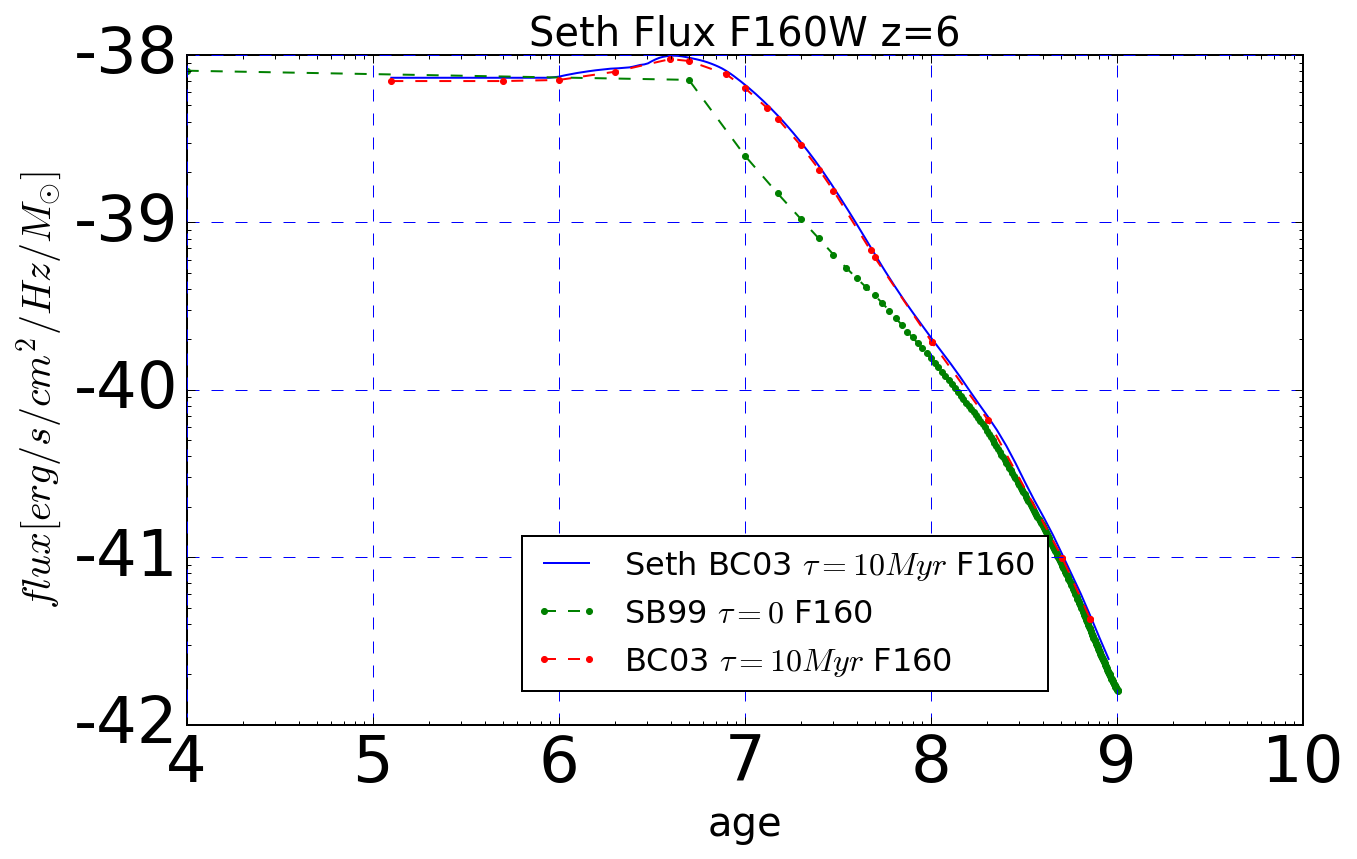

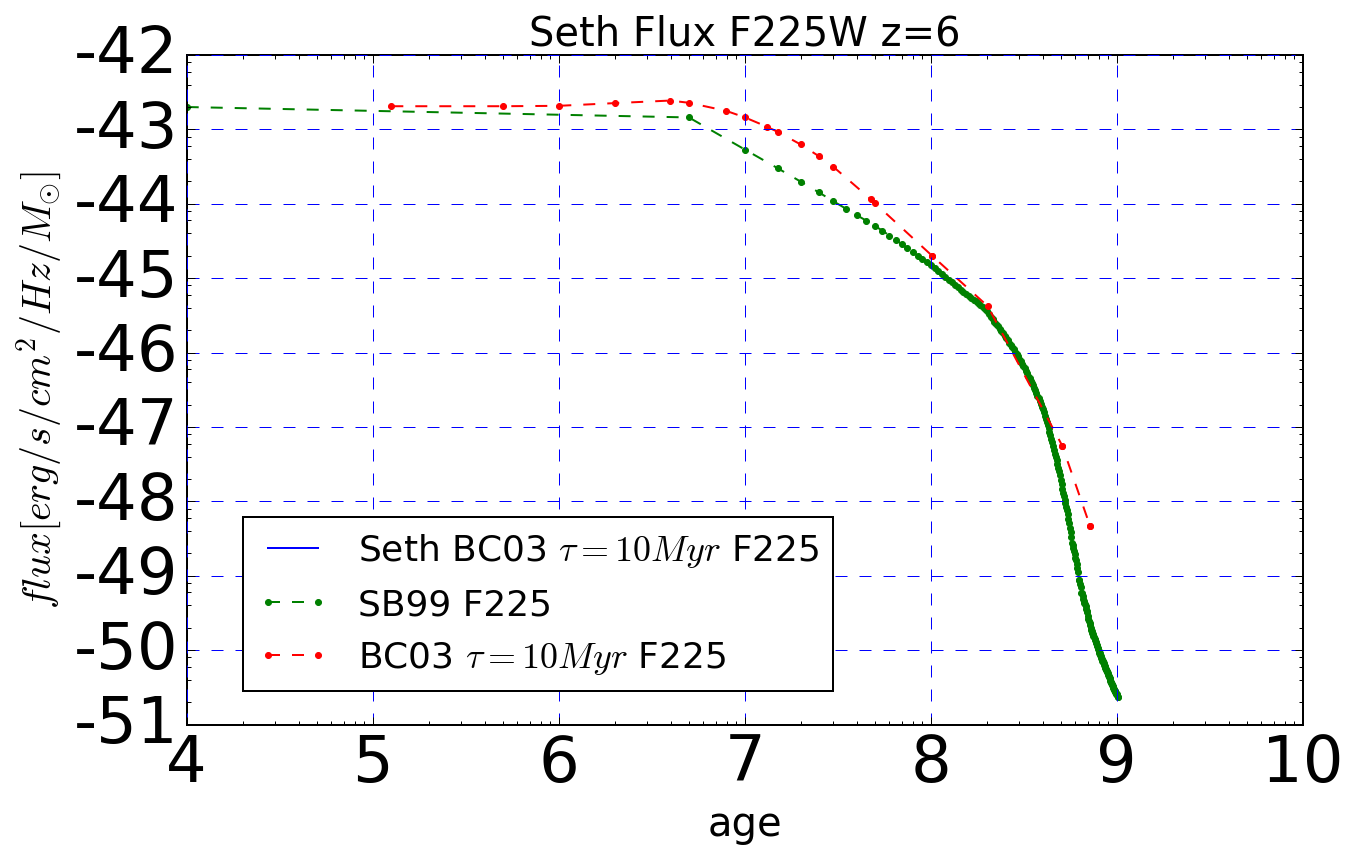

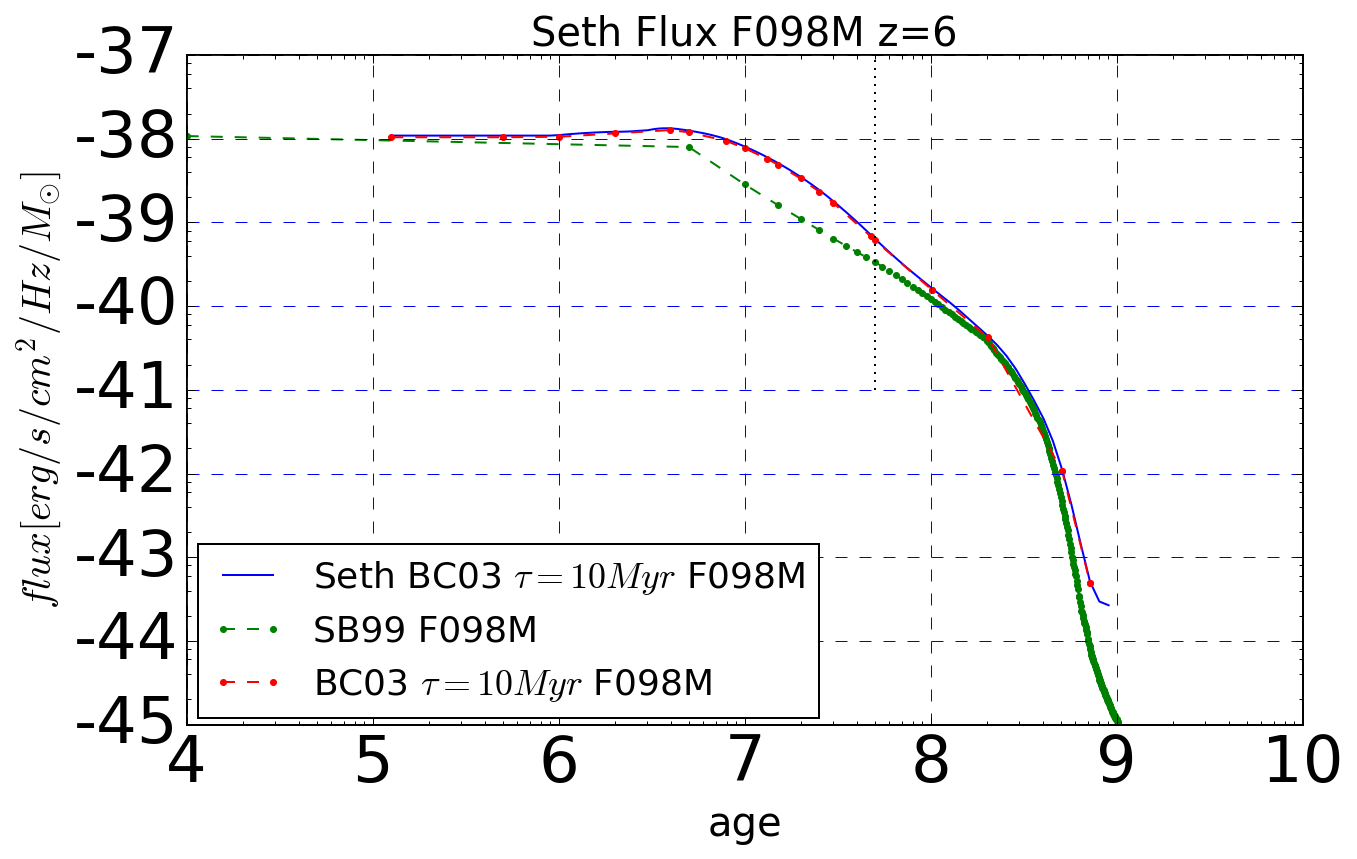

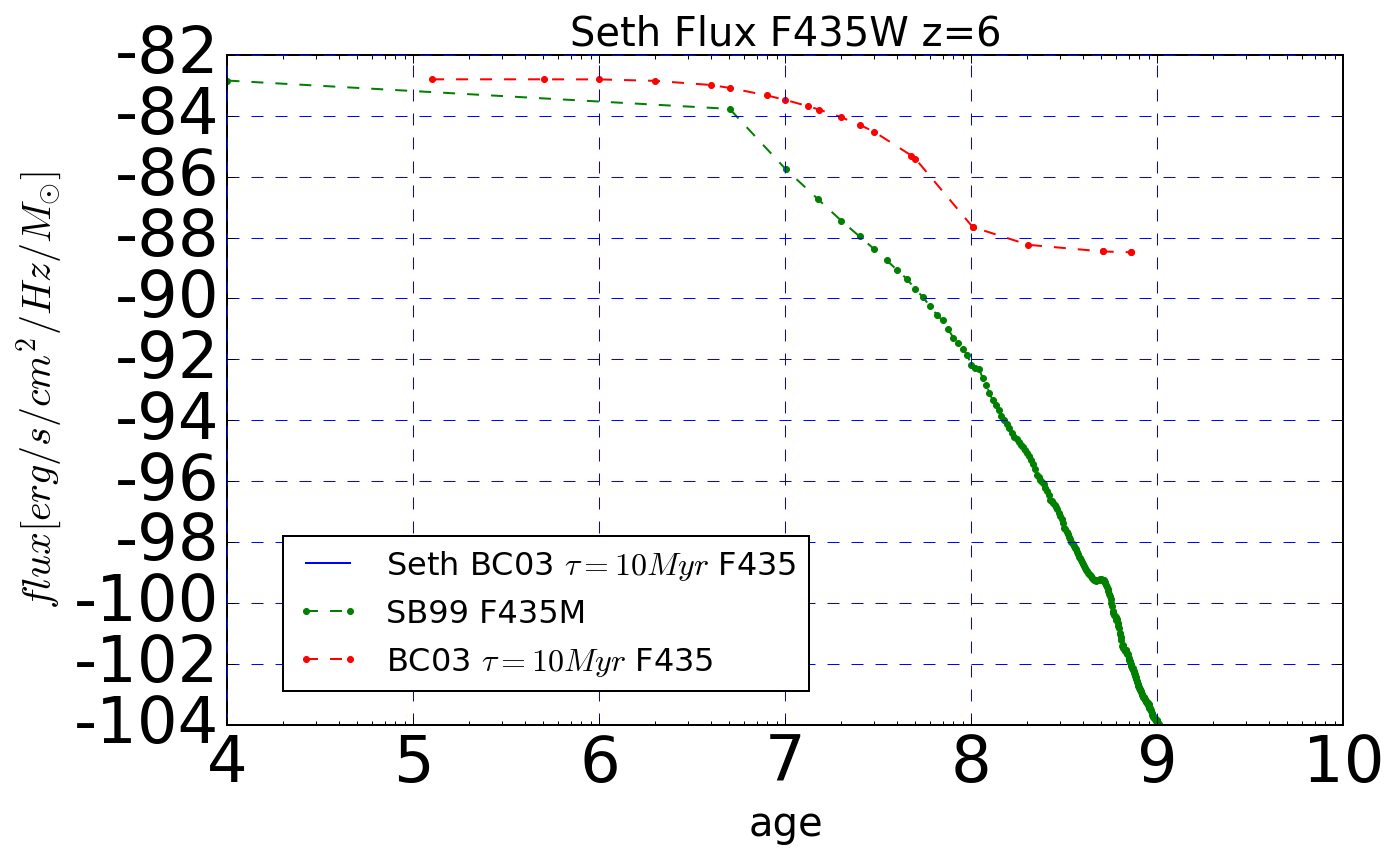

In [68]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth160z6Data['age'],seth160z6Data['filtfluxz'][0][0])
ax.plot(filterFluxsF160z6[:,0],filterFluxsF160z6[:,1],"g.--")
ax.plot(BC03_z6F160FluxSeth[:,0],BC03_z6F160FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F160W z=6',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F160',r'SB99 $\tau=0$ F160', r'BC03 $\tau=10Myr$ F160'],
              loc=(0.3,0.05), fontsize=16 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth225z6Data['age'],seth225z6Data['filtfluxz'][0][0])
ax.plot(filterFluxsF225z6[:,0],filterFluxsF225z6[:,1],"g.--")
ax.plot(BC03_z6F225FluxSeth[:,0],BC03_z6F225FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F225W z=6',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F225','SB99 F225', r'BC03 $\tau=10Myr$ F225'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth098z6Data['age'],seth098z6Data['filtfluxz'][0][0])
ax.plot(filterFluxsF098z6[:,0],filterFluxsF098z6[:,1],"g.--")
ax.plot(BC03_z6F098FluxSeth[:,0],BC03_z6F098FluxSeth[:,1],"r.--")
ax.plot([50e6,50e6],[1e-41,1e-37],'k:')
# ax.annotate('50 Myr', xy=(50e6, 1e-41), xytext=(50e6, 2e-41),size=16,
#             arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F098M z=6',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F098M','SB99 F098M', r'BC03 $\tau=10Myr$ F098M'],
              loc=(0.01,0.01), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth435z6Data['age'],seth435z6Data['filtfluxz'][0][0])
ax.plot(filterFluxsF435z6[:,0],filterFluxsF435z6[:,1],"g.--")
ax.plot(BC03_z6F435FluxSeth[:,0],BC03_z6F435FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F435W z=6',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F435','SB99 F435M',r'BC03 $\tau=10Myr$ F435'],
              loc=(0.05,0.05), fontsize=16 )
gc.collect()



In [27]:
# Seth's files have zero flux in the F225 and F435 filters, but I show flux... 
seth435z6Data['filtfluxz'][0][0][seth435z6Data['age'] == 1.01518000e+08], \
seth225z6Data['filtfluxz'][0][0][seth225z6Data['age'] == 1.01518000e+08], \
seth225z6Data['age'][seth225z6Data['age'] == 1.01518000e+08]

(array([-99.]), array([-99.]), array([  1.01518000e+08], dtype=float32))

In [28]:
rs2SB02_100MyrWaveLn, rs2SB02_100MyrLperA = lyA.rsSEDwavelen(SB02_100Myr[:,1],SB02_100Myr[:,2],2)
rs2BC03seth_100MyrWaveLn, rs2BC03seth_100MyrLperA = lyA.rsSEDwavelen(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],2)

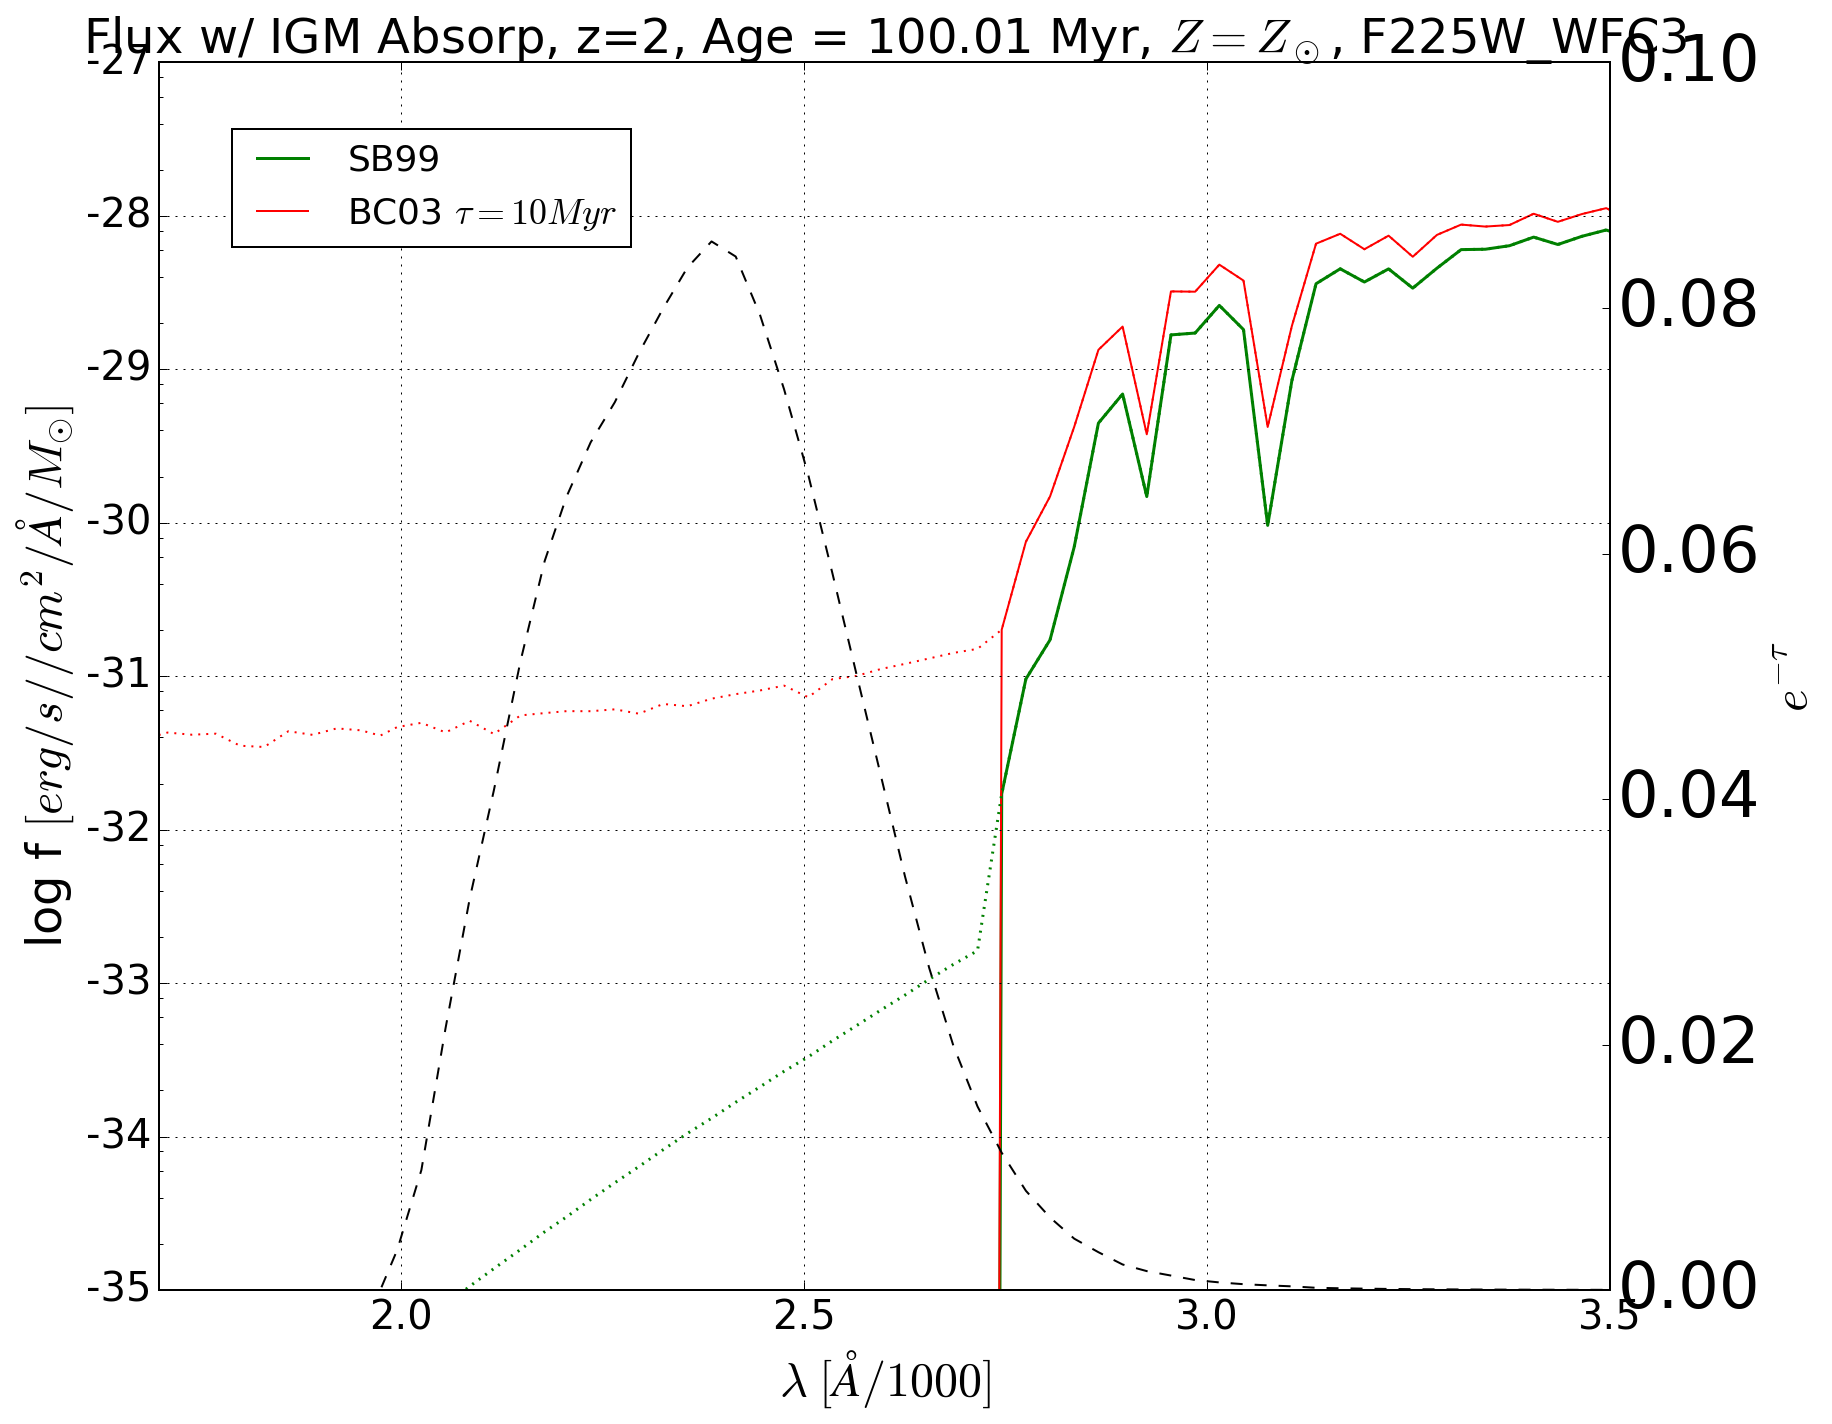

In [30]:
# Plot the z=2 flux around the F435 filter... 
gc.collect()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rs2SB02_100MyrWaveLn, rs2SB02_100MyrLperA*lyA.lyTauC(2)(rs2SB02_100MyrWaveLn),'g-',lw=1.5)
ax.plot(rs2BC03seth_100MyrWaveLn, rs2BC03seth_100MyrLperA*lyA.lyTauC(2)(rs2BC03seth_100MyrWaveLn),'r-')
ax.plot(rs2SB02_100MyrWaveLn, rs2SB02_100MyrLperA*lyA.lyTau(2)(rs2SB02_100MyrWaveLn),'g:',lw=1.5)
ax.plot(rs2BC03seth_100MyrWaveLn, rs2BC03seth_100MyrLperA*lyA.lyTau(2)(rs2BC03seth_100MyrWaveLn),'r:')

ax2 = ax.twinx()
ax2.set_xlim([1.7e3,3.5e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F225W_WFC3'](rsBC03ssp_100MyrWaveLn),'k--')

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1.7e3,3.5e3])
ax.set_ylim([1e-35,1e-27])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99',r'BC03 $\tau=10Myr$'],
              loc=(0.05,0.85), fontsize=18 )

ax.set_title('Flux w/ IGM Absorp, z=2, Age = %.2lf Myr, $Z = Z_\odot$, F225W_WFC3'%(SB02[sbage100][0,0]/1e6), fontsize=24)


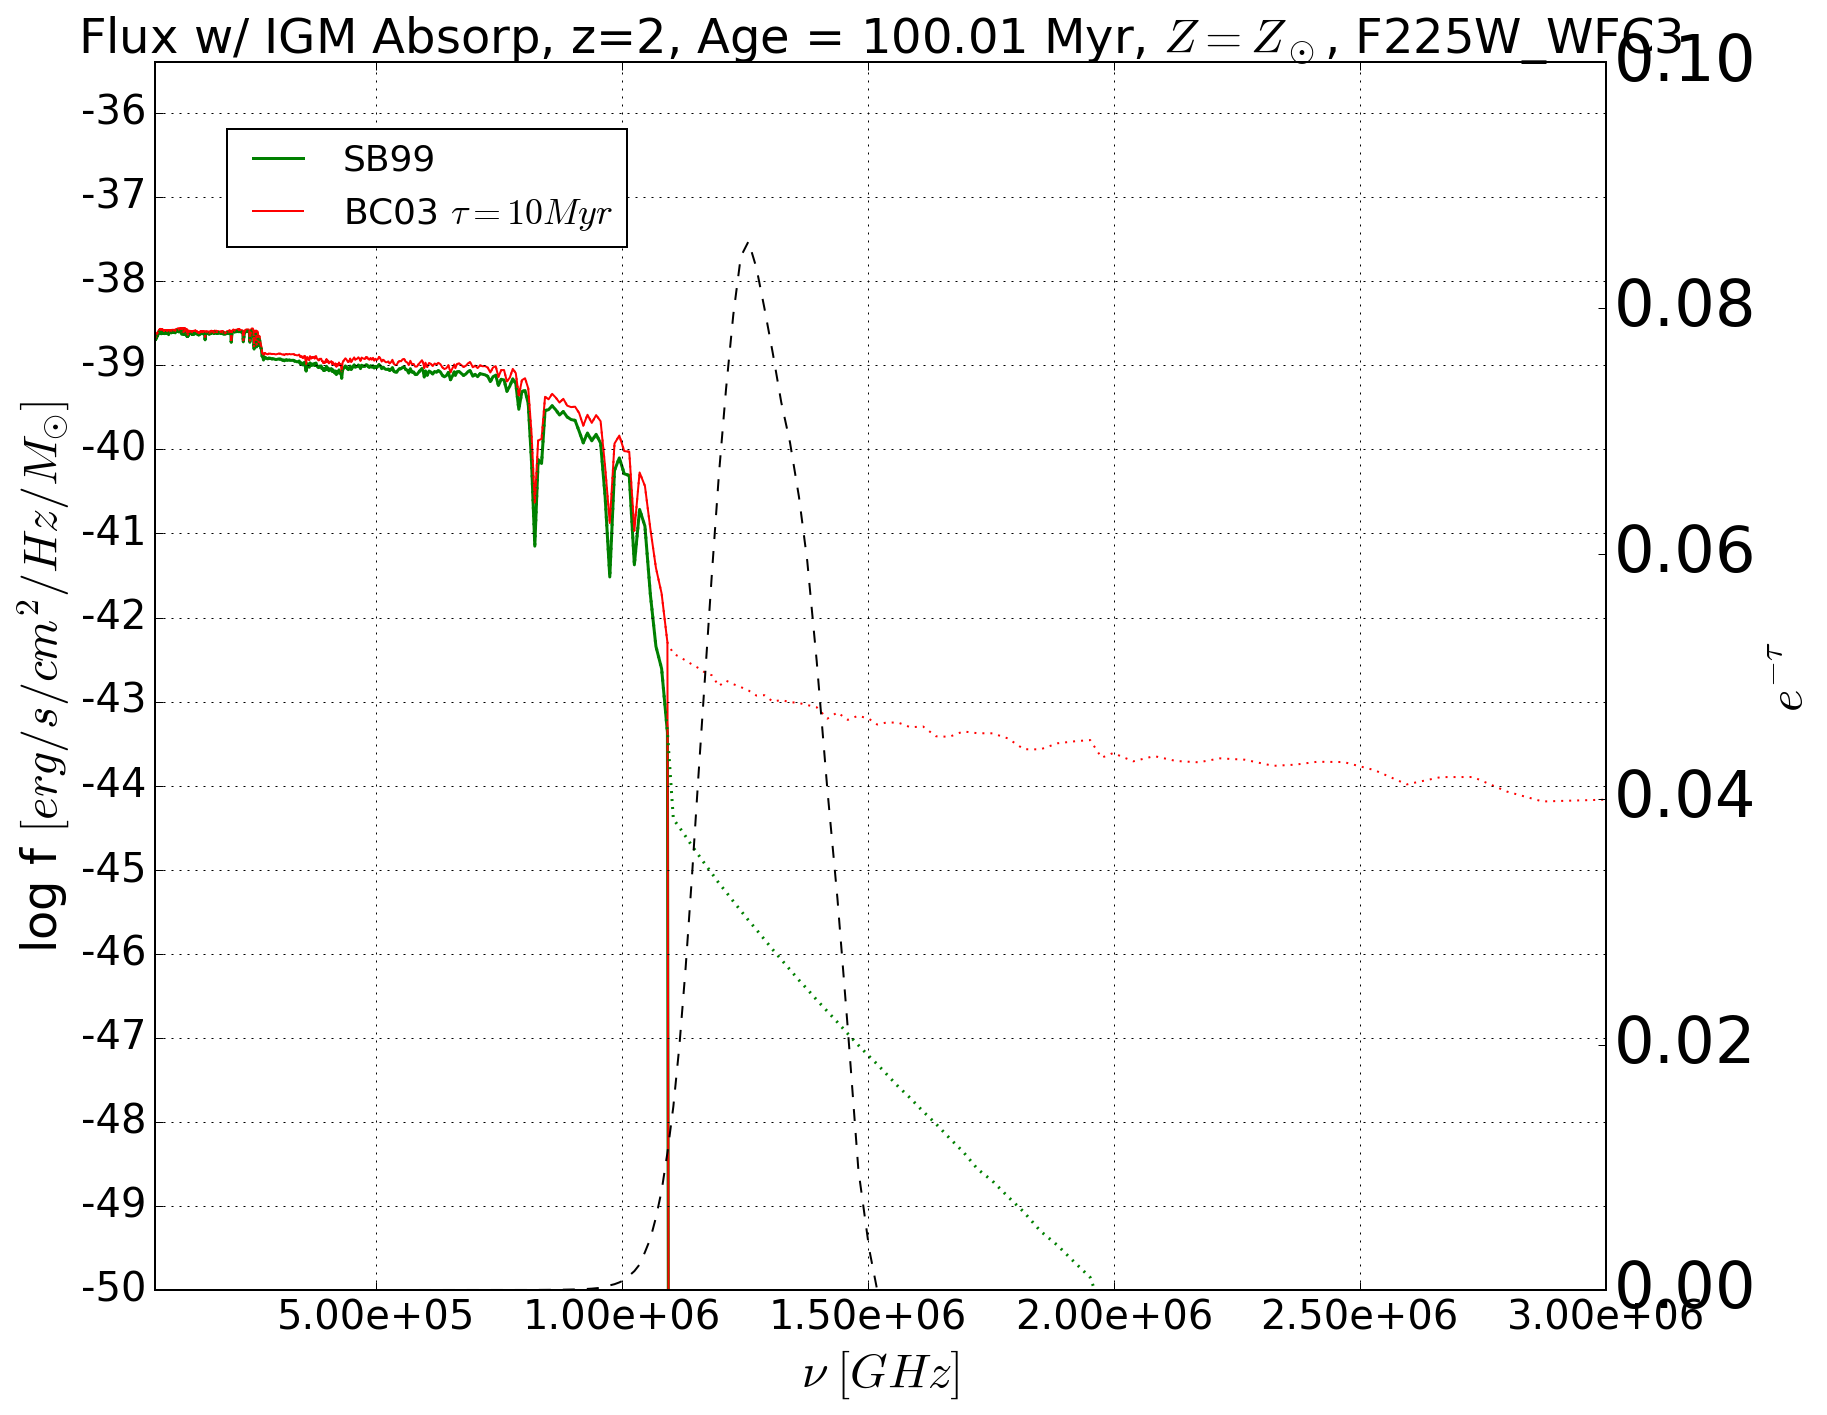

In [31]:
# Plot the z=2 flux around the F435 filter... 
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')
rs2SB100,rs2SB100HzC = lyA.AtoHz(rs2SB02_100MyrWaveLn, rs2SB02_100MyrLperA*lyA.lyTauC(2)(rs2SB02_100MyrWaveLn))
rs2seth100,rs2seth100HzC = lyA.AtoHz(rs2BC03seth_100MyrWaveLn, rs2BC03seth_100MyrLperA*lyA.lyTauC(2)(rs2BC03seth_100MyrWaveLn))
rs2SB100,rs2SB100Hz = lyA.AtoHz(rs2SB02_100MyrWaveLn, rs2SB02_100MyrLperA*lyA.lyTau(2)(rs2SB02_100MyrWaveLn))
rs2seth100,rs2seth100Hz = lyA.AtoHz(rs2BC03seth_100MyrWaveLn, rs2BC03seth_100MyrLperA*lyA.lyTau(2)(rs2BC03seth_100MyrWaveLn))

ax.plot(rs2SB100,rs2SB100HzC,'g-',lw=1.5)
ax.plot(rs2seth100,rs2seth100HzC,'r-')
ax.plot(rs2SB100,rs2SB100Hz,'g:',lw=1.5)
ax.plot(rs2seth100,rs2seth100Hz,'r:')

ax2 = ax.twinx()
# ax2.set_xlim([1.7e3,3.5e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rs2SB100,hubbleFilters['F225W_WFC3'](rsBC03ssp_100MyrWaveLn[::-1]),'k--')

ax.xaxis.set_major_formatter(GHzfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([5e13,3e15])
ax.set_ylim([1e-50,4e-36])

ax.set_xlabel(r'$\nu\; [GHz]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ cm^2/ Hz/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99',r'BC03 $\tau=10Myr$'],
              loc=(0.05,0.85), fontsize=18 )

ax.set_title('Flux w/ IGM Absorp, z=2, Age = %.2lf Myr, $Z = Z_\odot$, F225W_WFC3'%(SB02[sbage100][0,0]/1e6), fontsize=24)


In [39]:
# Spot check flux at 100 Myr in F435... 

In [45]:
# Redshift the SEDs for SB99 and Seth's BC03 to z=6
rs6SB02_100MyrWaveLn, rs6SB02_100MyrLperA = lyA.rsSEDwavelen(SB02_100Myr[:,1],SB02_100Myr[:,2],6)
rs6BC03seth_100MyrWaveLn, rs6BC03seth_100MyrLperA = lyA.rsSEDwavelen(BC03_100Myrseth[:,0],BC03_100Myrseth[:,1],6)

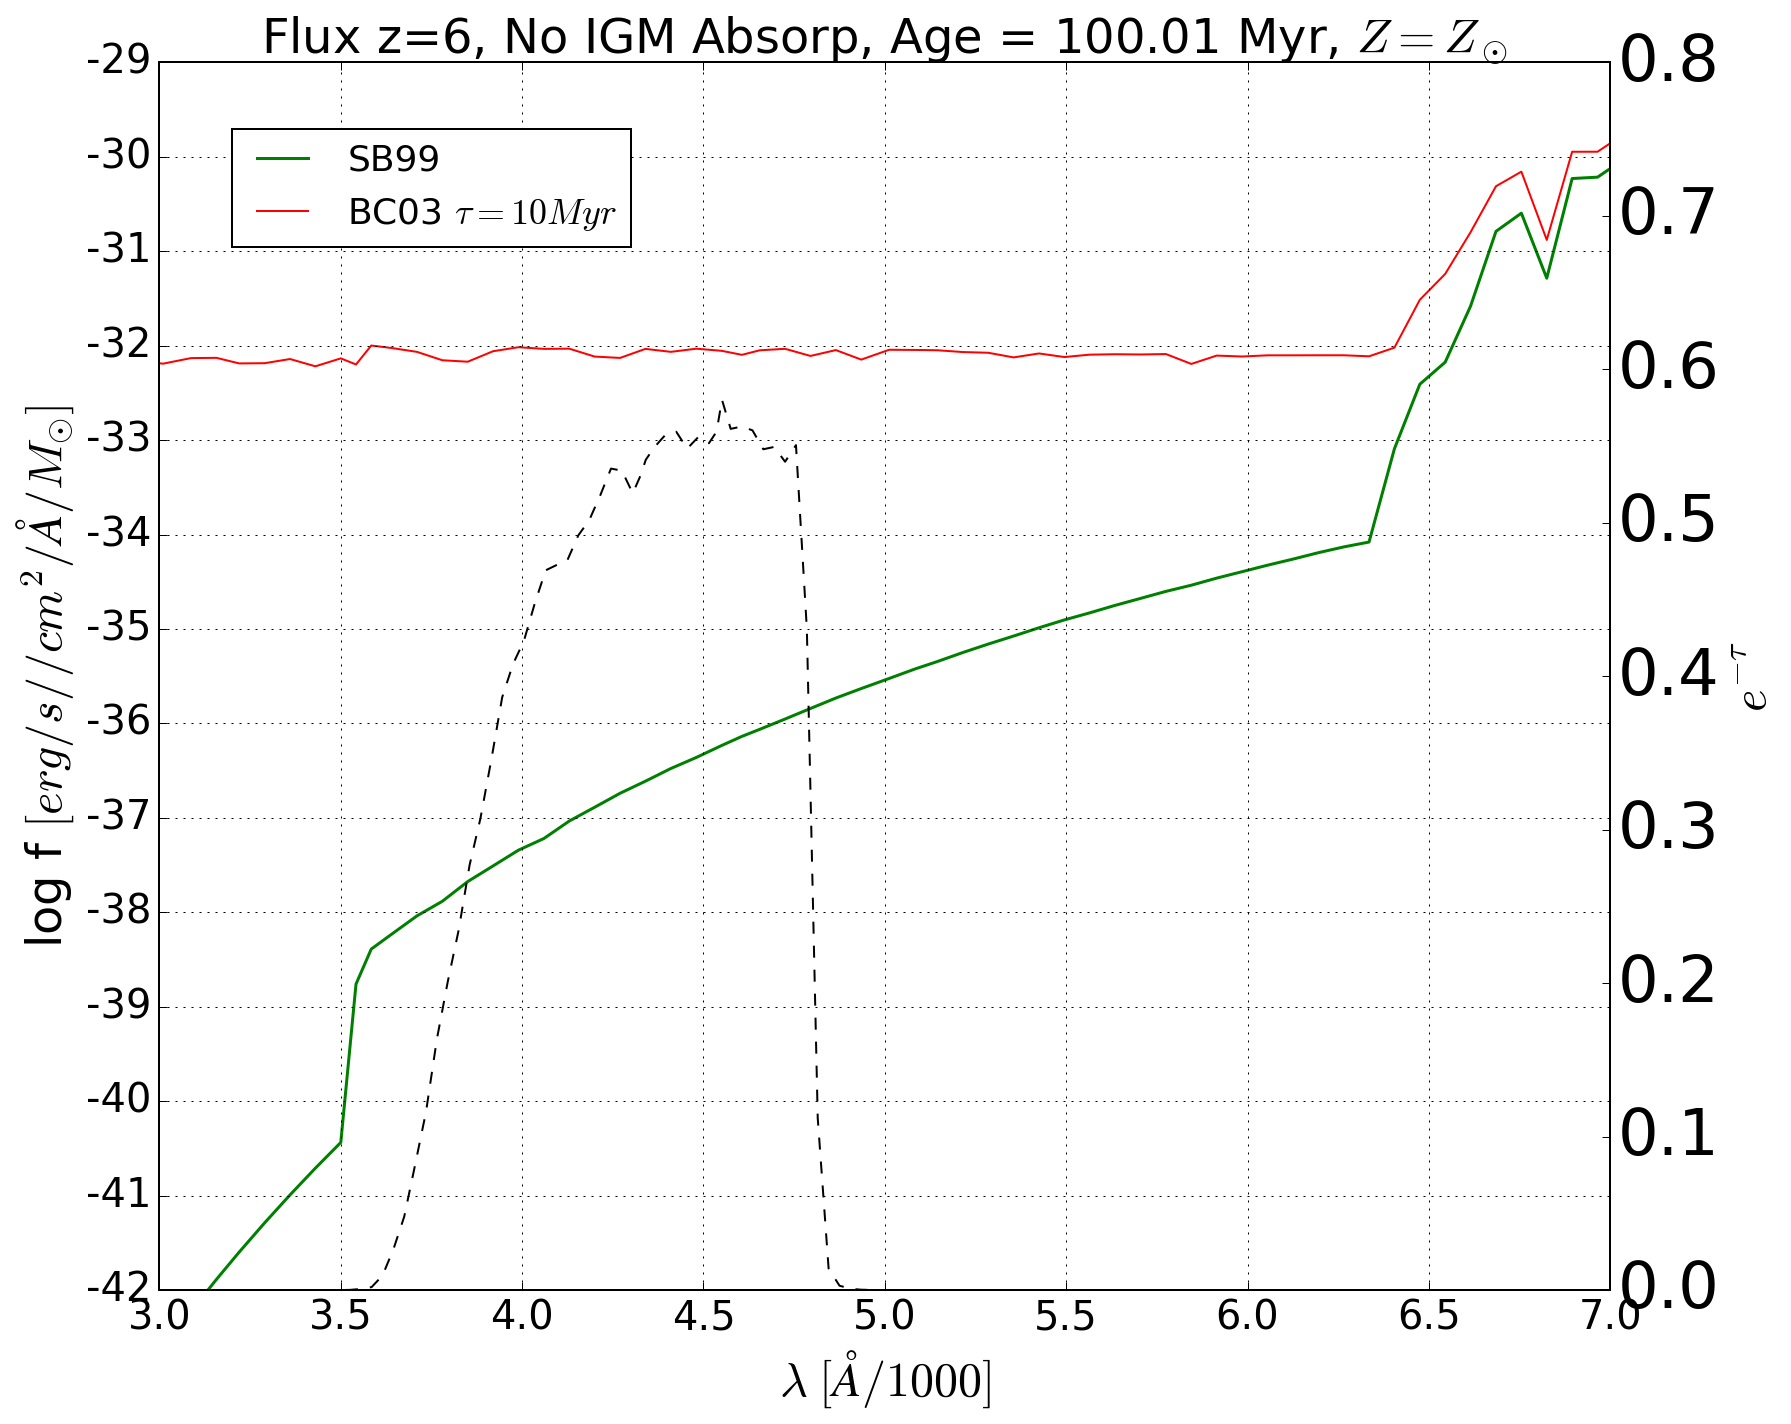

In [69]:
# Plot the z=6 flux around the F435 filter... 
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rs6SB02_100MyrWaveLn, rs6SB02_100MyrLperA,'g-',lw=1.5)
ax.plot(rs6BC03seth_100MyrWaveLn, rs6BC03seth_100MyrLperA,'r-')

ax2 = ax.twinx()
ax2.set_xlim([3e3,7e3])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F435W_ACS'](rsBC03ssp_100MyrWaveLn),'k--')

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([3e3,7e3])
ax.set_ylim([1e-42,1e-29])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99',r'BC03 $\tau=10Myr$'],
              loc=(0.05,0.85), fontsize=18 )

ax.set_title('Flux z=6, No IGM Absorp, Age = %.2lf Myr, $Z = Z_\odot$'%(SB02[sbage100][0,0]/1e6), fontsize=24)


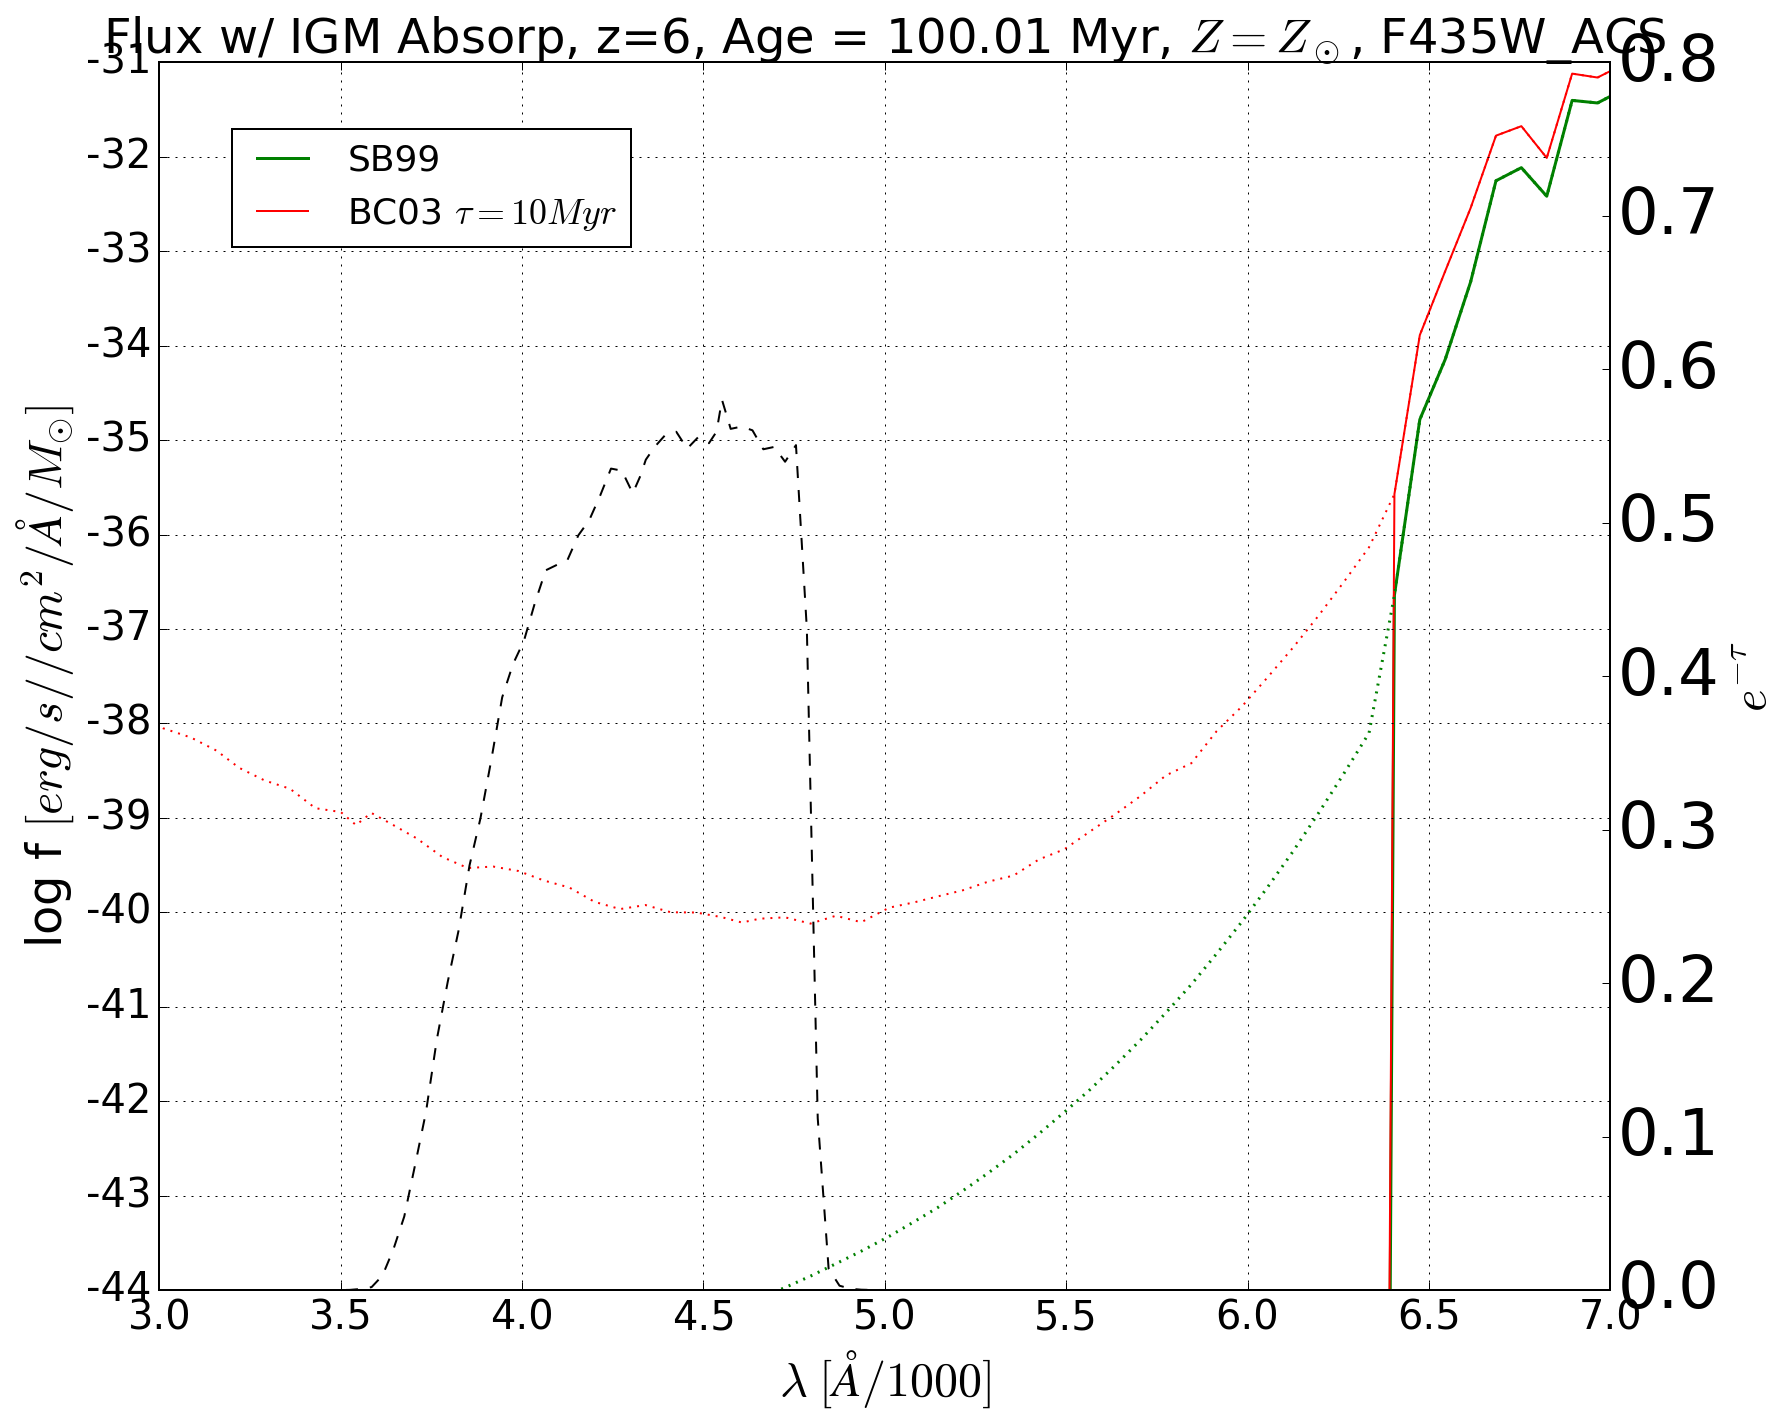

In [84]:
# Plot the z=6 flux around the F435 filter... 
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rs6SB02_100MyrWaveLn, rs6SB02_100MyrLperA*lyA.lyTauC(6)(rs6SB02_100MyrWaveLn),'g-',lw=1.5)
ax.plot(rs6BC03seth_100MyrWaveLn, rs6BC03seth_100MyrLperA*lyA.lyTauC(6)(rs6BC03seth_100MyrWaveLn),'r-')
ax.plot(rs6SB02_100MyrWaveLn, rs6SB02_100MyrLperA*lyA.lyTau(6)(rs6SB02_100MyrWaveLn),'g:',lw=1.5)
ax.plot(rs6BC03seth_100MyrWaveLn, rs6BC03seth_100MyrLperA*lyA.lyTau(6)(rs6BC03seth_100MyrWaveLn),'r:')

ax2 = ax.twinx()
ax2.set_xlim([3e3,7e3])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F435W_ACS'](rsBC03ssp_100MyrWaveLn),'k--')

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([3e3,7e3])
ax.set_ylim([1e-44,1e-31])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['SB99',r'BC03 $\tau=10Myr$'],
              loc=(0.05,0.85), fontsize=18 )

ax.set_title('Flux w/ IGM Absorp, z=6, Age = %.2lf Myr, $Z = Z_\odot$, F435W_ACS'%(SB02[sbage100][0,0]/1e6), fontsize=24)


# Look at my files... 

In [34]:
sb9902fluxz2 = np.genfromtxt('./SB9902_2.0.gz',names=True, delimiter=',')
sb9902fluxz6 = np.genfromtxt('./SB9902_6.0.gz',names=True, delimiter=',')

445

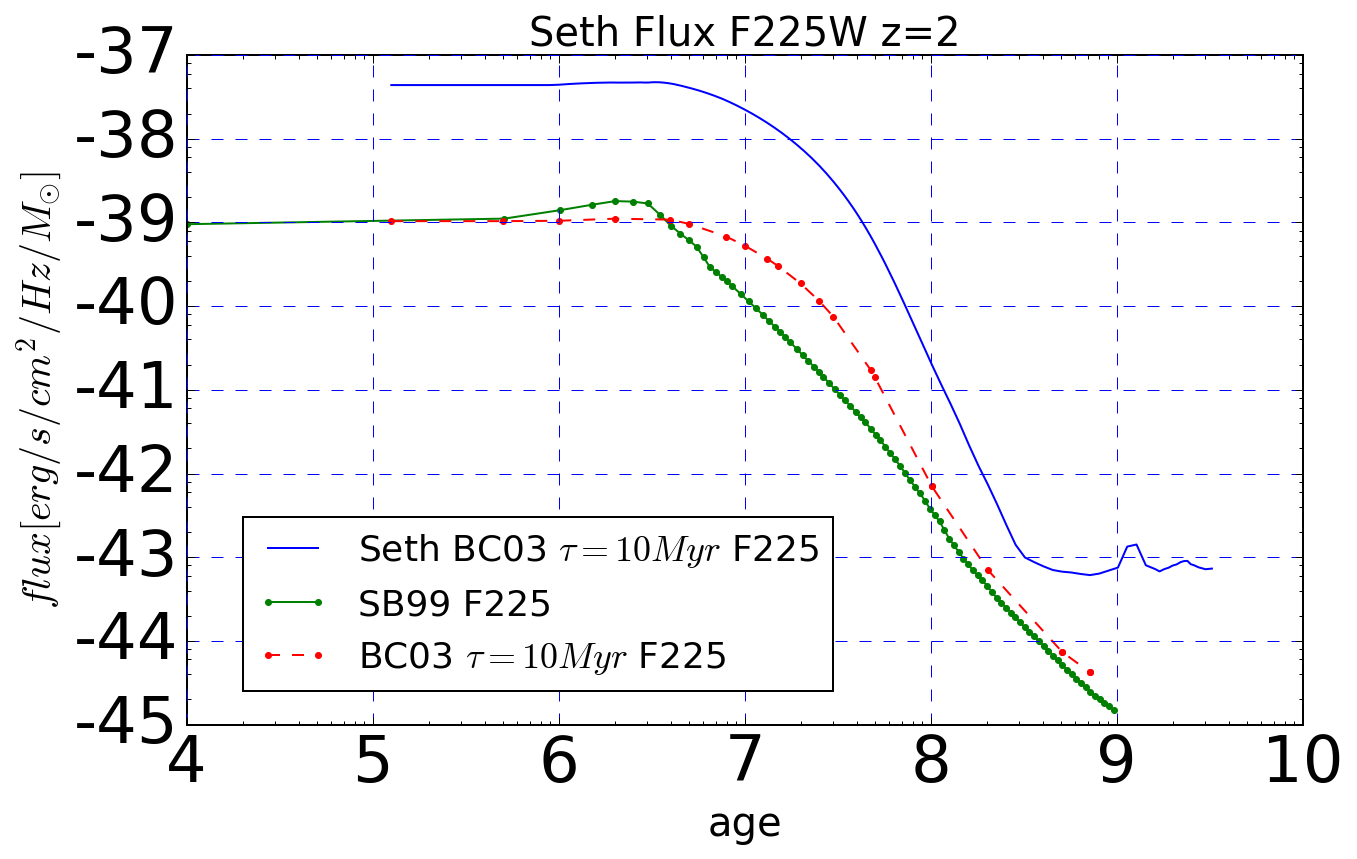

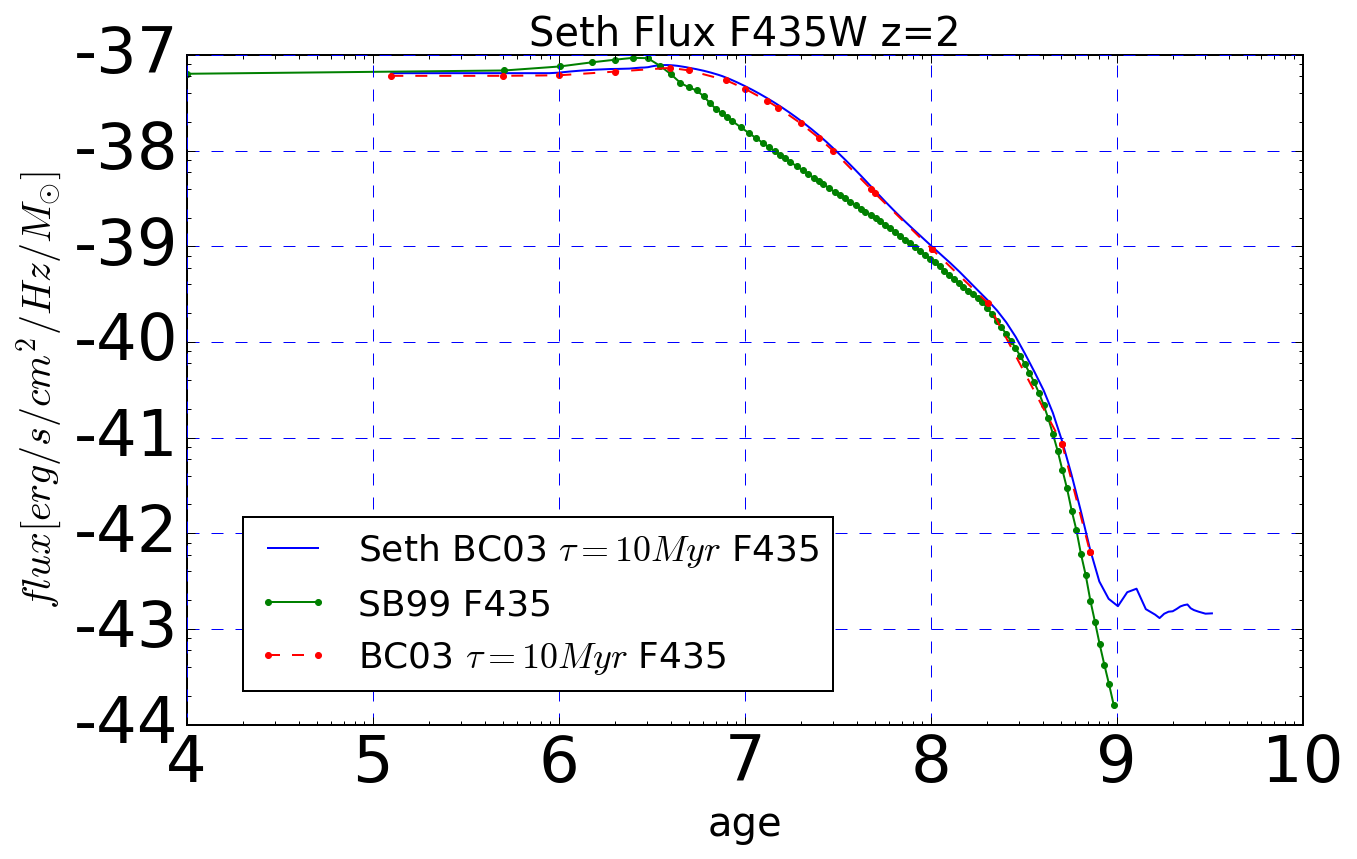

In [33]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth225z2Data['age'],seth225z2Data['filtfluxz'][0][0])
ax.plot(10**sb9902fluxz2['LogAge'],sb9902fluxz2['F225W_WFC3'],"g.-")
ax.plot(BC03_z2F225FluxSeth[:,0],BC03_z2F225FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F225W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F225','SB99 F225', r'BC03 $\tau=10Myr$ F225'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth435z2Data['age'],seth435z2Data['filtfluxz'][0][0])
ax.plot(10**sb9902fluxz2['LogAge'],sb9902fluxz2['F435W_ACS'],"g.-")
ax.plot(BC03_z2F435FluxSeth[:,0],BC03_z2F435FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F435W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F435','SB99 F435', r'BC03 $\tau=10Myr$ F435'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

445

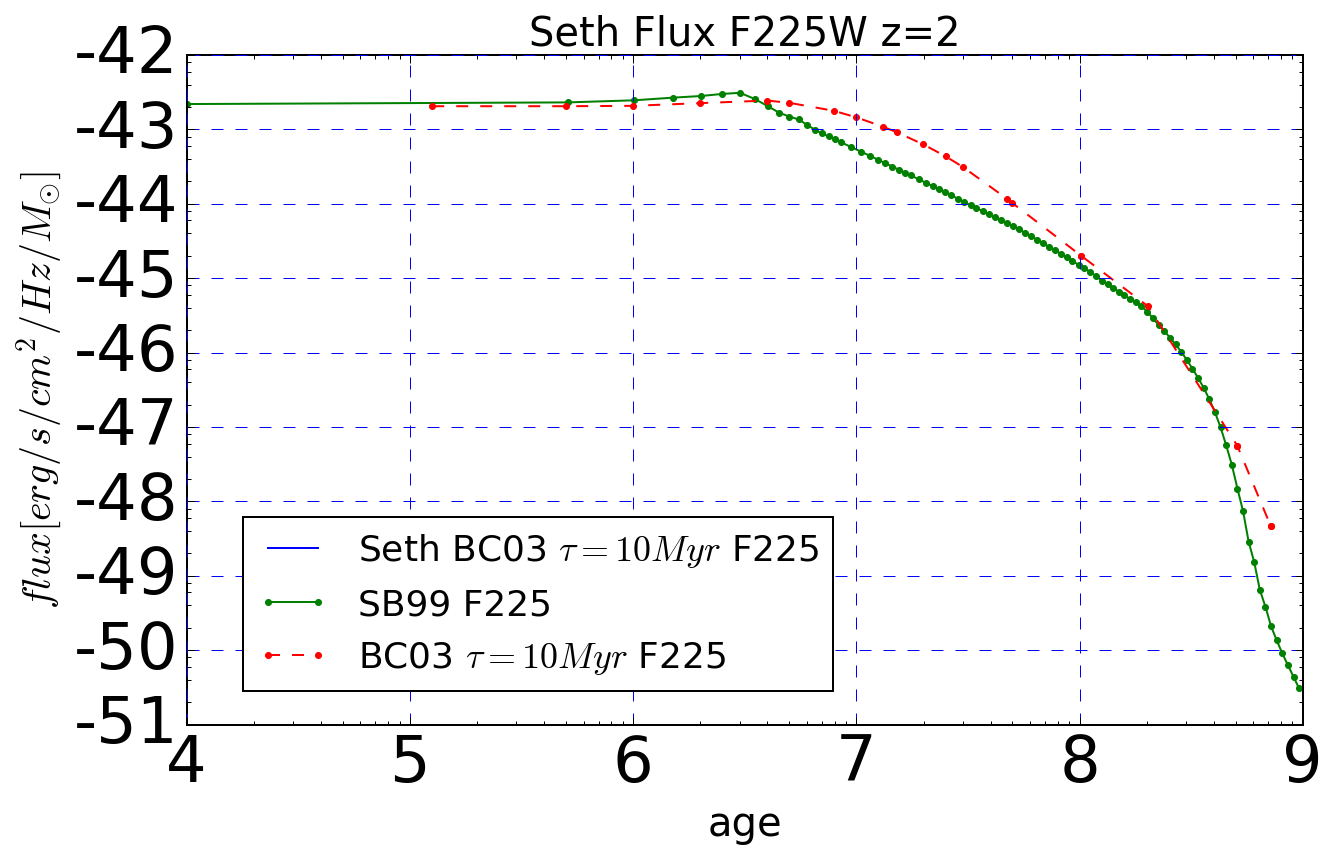

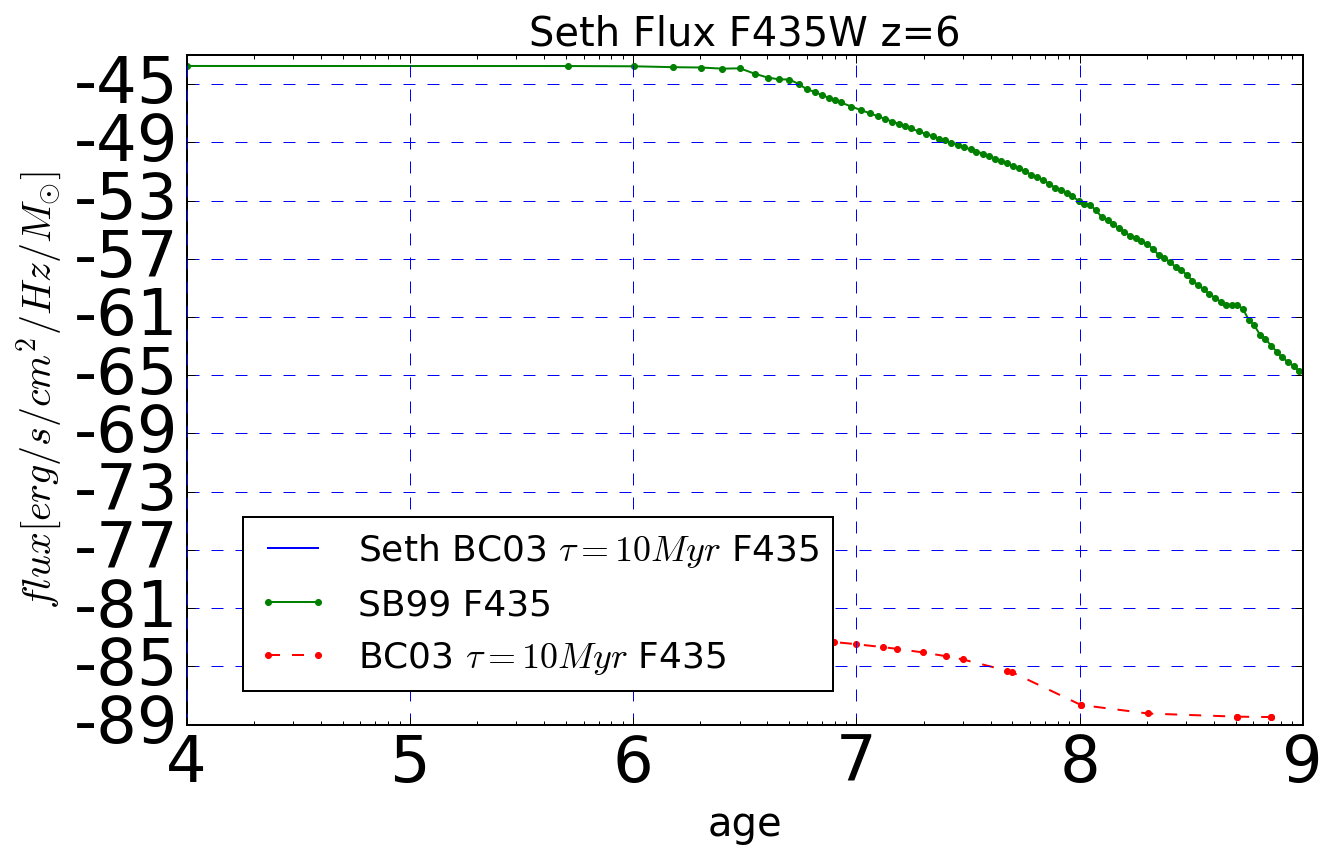

In [35]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth225z6Data['age'],seth225z6Data['filtfluxz'][0][0])
ax.plot(10**sb9902fluxz6['LogAge'],sb9902fluxz6['F225W_WFC3'],"g.-")
ax.plot(BC03_z6F225FluxSeth[:,0],BC03_z6F225FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F225W z=2',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F225','SB99 F225', r'BC03 $\tau=10Myr$ F225'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(seth435z6Data['age'],seth435z6Data['filtfluxz'][0][0])
ax.plot(10**sb9902fluxz6['LogAge'],sb9902fluxz6['F435W_ACS'],"g.-")
ax.plot(BC03_z6F435FluxSeth[:,0],BC03_z6F435FluxSeth[:,1],"r.--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Seth Flux F435W z=6',size=labelsize)
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)

ax.legend([r'Seth BC03 $\tau=10Myr$ F435','SB99 F435', r'BC03 $\tau=10Myr$ F435'],
              loc=(0.05,0.05), fontsize=18 )
gc.collect()

# Descrep above due to bad optical depth for my SB99 data... 

# Look at SEDs - Use Seth's star formation and BC03 models...

In [85]:
rsBC03_100ky_wl, rsBC03_100ky_LperA = lyA.rsSEDwavelen(BC03_seth[0][:,0],BC03_seth[0][:,1],6)
rsBC03_500ky_wl, rsBC03_500ky_LperA = lyA.rsSEDwavelen(BC03_seth[1][:,0],BC03_seth[1][:,1],6)
rsBC03_1my_wl, rsBC03_1my_LperA     = lyA.rsSEDwavelen(BC03_seth[2][:,0],BC03_seth[2][:,1],6)
rsBC03_2my_wl, rsBC03_2my_LperA     = lyA.rsSEDwavelen(BC03_seth[3][:,0],BC03_seth[3][:,1],6)
rsBC03_4my_wl, rsBC03_4my_LperA     = lyA.rsSEDwavelen(BC03_seth[4][:,0],BC03_seth[4][:,1],6)
rsBC03_10my_wl, rsBC03_10my_LperA   = lyA.rsSEDwavelen(BC03_seth[7][:,0],BC03_seth[7][:,1],6)
rsBC03_50my_wl, rsBC03_50my_LperA   = lyA.rsSEDwavelen(BC03_seth[14][:,0],BC03_seth[14][:,1],6)

rsBC03_200my_wl, rsBC03_200my_LperA   = lyA.rsSEDwavelen(BC03_seth[17][:,0],BC03_seth[17][:,1],6)


31190

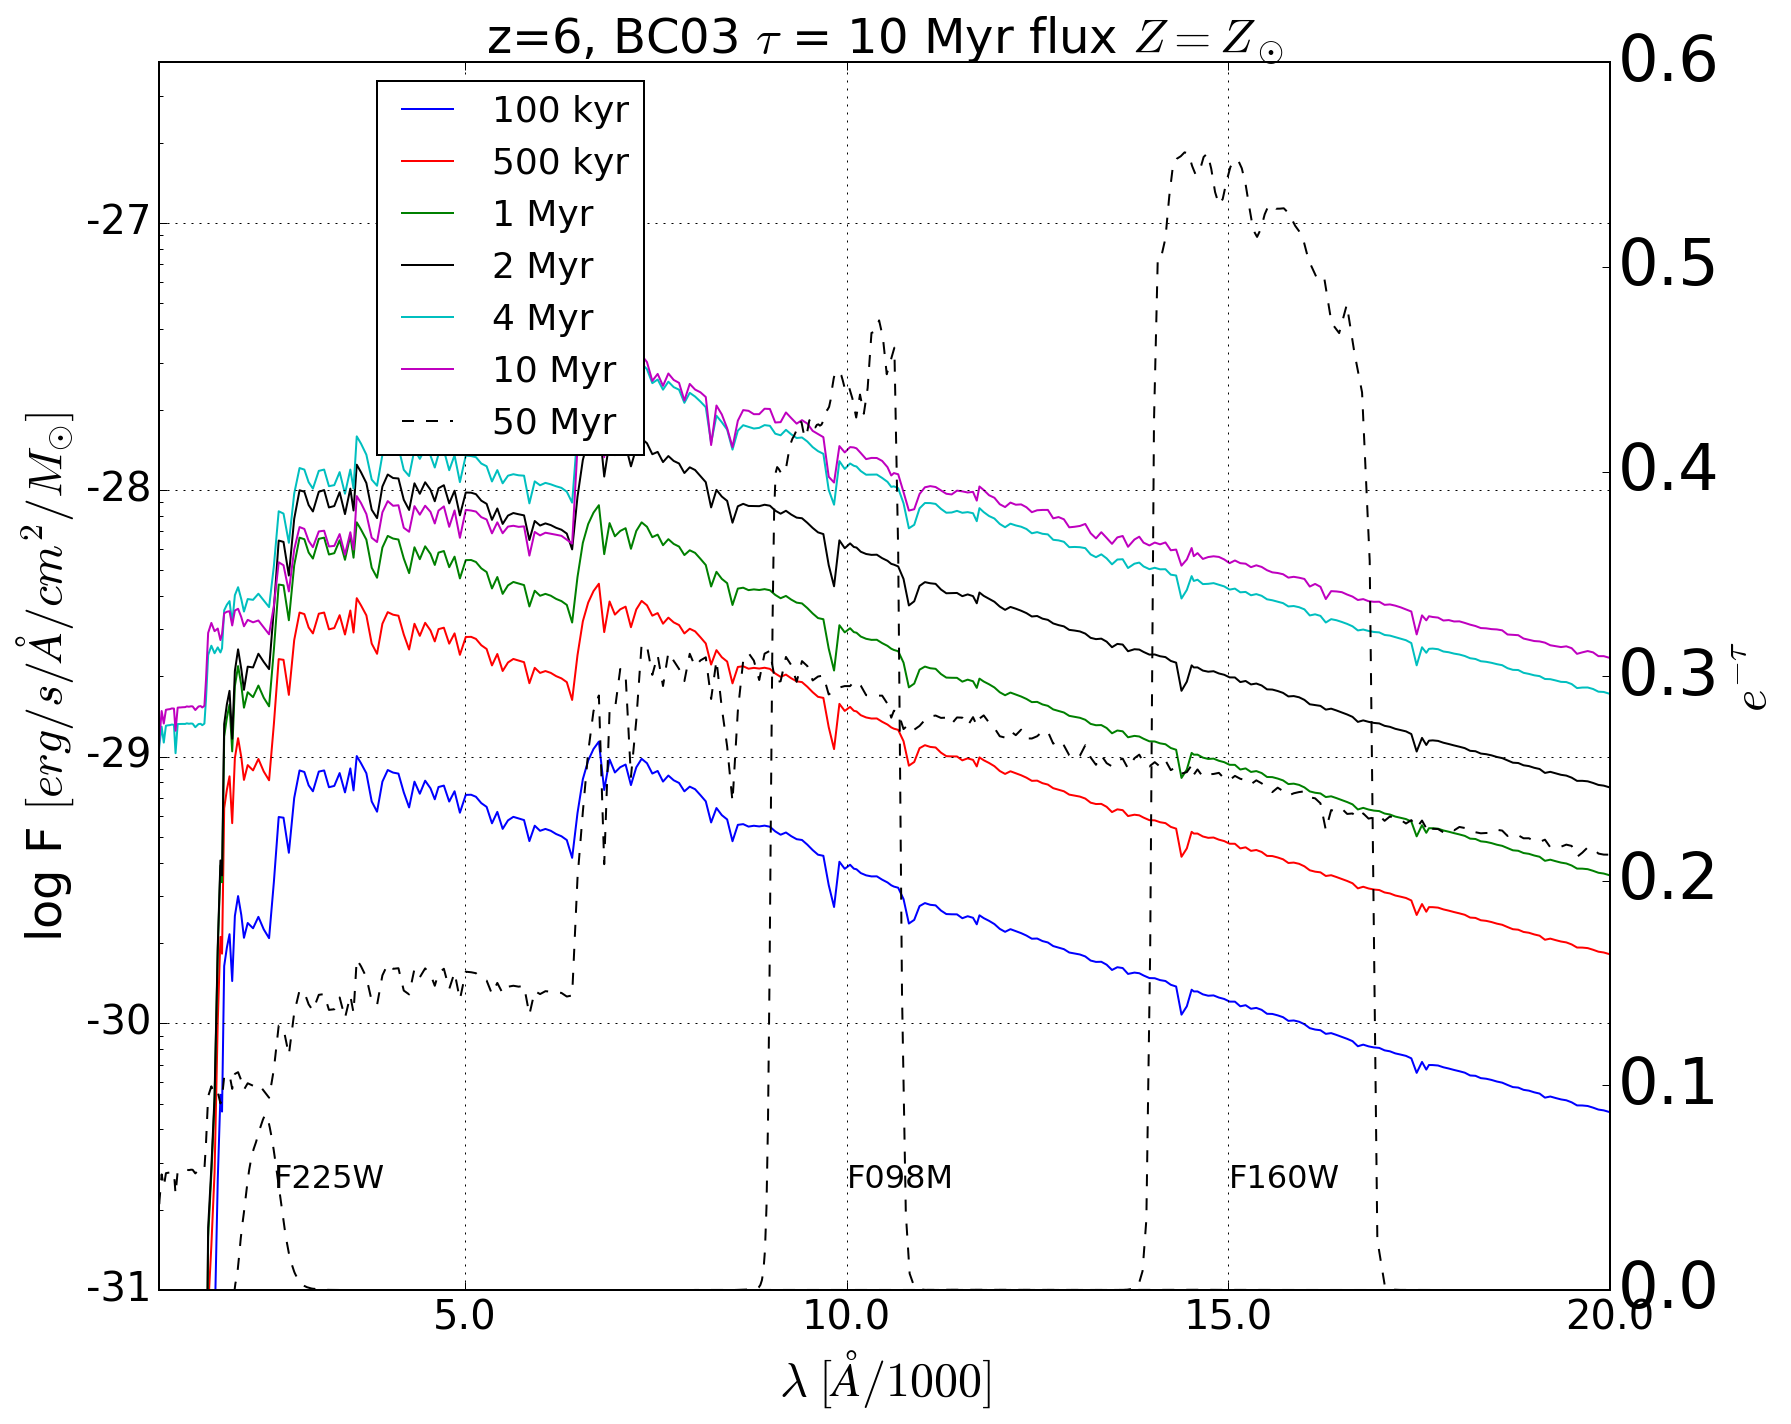

In [77]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA,'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e3,2e4])
ax.set_ylim([1e-31,4e-27])

ax2 = ax.twinx()
ax2.set_xlim([1e3,2e4])
ax2.set_ylim([0,0.6])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F160W', xy=(15000, 0), xytext=(15000,0.05),size=16)
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.05),size=16)
ax2.annotate('F098M', xy=(10000, 0), xytext=(10000,0.05),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.xaxis.set_major_formatter(divfmt)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.15,0.68), fontsize=18 )

ax.set_title(r'z=6, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

28153

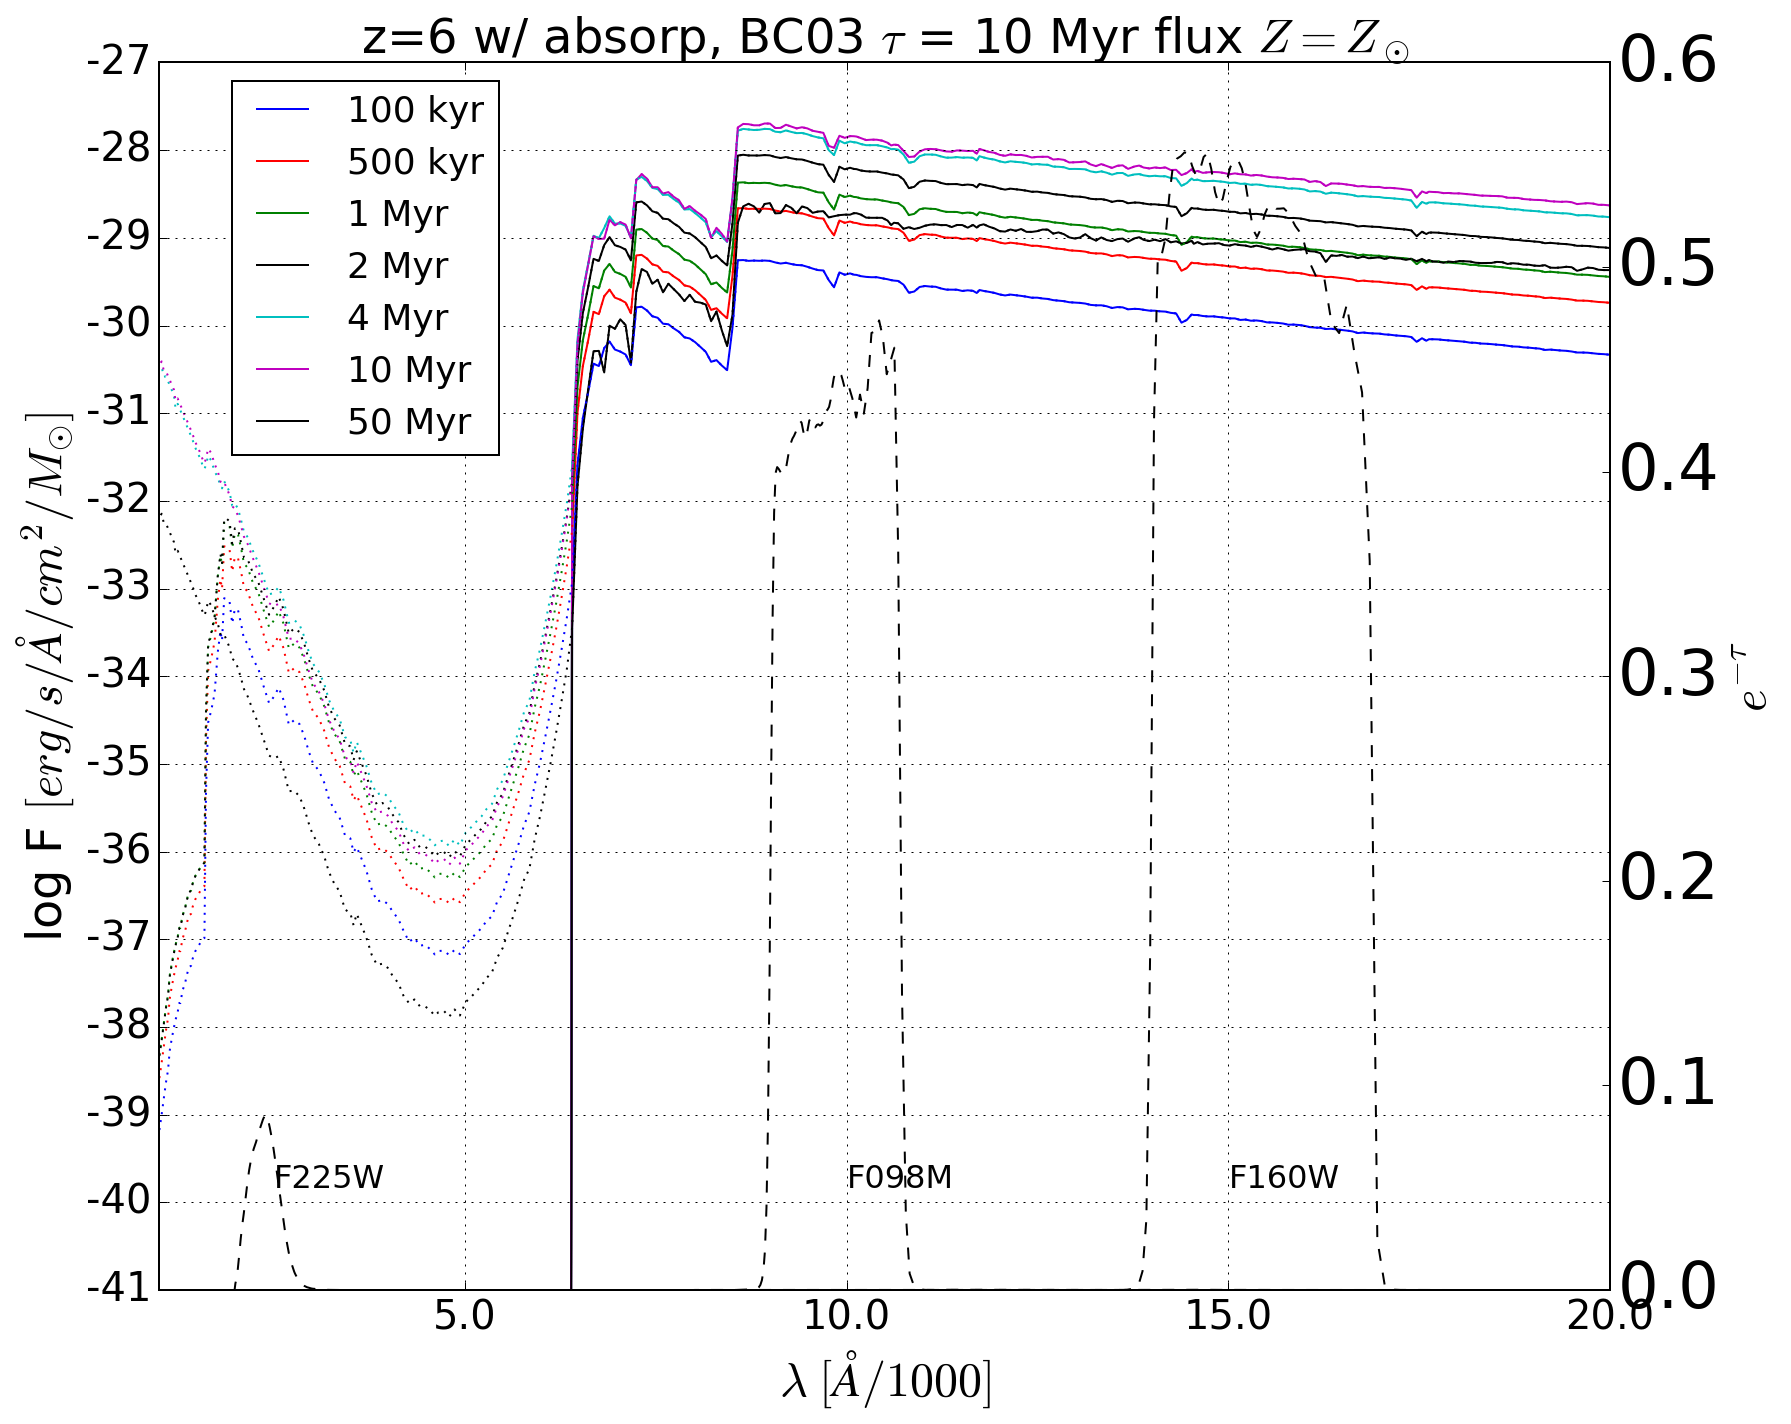

In [89]:
# Apply IGM absorption
#
## POSSIBLE PROBLEM WITH Tau (absorption function)
# IT GOES BACK UP for lower lambda
#
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA*lyA.lyTauC(6.0)(rsBC03_100ky_wl),'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA*lyA.lyTauC(6.0)(rsBC03_500ky_wl),'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA*lyA.lyTauC(6.0)(rsBC03_1my_wl),'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA*lyA.lyTauC(6.0)(rsBC03_2my_wl),'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA*lyA.lyTauC(6.0)(rsBC03_4my_wl),'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA*lyA.lyTauC(6.0)(rsBC03_10my_wl),'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA*lyA.lyTauC(6.0)(rsBC03_50my_wl),'k-') ## CHECK - entry 14 is 50 Myr

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA*lyA.lyTau(6.0)(rsBC03_100ky_wl),'b:') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA*lyA.lyTau(6.0)(rsBC03_500ky_wl),'r:') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA*lyA.lyTau(6.0)(rsBC03_1my_wl),'g:') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA*lyA.lyTau(6.0)(rsBC03_2my_wl),'k:') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA*lyA.lyTau(6.0)(rsBC03_4my_wl),'c:') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA*lyA.lyTau(6.0)(rsBC03_10my_wl),'m:') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA*lyA.lyTau(6.0)(rsBC03_50my_wl),'k:') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e3,2e4])
ax.set_ylim([1e-41,1e-27])

ax2 = ax.twinx()
ax2.set_xlim([1e3,2e4])
ax2.set_ylim([0,0.6])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F160W', xy=(15000, 0), xytext=(15000,0.05),size=16)
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.05),size=16)
ax2.annotate('F098M', xy=(10000, 0), xytext=(10000,0.05),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.xaxis.set_major_formatter(divfmt)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.05,0.68), fontsize=18 )

ax.set_title(r'z=6 w/ absorp, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

In [ ]:
# Apply IGM absorption
#
## POSSIBLE PROBLEM WITH Tau (absorption function)
# IT GOES BACK UP for lower lambda
#
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA*lyA.lyTauC(6.0)(rsBC03_100ky_wl),'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA*lyA.lyTauC(6.0)(rsBC03_500ky_wl),'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA*lyA.lyTauC(6.0)(rsBC03_1my_wl),'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA*lyA.lyTauC(6.0)(rsBC03_2my_wl),'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA*lyA.lyTauC(6.0)(rsBC03_4my_wl),'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA*lyA.lyTauC(6.0)(rsBC03_10my_wl),'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA*lyA.lyTauC(6.0)(rsBC03_50my_wl),'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e3,2e4])
ax.set_ylim([1e-41,1e-27])

ax2 = ax.twinx()
ax2.set_xlim([1e3,2e4])
ax2.set_ylim([0,0.6])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F160W', xy=(15000, 0), xytext=(15000,0.05),size=16)
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.05),size=16)
ax2.annotate('F098M', xy=(10000, 0), xytext=(10000,0.05),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.xaxis.set_major_formatter(divfmt)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.05,0.68), fontsize=18 )

ax.set_title(r'z=6 w/ NEW absorp, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

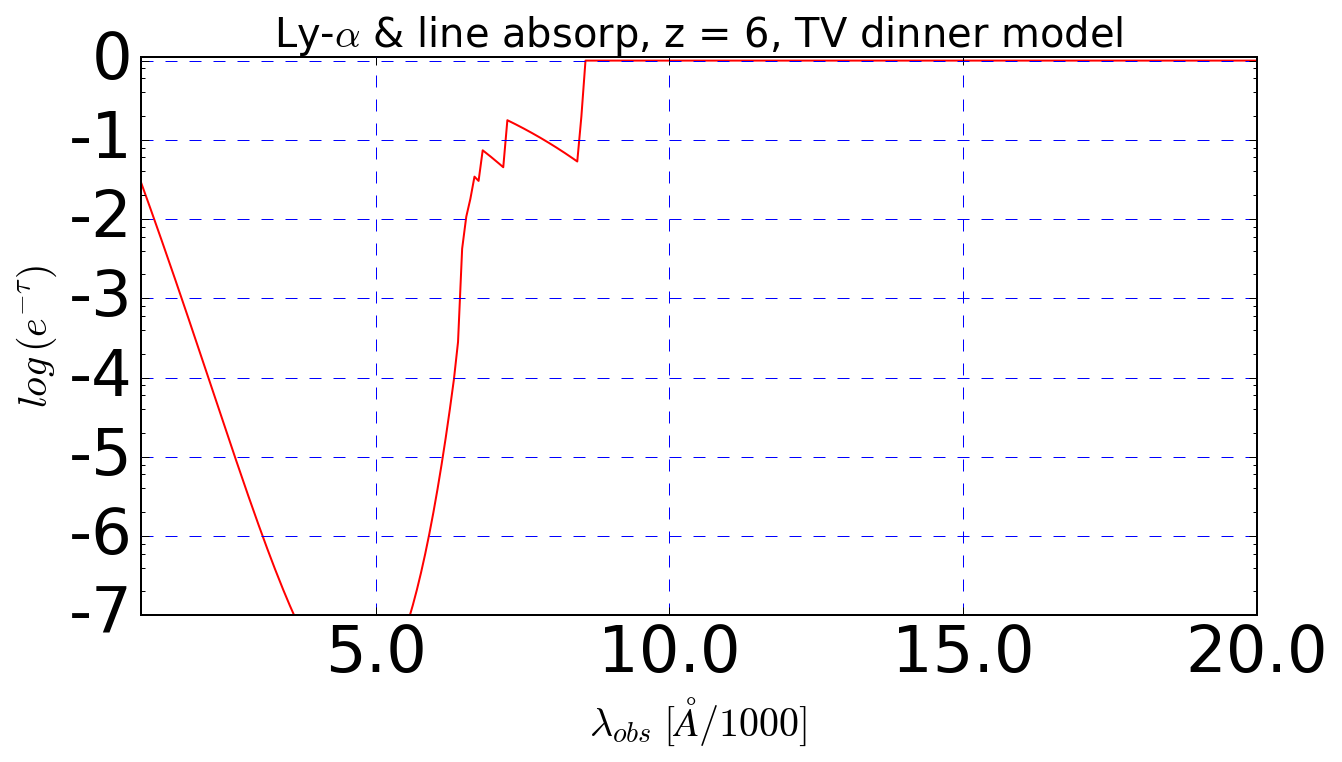

In [85]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim([1e3,2e4])
ax.set_ylim([0,1.1])
ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_ylabel(r'$log\, (e^{-\tau})$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp, z = 6, TV dinner model',size=labelsize)

ax.plot(rsBC03_500ky_wl, lyA.lyTau(6.0)(rsBC03_500ky_wl),'r-') ## CHECK - entry 1 is 500 kyr


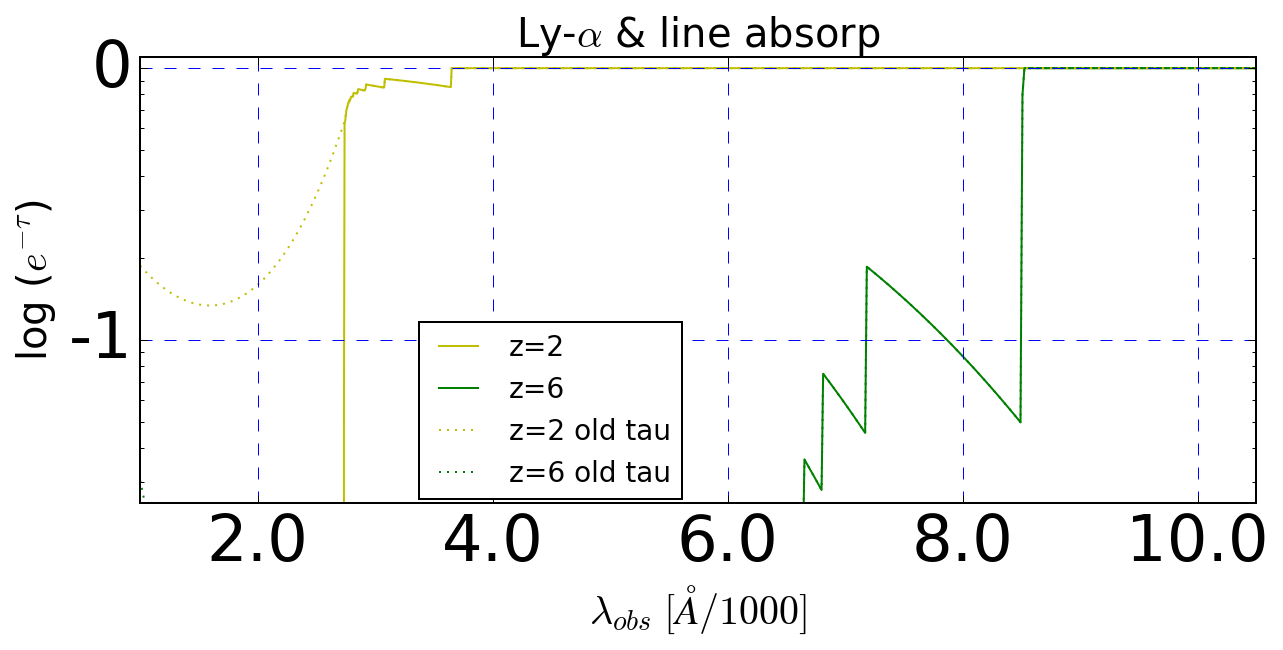

In [102]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.0,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'y-',
        lamRange,lyA.lyTauC(6.0)(lamRange),'g-',
        lamRange,lyA.lyTau(2.0)(lamRange),'y:',
        lamRange,lyA.lyTau(6.0)(lamRange),'g:',
        )
ax.set_yscale('log')
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1000,10500])
ax.set_ylim([2.5e-2,1.1])
# ax.set_xticks([3e3,4e3,5e3,6e3,7e3,8e3])

ax.set_ylabel(r'log ($e^{-\tau}$)', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)
ax.legend(['z=2', 'z=6','z=2 old tau','z=6 old tau'],
              loc=(0.25,0.01), fontsize=14 )


In [131]:
import importlib
importlib.reload(lyA)
importlib.reload(lf)

<module 'loadfilt' from '/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules/loadfilt.py'>

12790

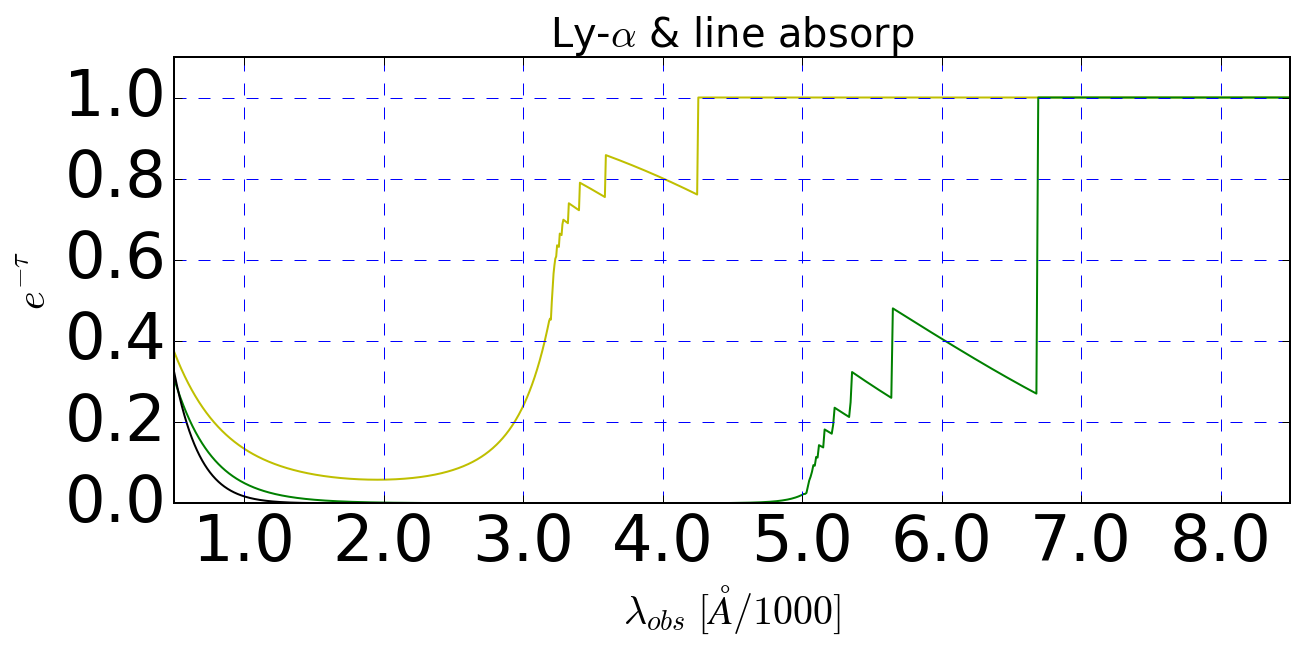

In [104]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.0,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.5)(lamRange),'y-',
        lamRange,lyA.lyTauC(4.5)(lamRange),'g-',
        lamRange,lyA.lyTauC(8.5)(lamRange),'k-')

ax.set_xlim([500,8500])
ax.set_ylim([1e-9,1.1])

ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)
gc.collect()

In [119]:
BC03_seth_ages

array([  1.25900000e+05,   5.01200000e+05,   1.00000000e+06,   1.99500000e+06,   3.98100000e+06,
         5.01200000e+06,   7.94300000e+06,   1.00000000e+07,   1.31800000e+07,   1.51400000e+07,
         1.99500000e+07,   2.51200000e+07,   3.00000000e+07,   4.75000000e+07,   5.00000000e+07,
         1.01500000e+08,   1.01500000e+08,   2.02600000e+08,   5.08800000e+08,   5.08800000e+08,
         7.18700000e+08,   7.18700000e+08])

In [120]:
rsBC03_100ky_wl, rsBC03_100ky_LperA = lyA.rsSEDwavelen(BC03_seth[0][:,0],BC03_seth[0][:,1],2)
rsBC03_500ky_wl, rsBC03_500ky_LperA = lyA.rsSEDwavelen(BC03_seth[1][:,0],BC03_seth[1][:,1],2)
rsBC03_1my_wl, rsBC03_1my_LperA     = lyA.rsSEDwavelen(BC03_seth[2][:,0],BC03_seth[2][:,1],2)
rsBC03_2my_wl, rsBC03_2my_LperA     = lyA.rsSEDwavelen(BC03_seth[3][:,0],BC03_seth[3][:,1],2)
rsBC03_4my_wl, rsBC03_4my_LperA     = lyA.rsSEDwavelen(BC03_seth[4][:,0],BC03_seth[4][:,1],2)
rsBC03_10my_wl, rsBC03_10my_LperA   = lyA.rsSEDwavelen(BC03_seth[7][:,0],BC03_seth[7][:,1],2)
rsBC03_50my_wl, rsBC03_50my_LperA   = lyA.rsSEDwavelen(BC03_seth[14][:,0],BC03_seth[14][:,1],2)

rsBC03_200my_wl, rsBC03_200my_LperA   = lyA.rsSEDwavelen(BC03_seth[17][:,0],BC03_seth[17][:,1],2)


24498

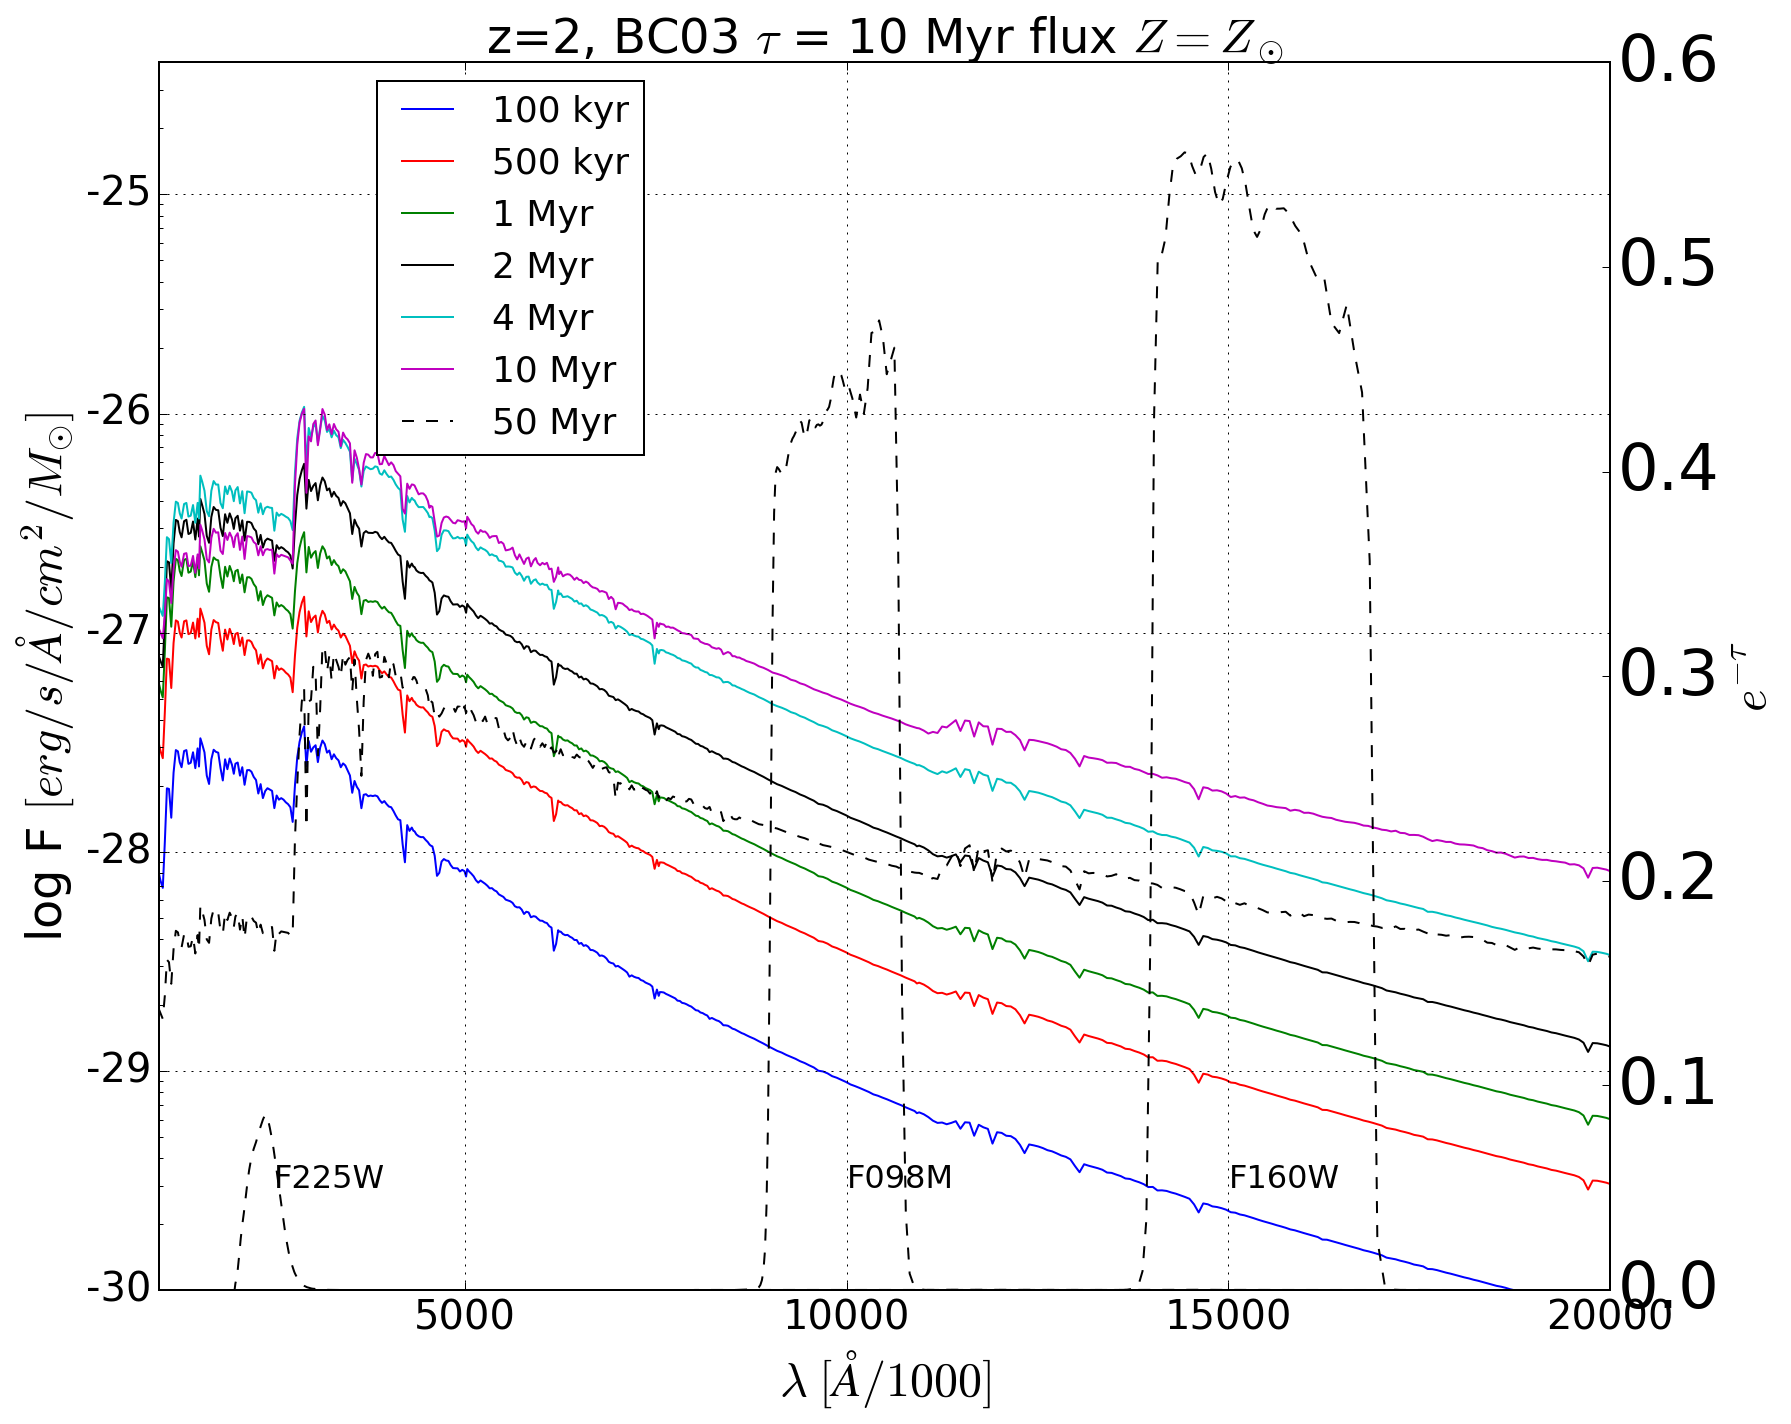

In [121]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA,'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e3,2e4])
ax.set_ylim([1e-30,4e-25])

ax2 = ax.twinx()
ax2.set_xlim([1e3,2e4])
ax2.set_ylim([0,0.6])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F160W', xy=(15000, 0), xytext=(15000,0.05),size=16)
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.05),size=16)
ax2.annotate('F098M', xy=(10000, 0), xytext=(10000,0.05),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.15,0.68), fontsize=18 )

ax.set_title(r'z=2 NO absorption, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

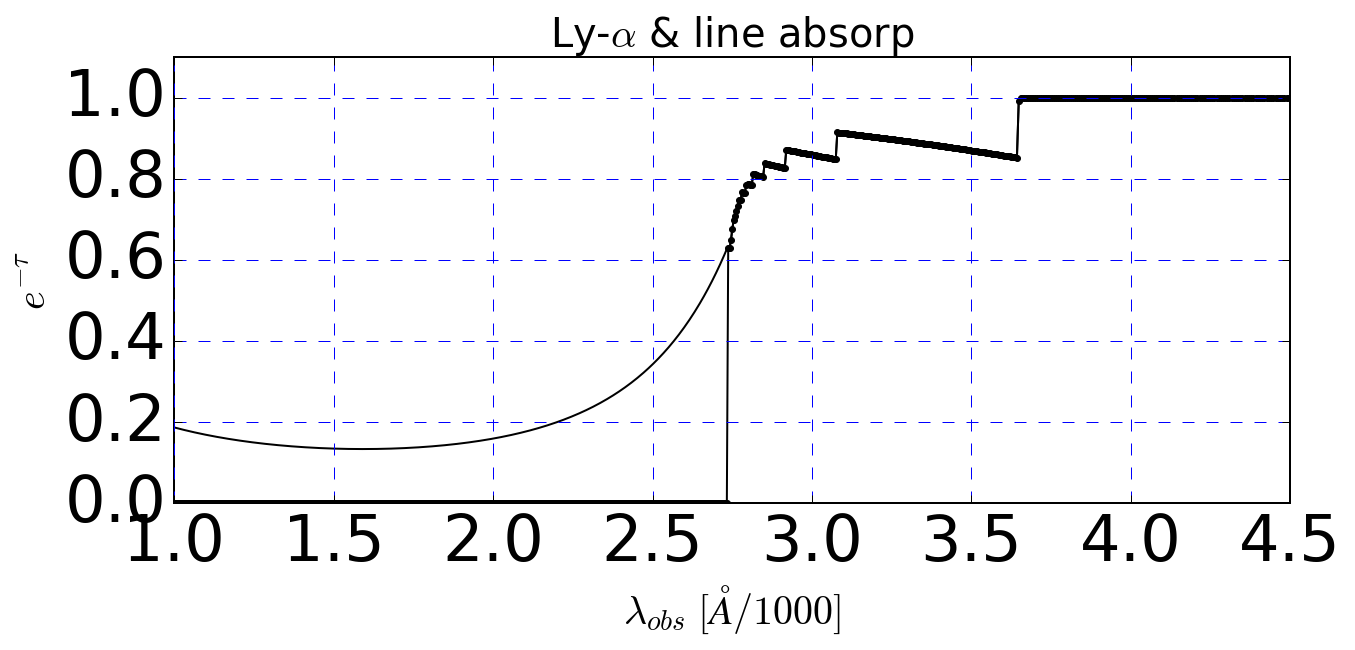

In [44]:
import importlib
importlib.reload(lyA)
importlib.reload(lf)


fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTau(2.0)(lamRange),'k-')
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'k.-')
ax.set_xlim([1000,4500])
ax.set_ylim([1e-9,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


30743

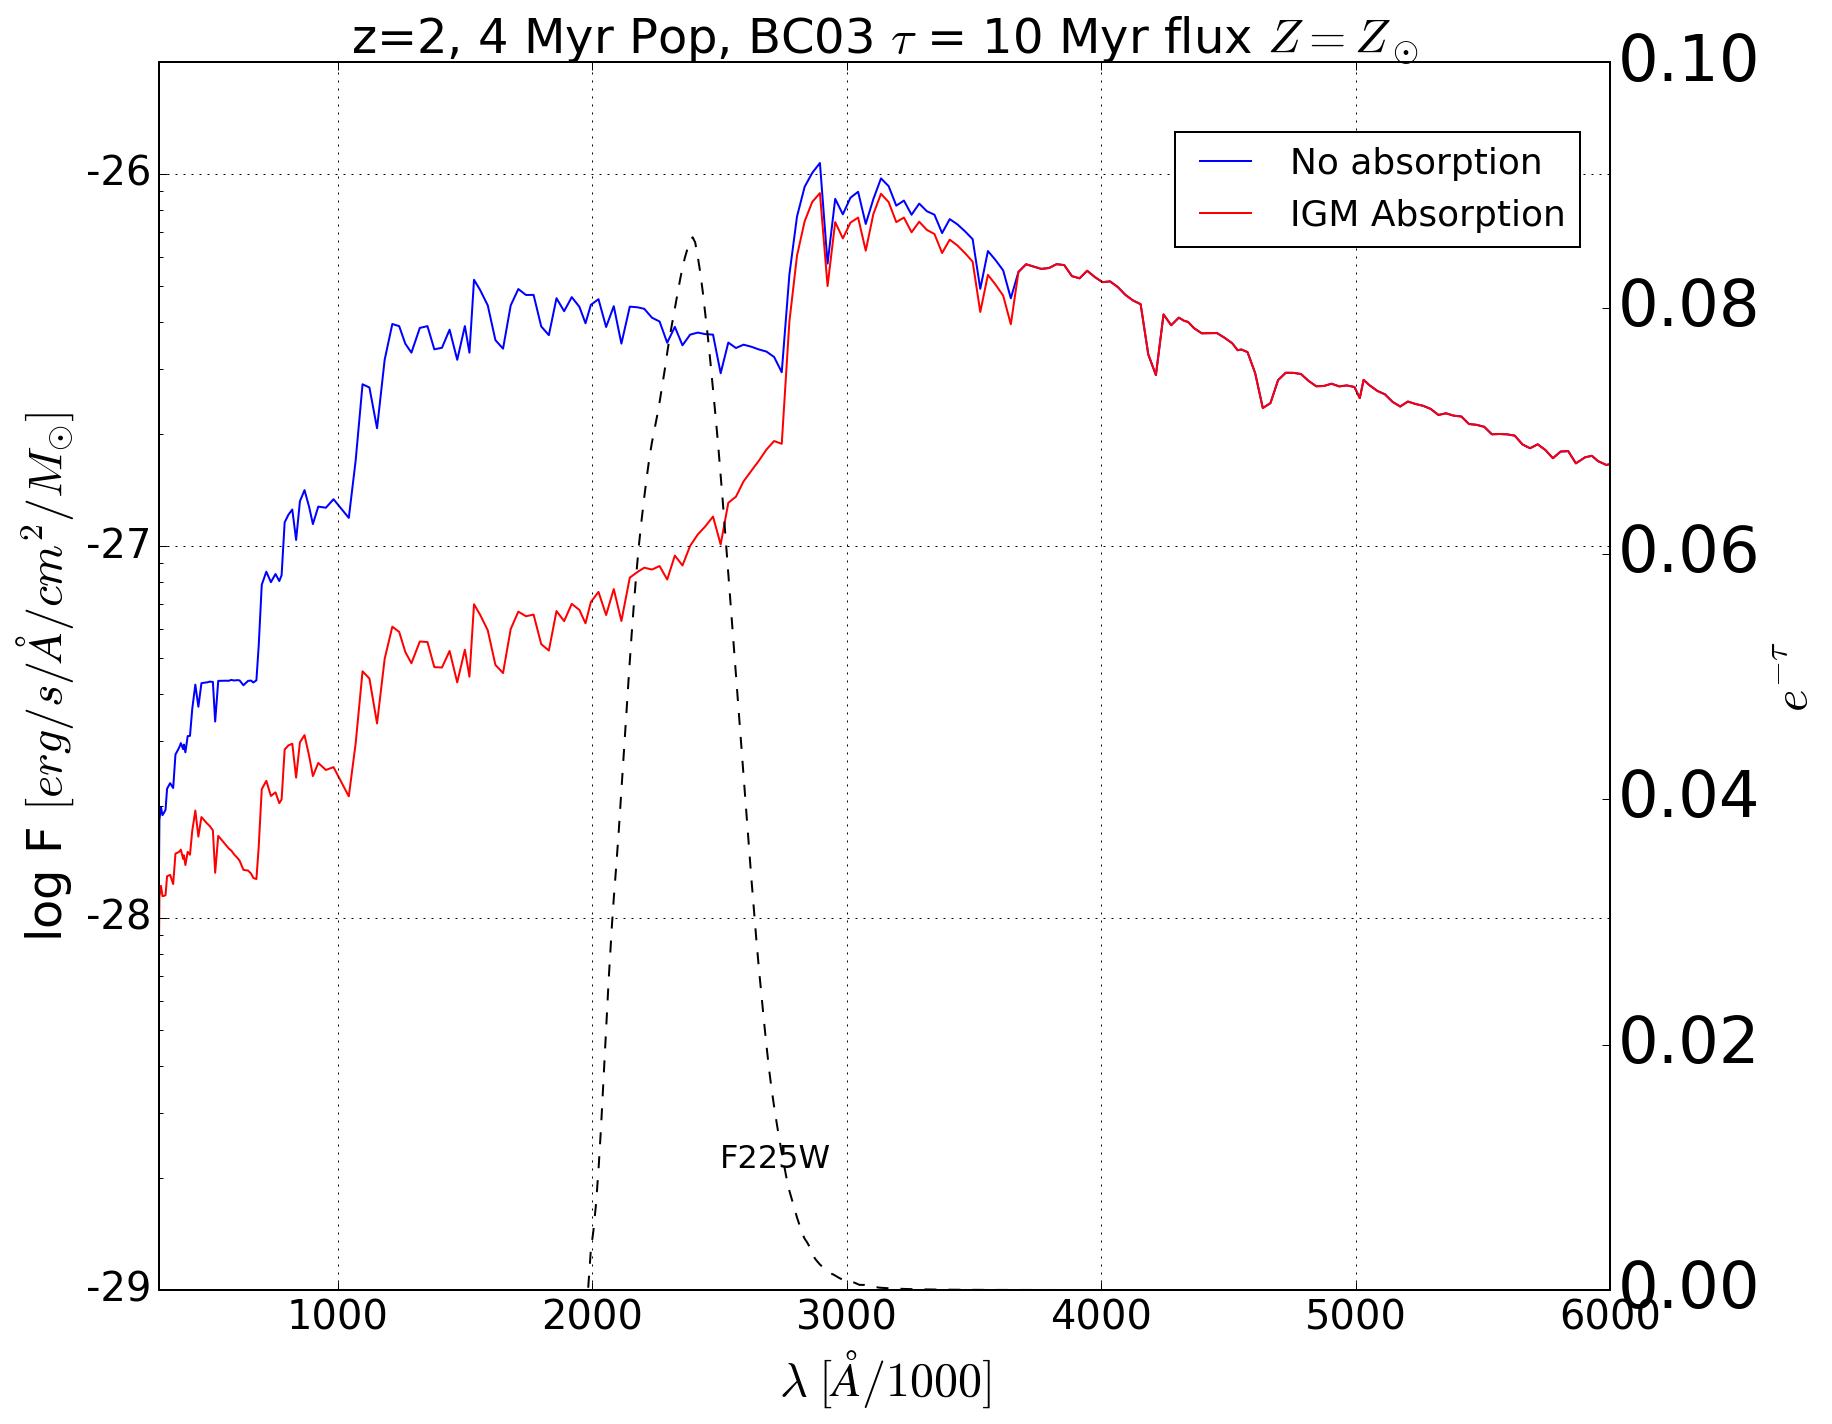

In [123]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA*lyA.lyTauC(2.0)(rsBC03_4my_wl),'r--') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA*lyA.lyTau(2.0)(rsBC03_4my_wl),'g:') ## CHECK - entry 0 is 100 kyr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([3e2,6e3])
ax.set_ylim([1e-29,2e-26])

ax2 = ax.twinx()
ax2.set_xlim([3e2,6e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.01),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['No absorption', 'New IGM Absorption','Orig IGM Absorption'],
              loc=(0.7,0.85), fontsize=18 )

ax.set_title(r'z=2, 4 Myr Pop, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

24224

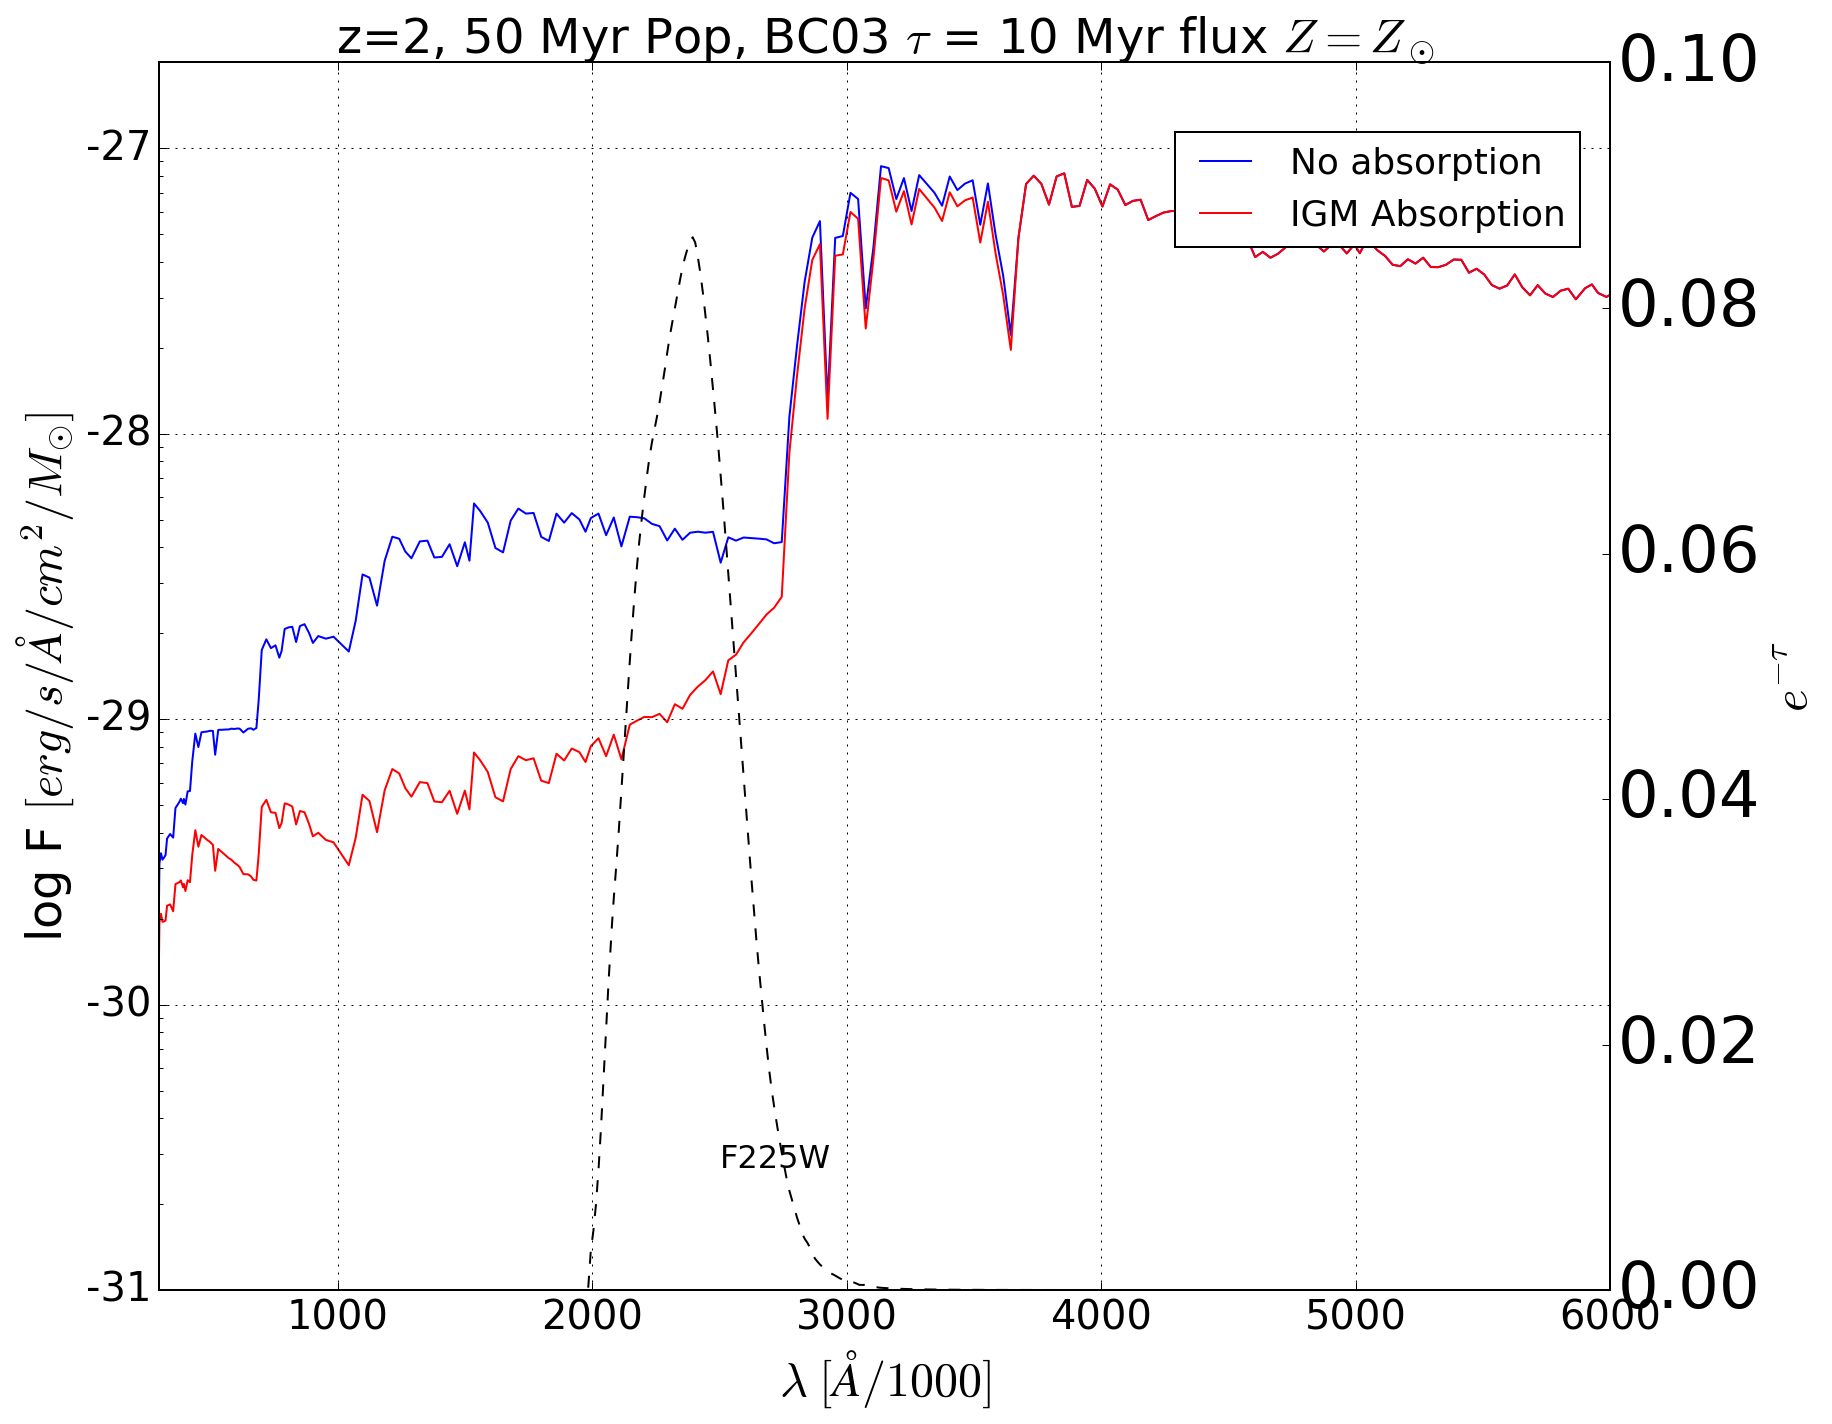

In [220]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA*lyA.lyTauC(2.0)(rsBC03_50my_wl),'r--') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA*lyA.lyTau(2.0)(rsBC03_50my_wl),'g:') ## CHECK - entry 0 is 100 kyr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([3e2,6e3])
ax.set_ylim([1e-31,2e-27])

ax2 = ax.twinx()
ax2.set_xlim([3e2,6e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.01),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['No absorption', 'New IGM Absorption','Orig IGM Absorption'],
              loc=(0.7,0.85), fontsize=18 )

ax.set_title(r'z=2, 50 Myr Pop, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

22265

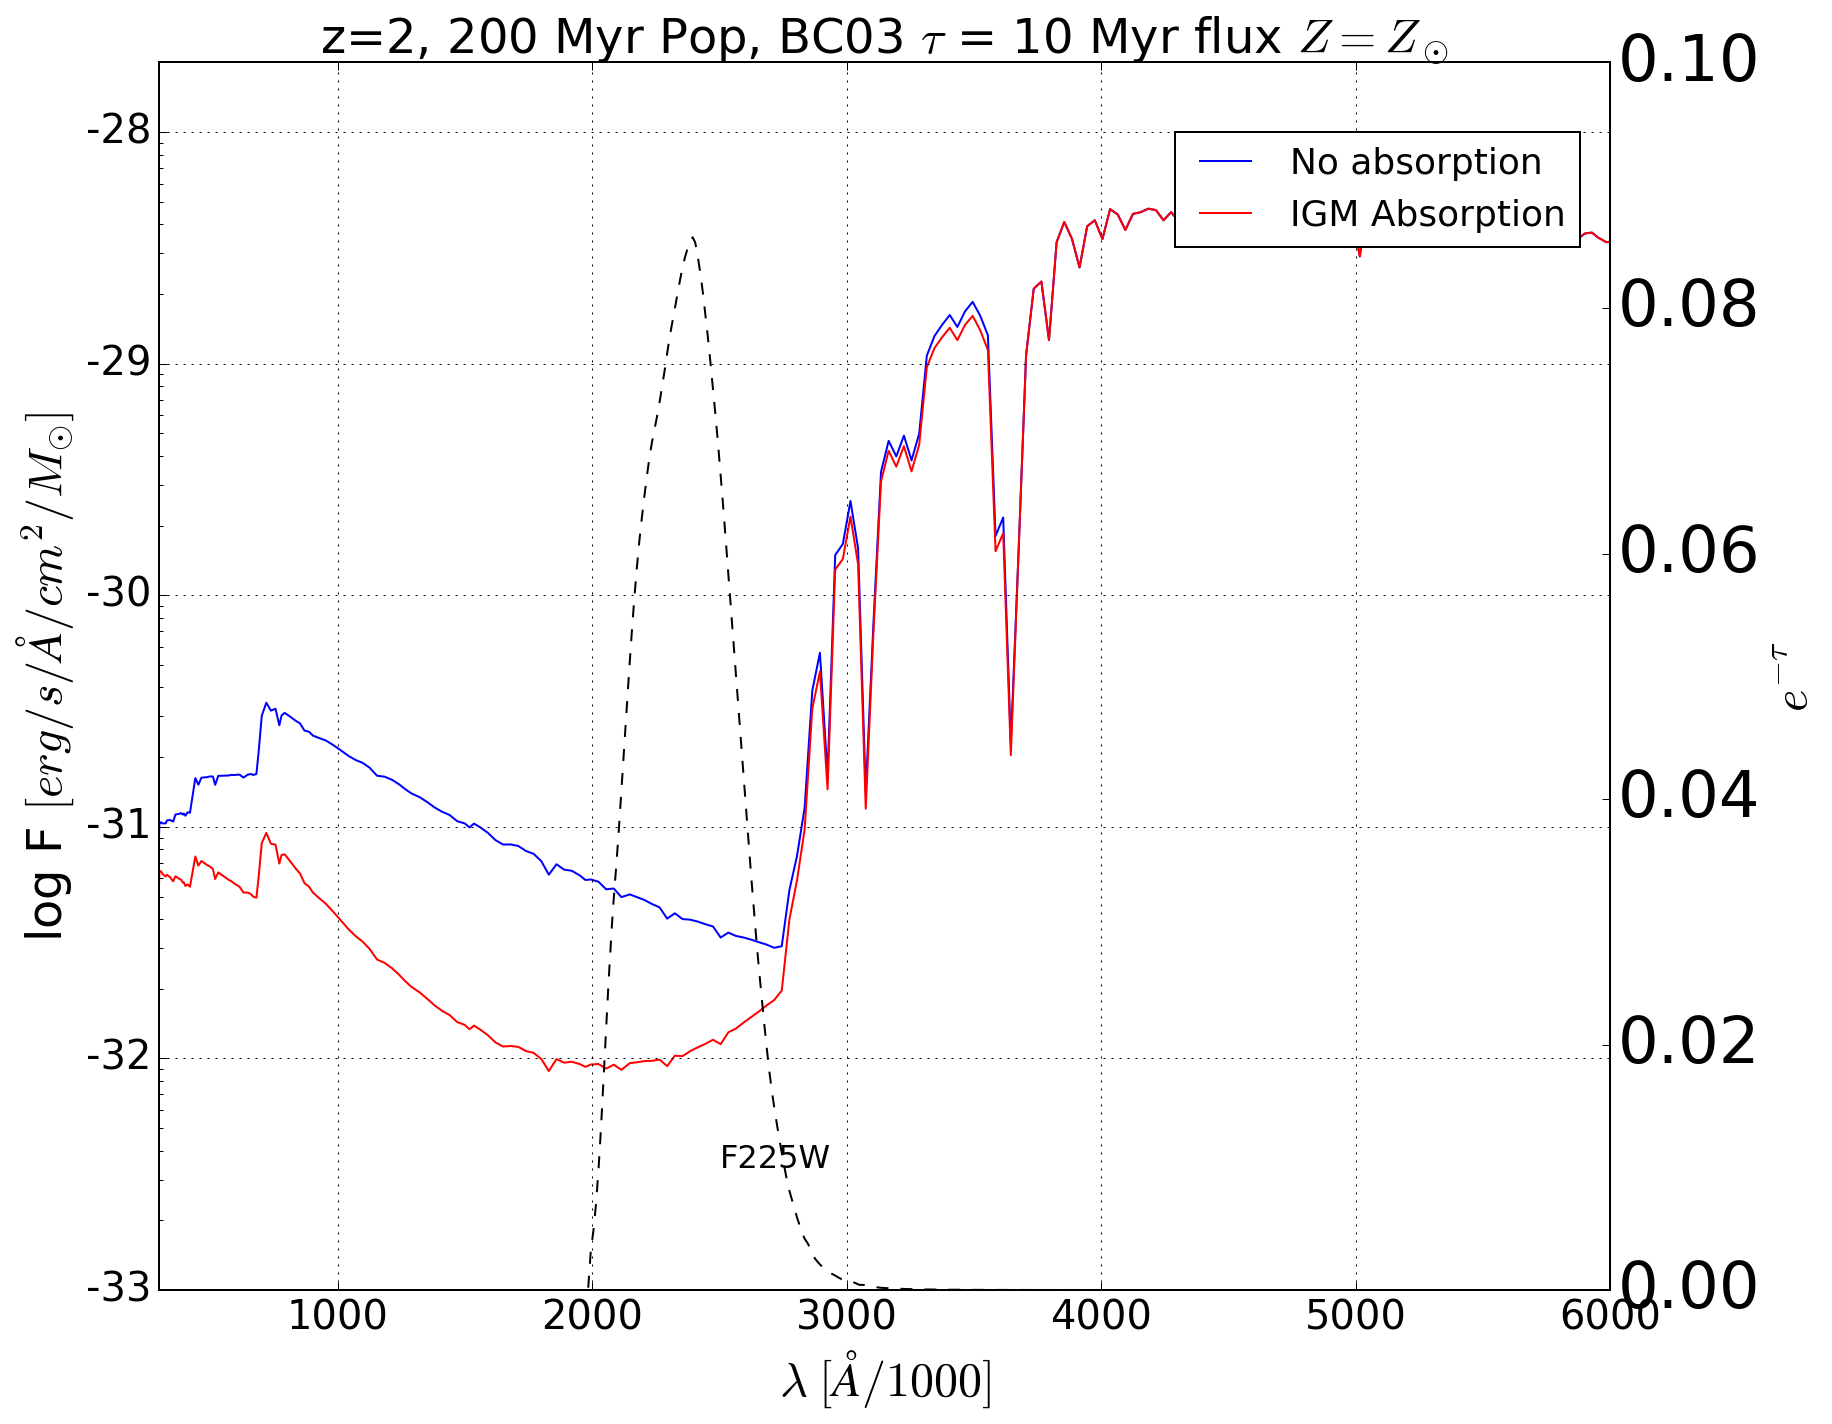

In [221]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_200my_wl, rsBC03_200my_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_200my_wl, rsBC03_200my_LperA*lyA.lyTau(2.0)(rsBC03_200my_wl),'r-') ## CHECK - entry 0 is 100 kyr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([3e2,6e3])
ax.set_ylim([1e-33,2e-28])

ax2 = ax.twinx()
ax2.set_xlim([3e2,6e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.01),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend(['No absorption', 'IGM Absorption'],
              loc=(0.7,0.85), fontsize=18 )

ax.set_title(r'z=2, 200 Myr Pop, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

In [138]:
rsBC03_100ky_f, rsBC03_100ky_LperHz  = lyA.AtoHz(rsBC03_100ky_wl, rsBC03_100ky_LperA)
rsBC03_500ky_f, rsBC03_500ky_LperHz  = lyA.AtoHz(rsBC03_500ky_wl, rsBC03_500ky_LperA)
rsBC03_1my_f, rsBC03_1my_LperHz      = lyA.AtoHz(rsBC03_1my_wl, rsBC03_1my_LperA)
rsBC03_2my_f, rsBC03_2my_LperHz      = lyA.AtoHz(rsBC03_2my_wl, rsBC03_2my_LperA)
rsBC03_4my_f, rsBC03_4my_LperHz      = lyA.AtoHz(rsBC03_4my_wl, rsBC03_4my_LperA)
rsBC03_10my_f, rsBC03_10my_LperHz    = lyA.AtoHz(rsBC03_10my_wl, rsBC03_10my_LperA)
rsBC03_50my_f, rsBC03_50my_LperHz    = lyA.AtoHz(rsBC03_50my_wl, rsBC03_50my_LperA)

freqRange = (BC03_seth[0][:,0] * u.Angstrom).to(u.Hz, equivalencies=u.spectral())[::-1]


11140

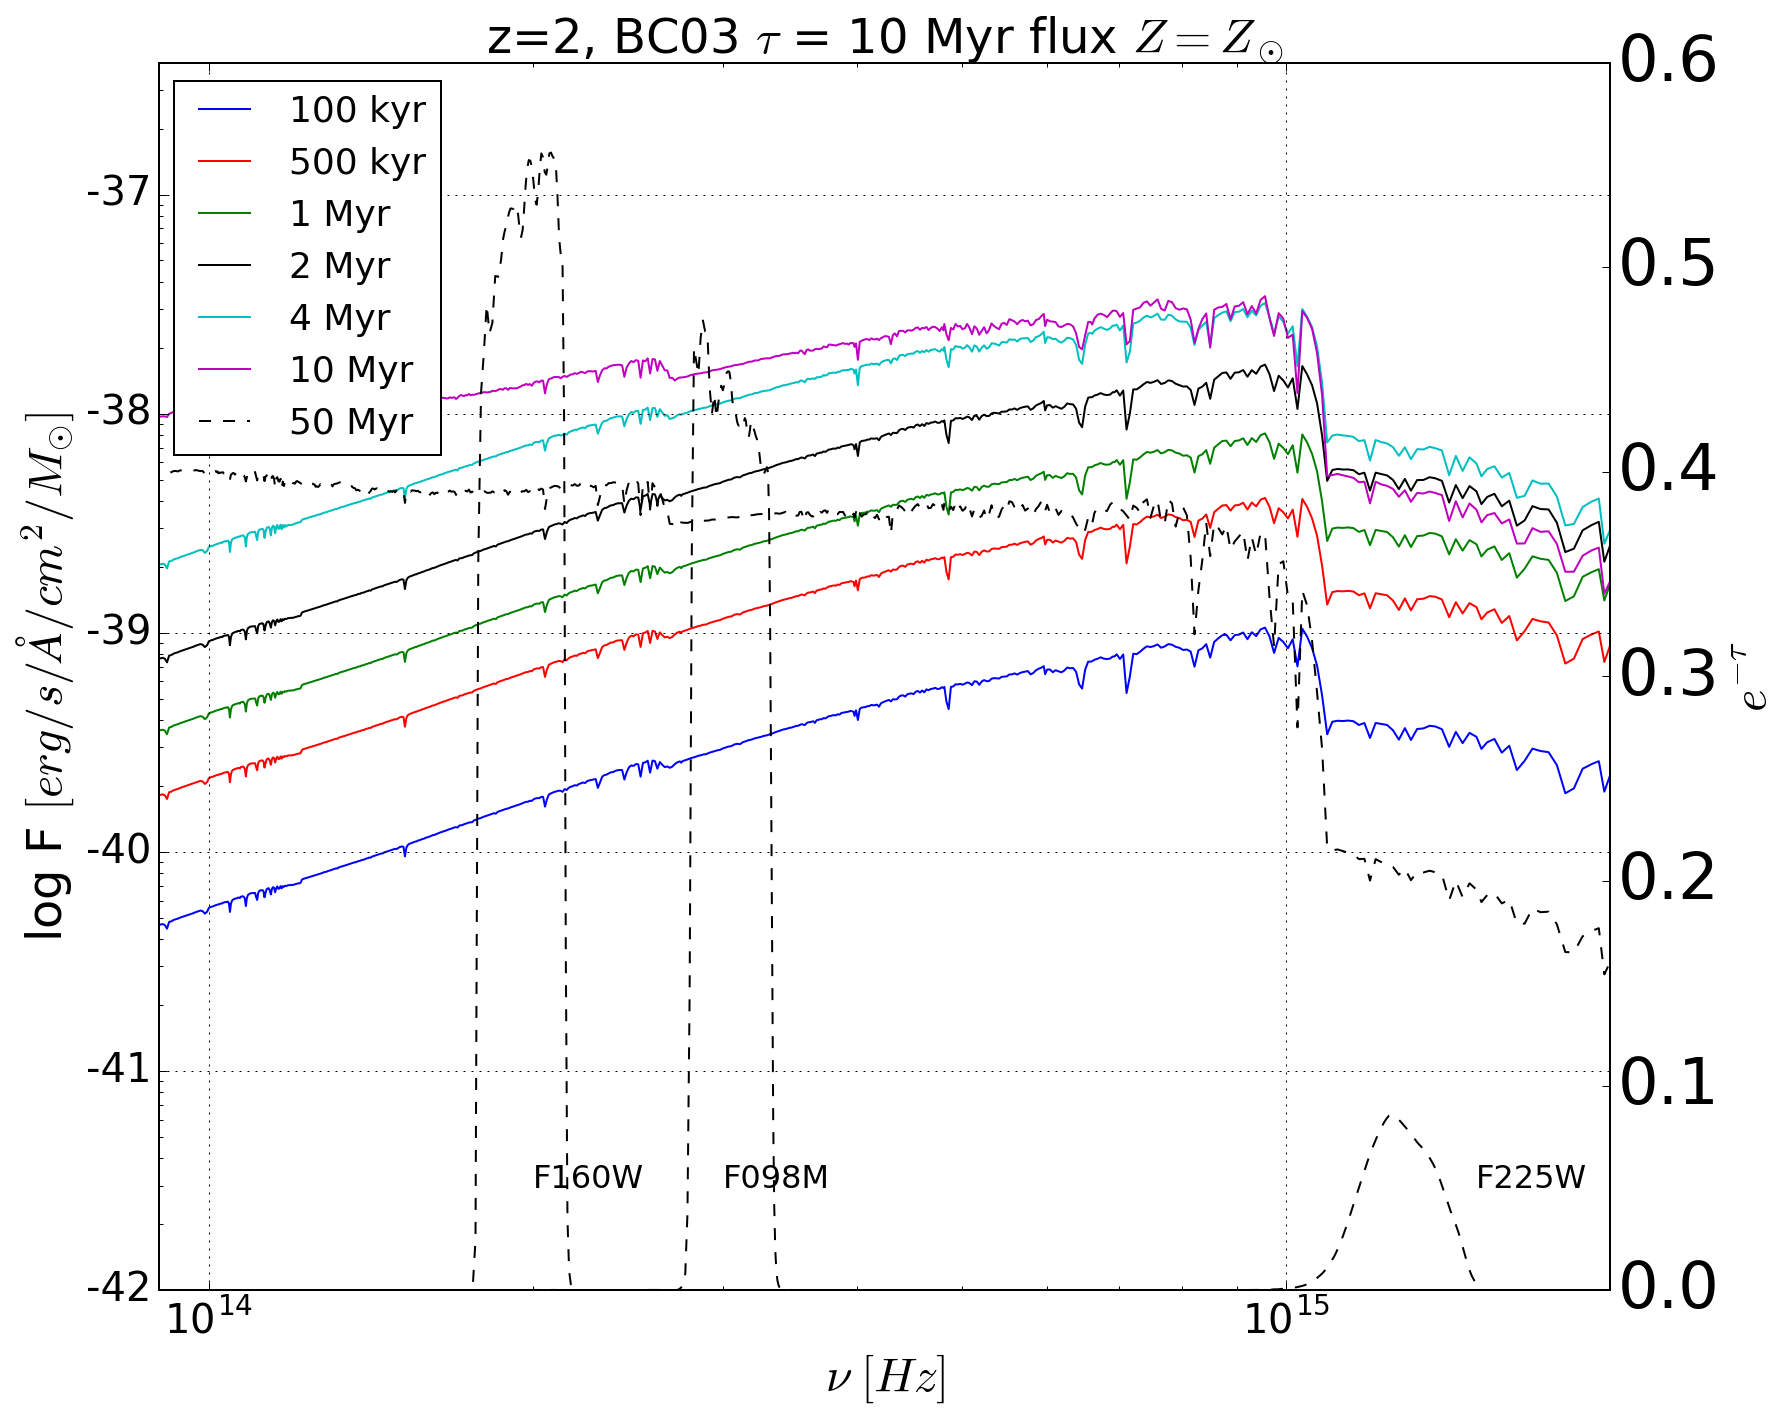

In [139]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_f, rsBC03_100ky_LperHz,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_f, rsBC03_500ky_LperHz,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_f, rsBC03_1my_LperHz,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_f, rsBC03_2my_LperHz,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_f, rsBC03_4my_LperHz,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_f, rsBC03_10my_LperHz,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_f, rsBC03_50my_LperHz,'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([0.9e14,2e15])
ax.set_ylim([1e-42,4e-37])

ax2 = ax.twinx()
ax2.set_xlim([0.9e14,2e15])
ax2.set_ylim([0,0.6])
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(freqRange,hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
ax2.plot(freqRange,hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
ax2.plot(freqRange,hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
ax2.annotate('F160W', xy=(2e14, 0), xytext=(2e14,0.05),size=16)
ax2.annotate('F225W', xy=(1.5e15, 0), xytext=(1.5e15,0.05),size=16)
ax2.annotate('F098M', xy=(3e14, 0), xytext=(3e14,0.05),size=16)

ax.set_xlabel(r'$\nu\; [Hz]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.01,0.68), fontsize=18 )

ax.set_title(r'z=2, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

29436

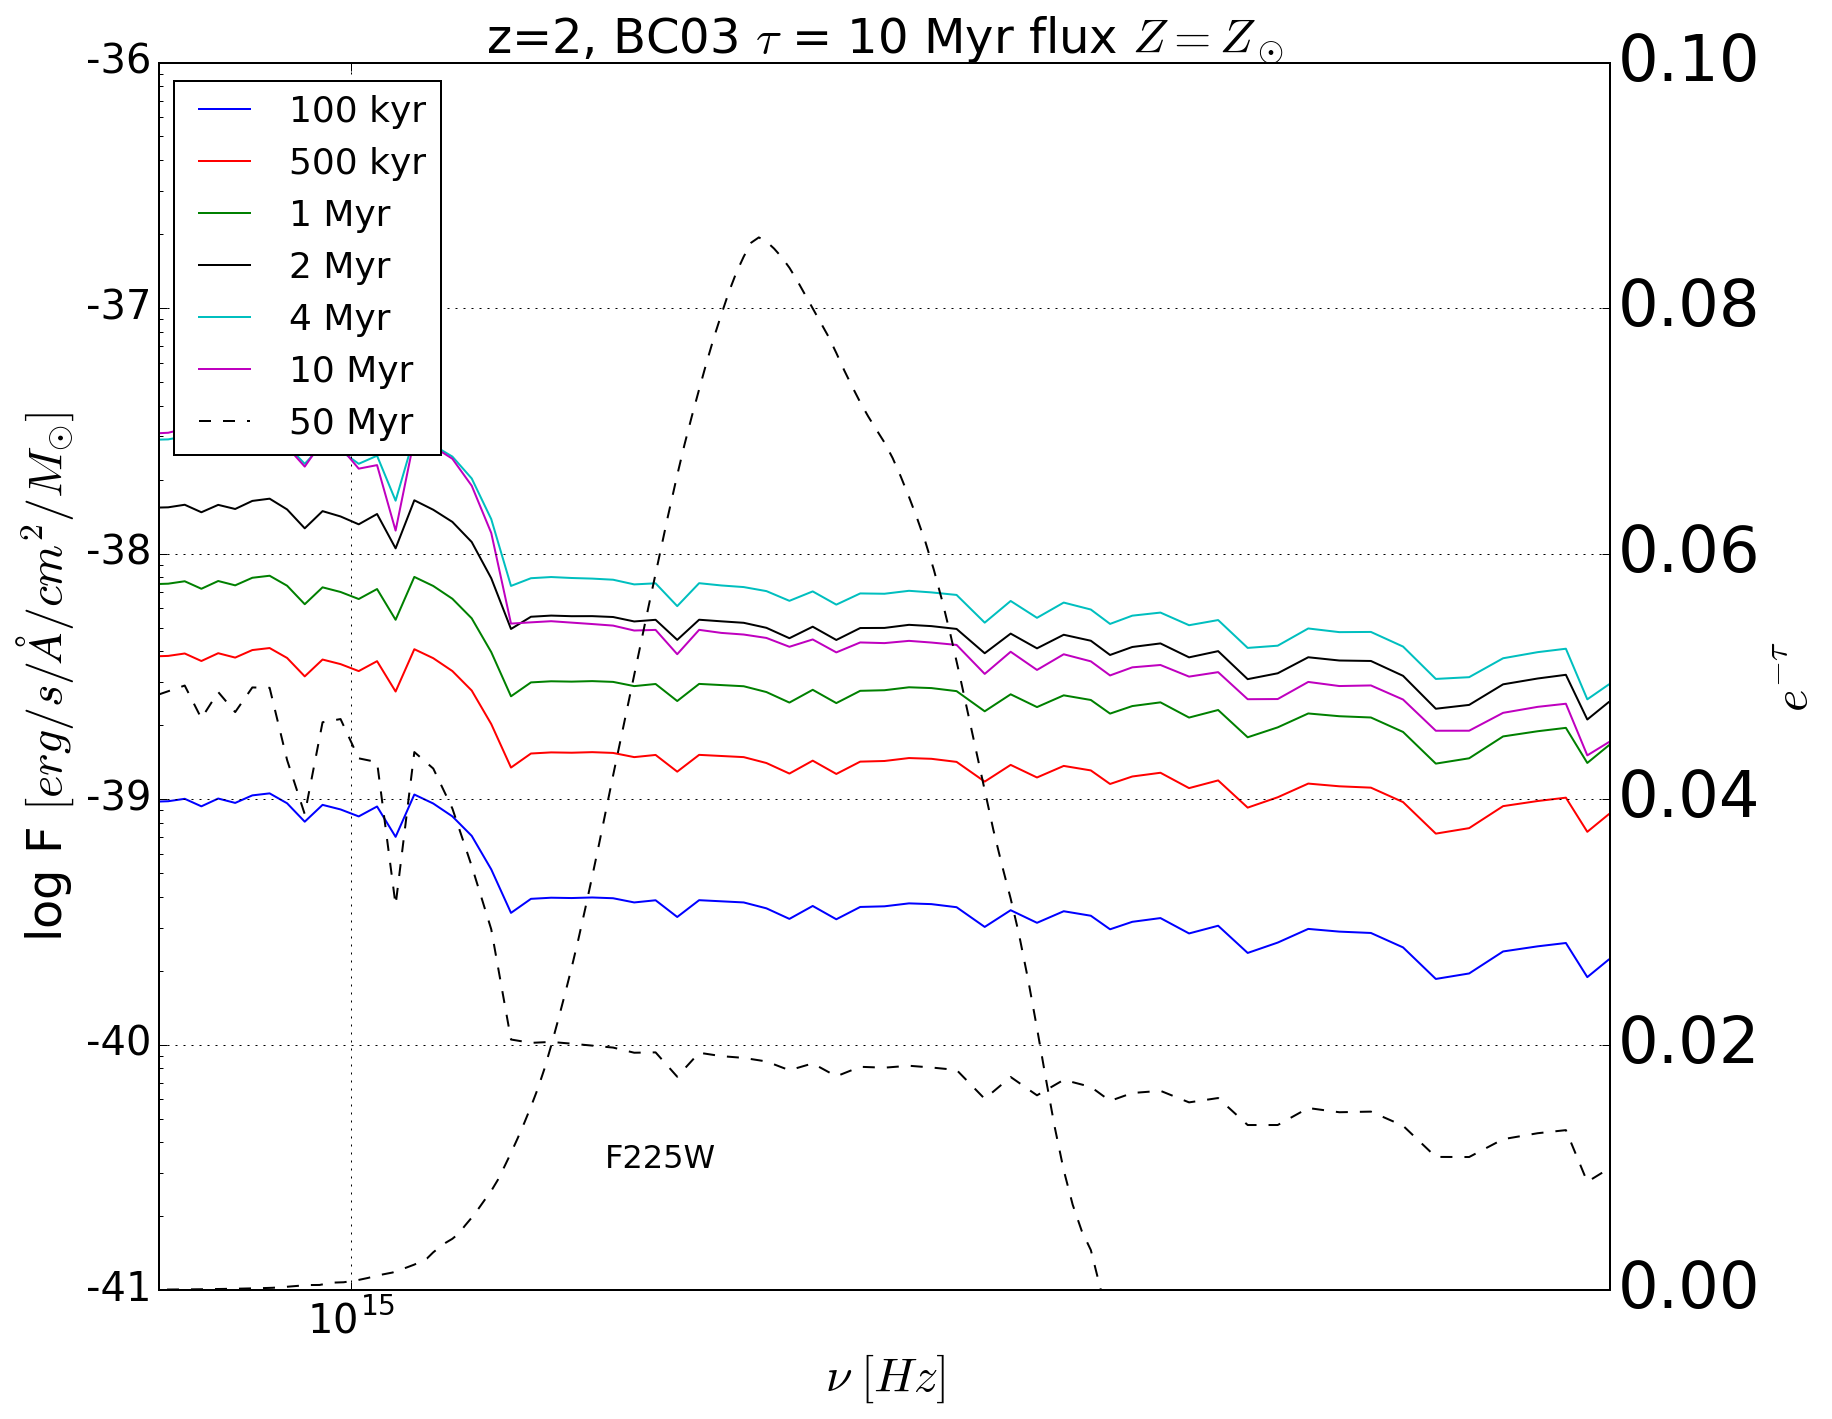

In [23]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_f, rsBC03_100ky_LperHz,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_f, rsBC03_500ky_LperHz,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_f, rsBC03_1my_LperHz,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_f, rsBC03_2my_LperHz,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_f, rsBC03_4my_LperHz,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_f, rsBC03_10my_LperHz,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_f, rsBC03_50my_LperHz,'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([9e14,2e15])
ax.set_ylim([1e-41,1e-36])

ax2 = ax.twinx()
ax2.set_xlim([9e14,2e15])
ax2.set_ylim([0,0.1])
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
# ax2.plot(freqRange,hubbleFilters['F160W_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
ax2.plot(freqRange,hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
# ax2.plot(freqRange,hubbleFilters['F098M_WFC3'](BC03_seth[0][:,0][::-1]),'k--')
# ax2.annotate('F160W', xy=(2e14, 0), xytext=(2e14,0.05),size=16)
ax2.annotate('F225W', xy=(1.15e15, 0), xytext=(1.15e15,0.01),size=16)
# ax2.annotate('F098M', xy=(3e14, 0), xytext=(3e14,0.05),size=16)

ax.set_xlabel(r'$\nu\; [Hz]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.01,0.68), fontsize=18 )

ax.set_title(r'z=2, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

28711

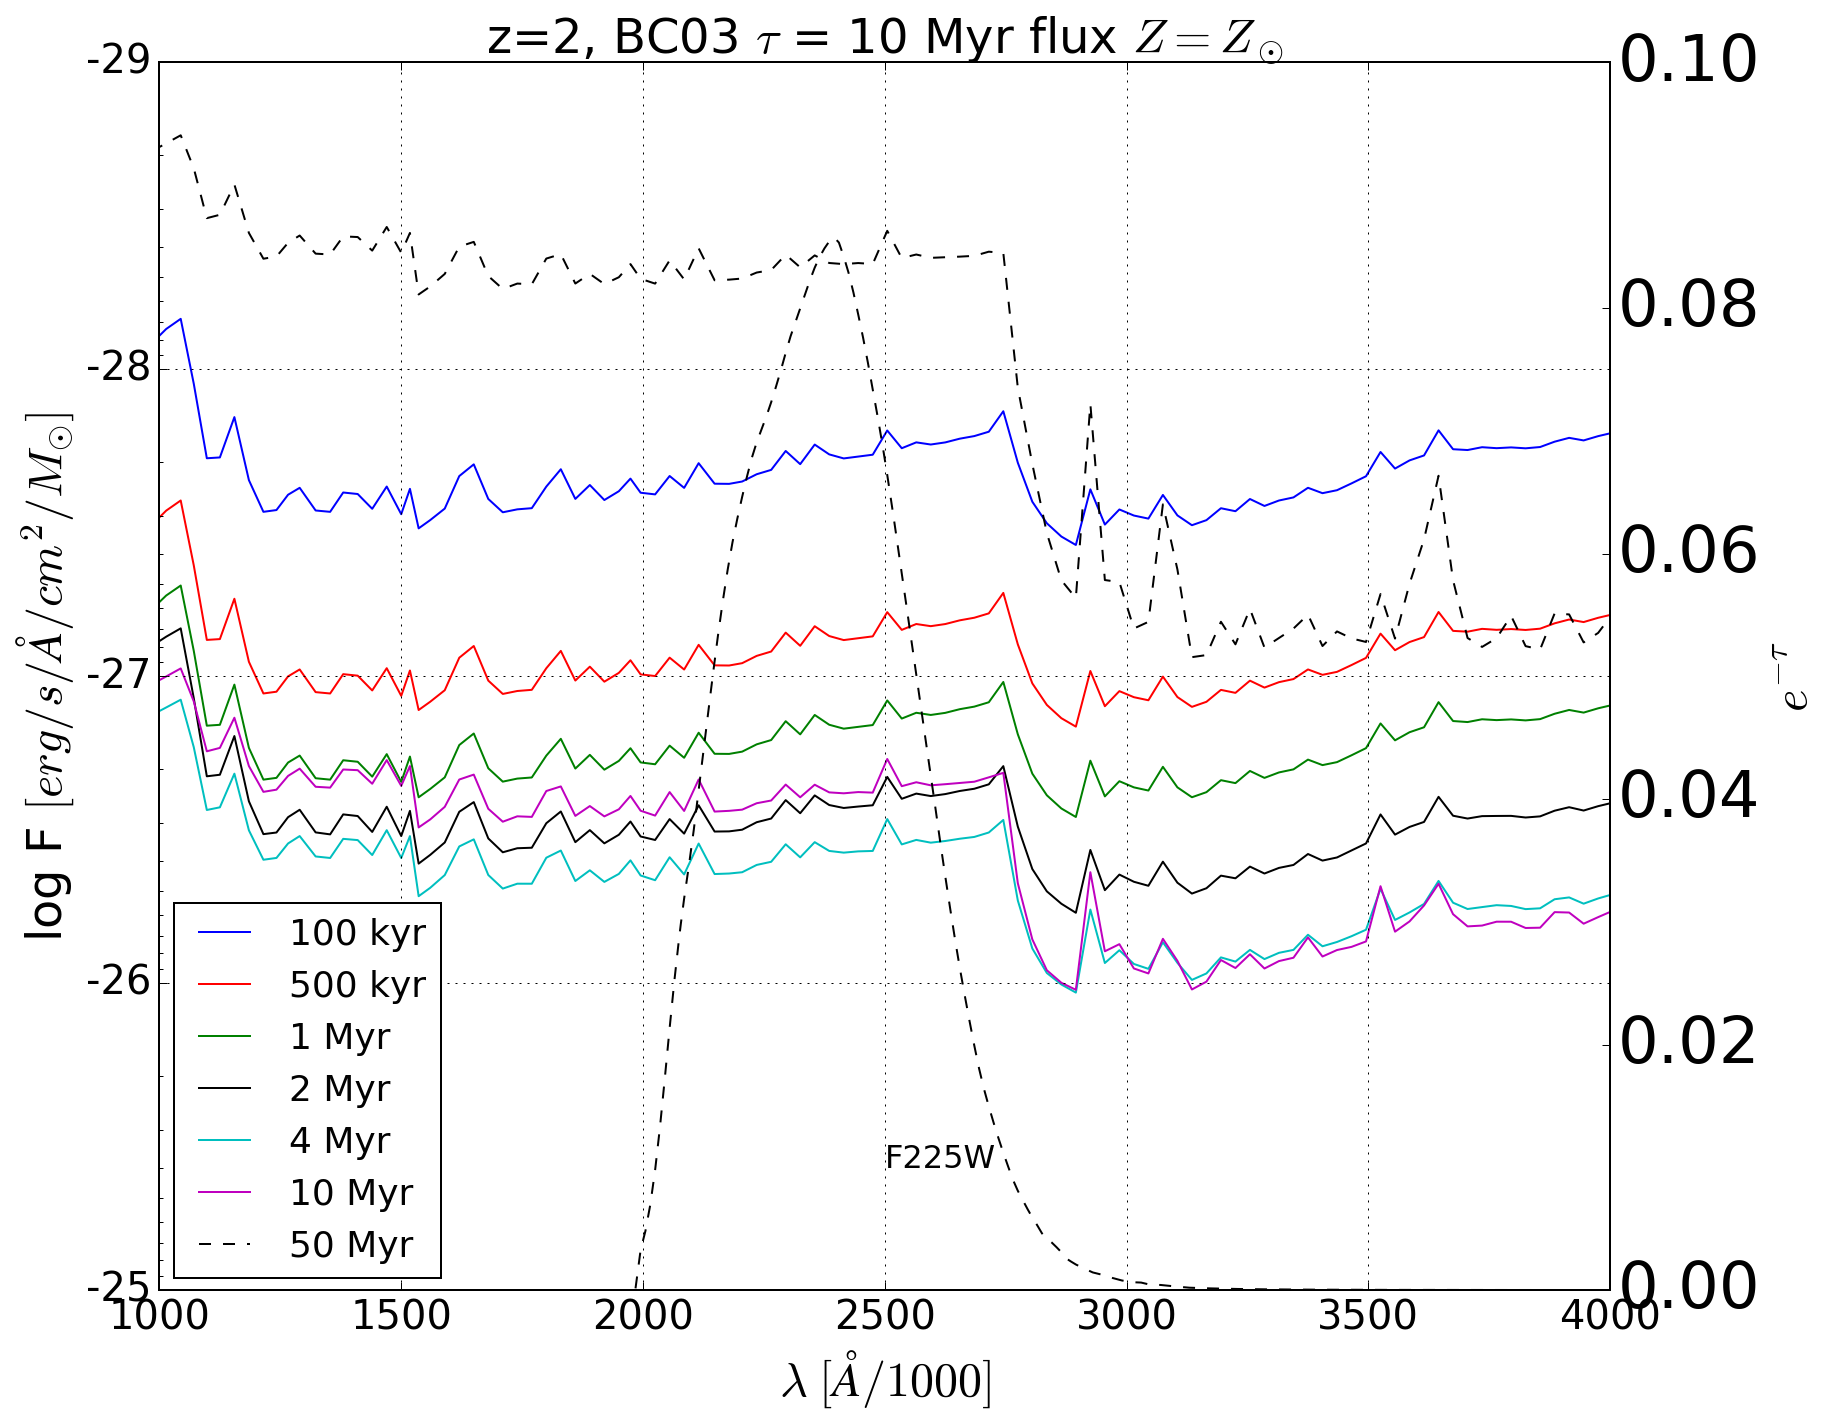

In [26]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA,'k--') ## CHECK - entry 14 is 50 Myr

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1000,4e3])
ax.set_ylim([1e-25,1e-29])

ax2 = ax.twinx()
ax2.set_xlim([1000,4e3])
ax2.set_ylim([0,0.1])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(BC03_seth[0][:,0],hubbleFilters['F225W_WFC3'](BC03_seth[0][:,0]),'k--')
ax2.annotate('F225W', xy=(2500, 0), xytext=(2500,0.01),size=16)

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log F $[erg/ s/ \AA/ cm^2/M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr','50 Myr'],
              loc=(0.01,0.01), fontsize=18 )

ax.set_title(r'z=2, BC03 $\tau$ = 10 Myr flux $Z = Z_\odot$', fontsize=24)
gc.collect()

11756

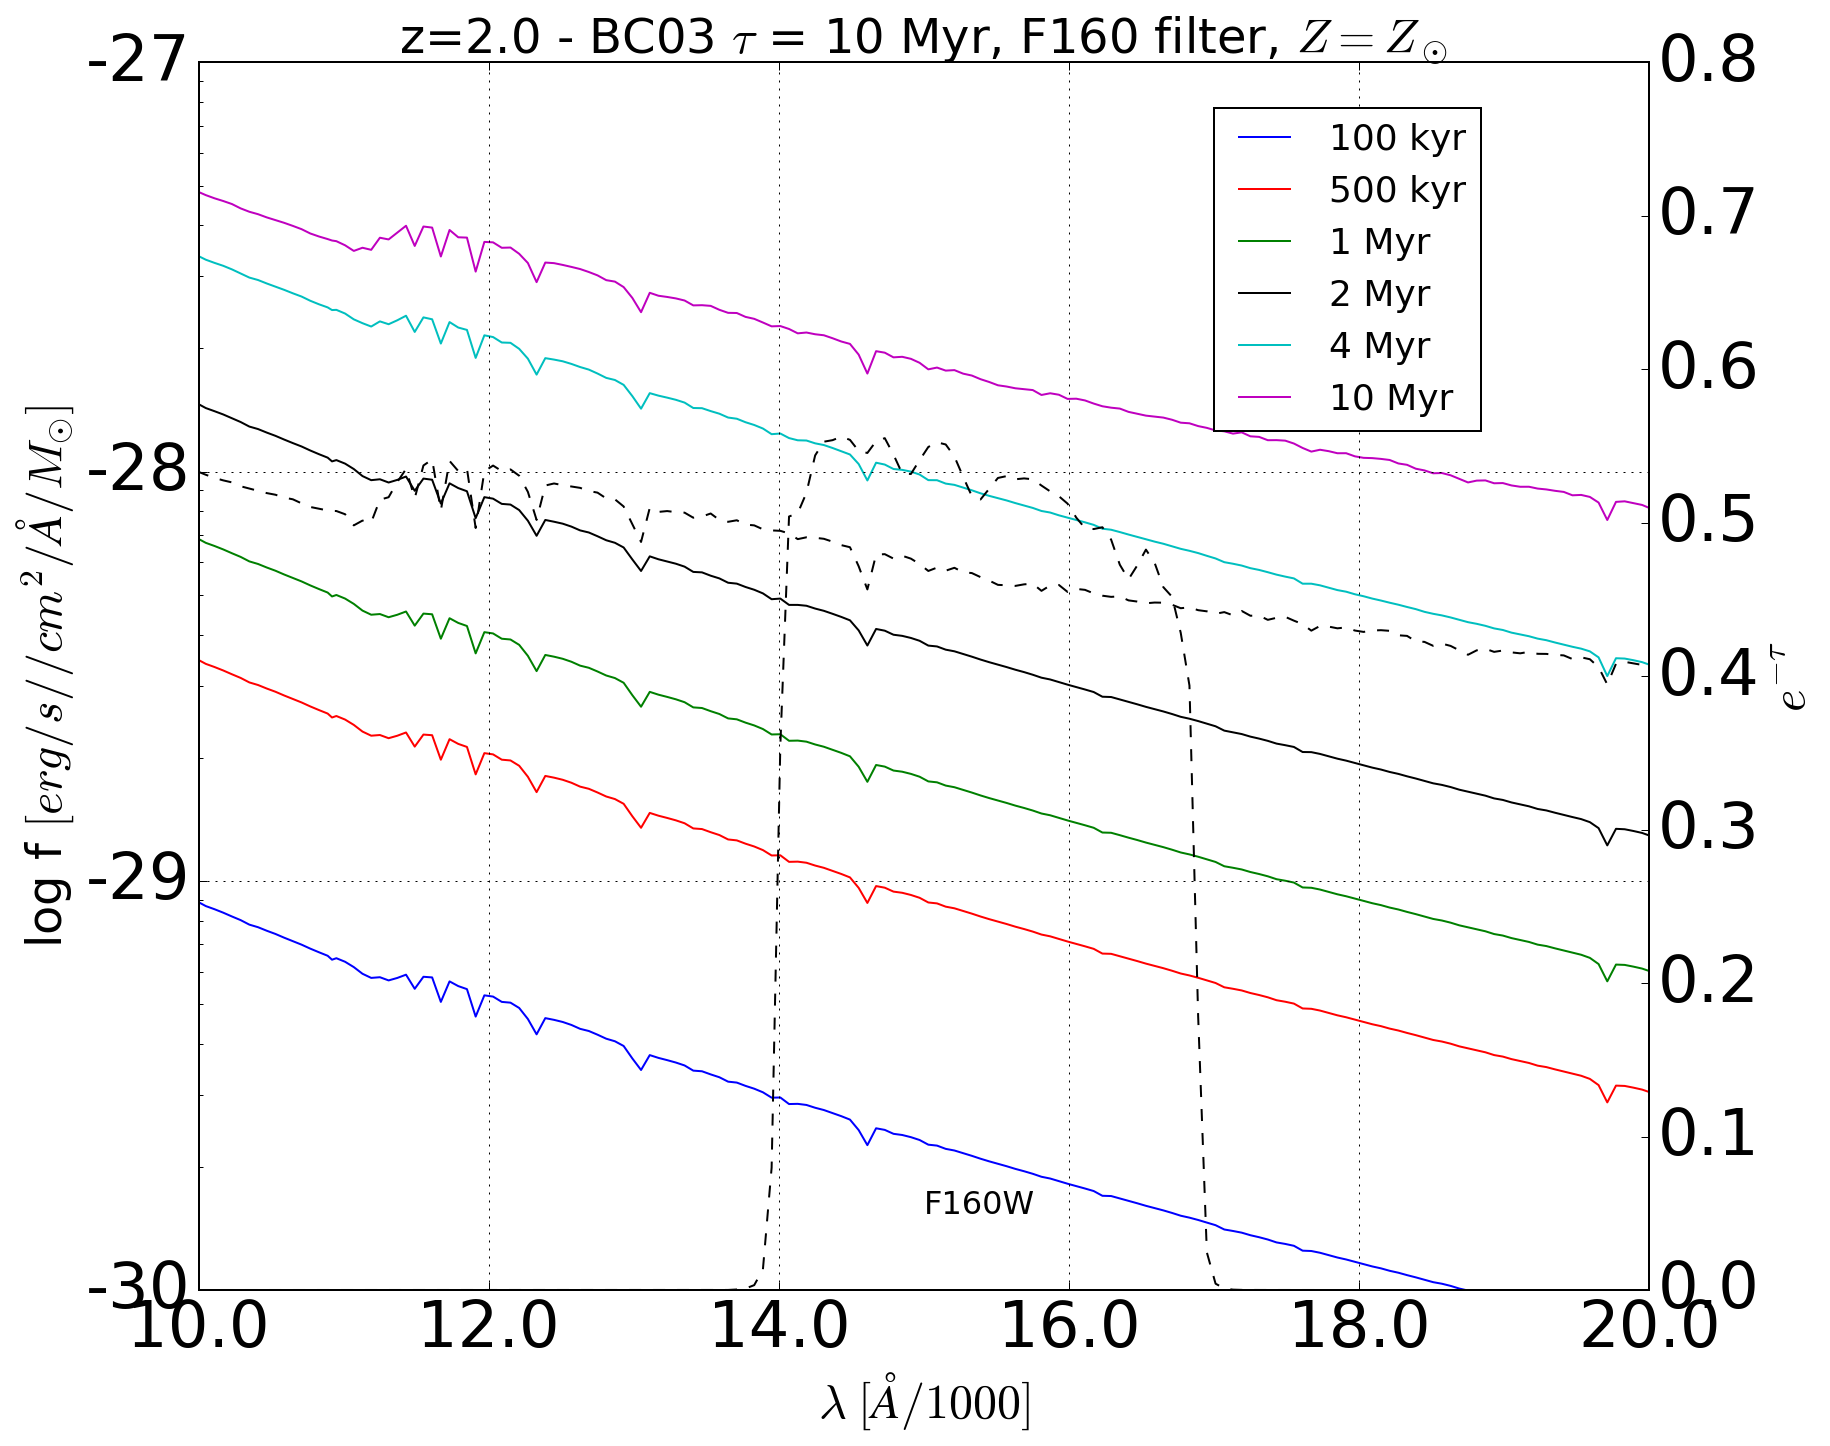

In [108]:
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03_100ky_wl, rsBC03_100ky_LperA,'b-') ## CHECK - entry 0 is 100 kyr
ax.plot(rsBC03_500ky_wl, rsBC03_500ky_LperA,'r-') ## CHECK - entry 1 is 500 kyr
ax.plot(rsBC03_1my_wl, rsBC03_1my_LperA,'g-') ## CHECK - entry 2 is 1   Myr
ax.plot(rsBC03_2my_wl, rsBC03_2my_LperA,'k-') ## CHECK - entry 3 is 2 Myr
ax.plot(rsBC03_4my_wl, rsBC03_4my_LperA,'c-') ## CHECK - entry 4 is 4 Myr
ax.plot(rsBC03_10my_wl, rsBC03_10my_LperA,'m-') ## CHECK - entry 7 is 10 Myr
ax.plot(rsBC03_50my_wl, rsBC03_50my_LperA,'k--') ## CHECK - entry 14 is 50 Myr

ax2 = ax.twinx()
ax2.set_xlim([1e4,2e4])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F160W_WFC3'](rsBC03ssp_100MyrWaveLn),'k--')
ax2.annotate('F160W', xy=(15000, 0), xytext=(15000,0.05),size=16)

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([10000,20000])
ax.set_ylim([1e-30,1e-27])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr'],
              loc=(0.7,0.7), fontsize=18 )

ax.set_title(r'z=2.0 - BC03 $\tau$ = 10 Myr, F160 filter, $Z = Z_\odot$', fontsize=24)
gc.collect()

In [406]:
np.log10(BC03_z2F160FluxSeth[4,1]) - np.log10(BC03_z2F160FluxSeth[0,1])

1.6264448717907385

In [407]:
BC03_z2F160FluxSeth[0,1]

1.6653029287437047e-40

# No star formation - BC03

In [408]:
# SETHs data with star formation
bc03path = '/Users/earnric/Research/Research-Observability/Software-Models/BC03/bc03/Padova1994/salpeter'
sspBC03Files = '/bc2003_lr_m62_salp_ssp.*yr'
sspFilePattern = bc03path + sspBC03Files 
sspFiles = glob.glob(sspFilePattern)

BC03ssp_all  = [np.loadtxt(file,skiprows=6) for file in sspFiles]
print(len(BC03ssp_all))

BC03ssp = [np.dstack((BC03[:,0], BC03[:,1]*solarL)).reshape(1221,2) for BC03 in BC03ssp_all]
# Now we have an array of 7 BC03 samples using Seths tau

17


In [409]:
# Get ages from file name extensions ... create list.
strages = [filename[filename.rfind('.')+1:] 
                for filename in sspFiles]
print(strages)
BC03_ssp_ages = []
for anAge in strages:
    if anAge.find('m') > 0:  
        BC03_ssp_ages += [float(anAge[0:anAge.find('m')]) * 1e6]
    else:
        BC03_ssp_ages += [float(anAge[0:anAge.find('k')]) * 1e3]

BC03_ageSort = np.array(BC03_ssp_ages).argsort()

BC03ssp = np.array(BC03ssp)
BC03_ssp_ages = np.array(BC03_ssp_ages)
BC03ssp = BC03ssp[BC03_ageSort]
BC03_ssp_ages = BC03_ssp_ages[BC03_ageSort]

# print(BC03_ssp[BC03_ageSort])
print(BC03_ssp_ages)

['100kyr', '100myr', '10myr', '13myr', '15myr', '1myr', '200myr', '20myr', '2myr', '30myr', '4myr', '500kyr', '500myr', '50myr', '5myr', '700myr', '8myr']
[  1.00000000e+05   5.00000000e+05   1.00000000e+06   2.00000000e+06   4.00000000e+06
   5.00000000e+06   8.00000000e+06   1.00000000e+07   1.30000000e+07   1.50000000e+07
   2.00000000e+07   3.00000000e+07   5.00000000e+07   1.00000000e+08   2.00000000e+08
   5.00000000e+08   7.00000000e+08]


In [410]:
# Create a list of ages and fluxes in the filter... 
BC03_z2F160Fluxssp = [[age,lyA.filterFluxC(hubbleFilters['F160W_WFC3'],BC03[:,0],BC03[:,1],2.0)] 
                           for age,BC03 in zip(BC03_ssp_ages,BC03ssp)]
BC03_z2F160Fluxssp = np.array(BC03_z2F160Fluxssp)

BC03_z2F125Fluxssp = [[age,lyA.filterFluxC(hubbleFilters['F125W_WFC3'],BC03[:,0],BC03[:,1],2.0)] 
                           for age,BC03 in zip(BC03_ssp_ages,BC03ssp)]
BC03_z2F125Fluxssp = np.array(BC03_z2F125Fluxssp)

BC03_z2F098Fluxssp = [[age,lyA.filterFluxC(hubbleFilters['F098M_WFC3'],BC03[:,0],BC03[:,1],2.0)] 
                           for age,BC03 in zip(BC03_ssp_ages,BC03ssp)]
BC03_z2F098Fluxssp = np.array(BC03_z2F125Fluxssp)

13921

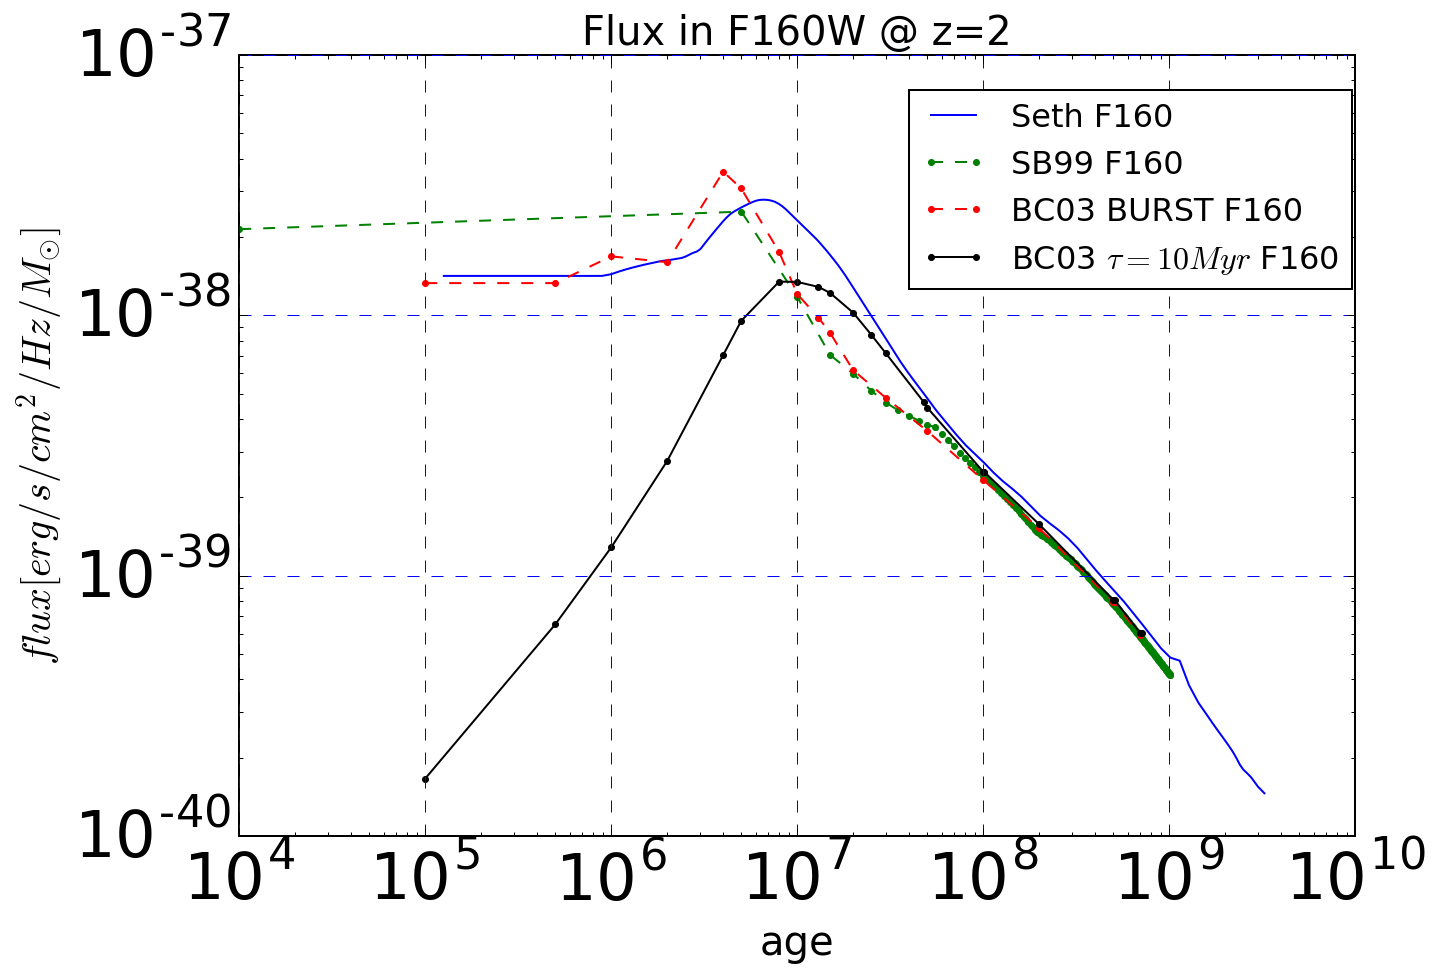

In [411]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

ax.plot(seth160z2Data['age'],seth160z2Data['filtfluxz'][0][0])
ax.plot(sbff[:,0],sbff[:,1],"g.--")
ax.plot(BC03_z2F160Fluxssp[:,0],BC03_z2F160Fluxssp[:,1],"r.--")
ax.plot(BC03_z2F160FluxSeth[:,0],BC03_z2F160FluxSeth[:,1],"k.-")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'age', size=labelsize)
ax.set_ylabel(r'$flux [erg/s/cm^2/Hz/M_{\odot}]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.set_title(r'Flux in F160W @ z=2',size=labelsize)

ax.legend(['Seth F160','SB99 F160', r'BC03 BURST F160', r'BC03 $\tau=10Myr$ F160'],
              loc=(0.6,0.70), fontsize=16 )
gc.collect()


58054

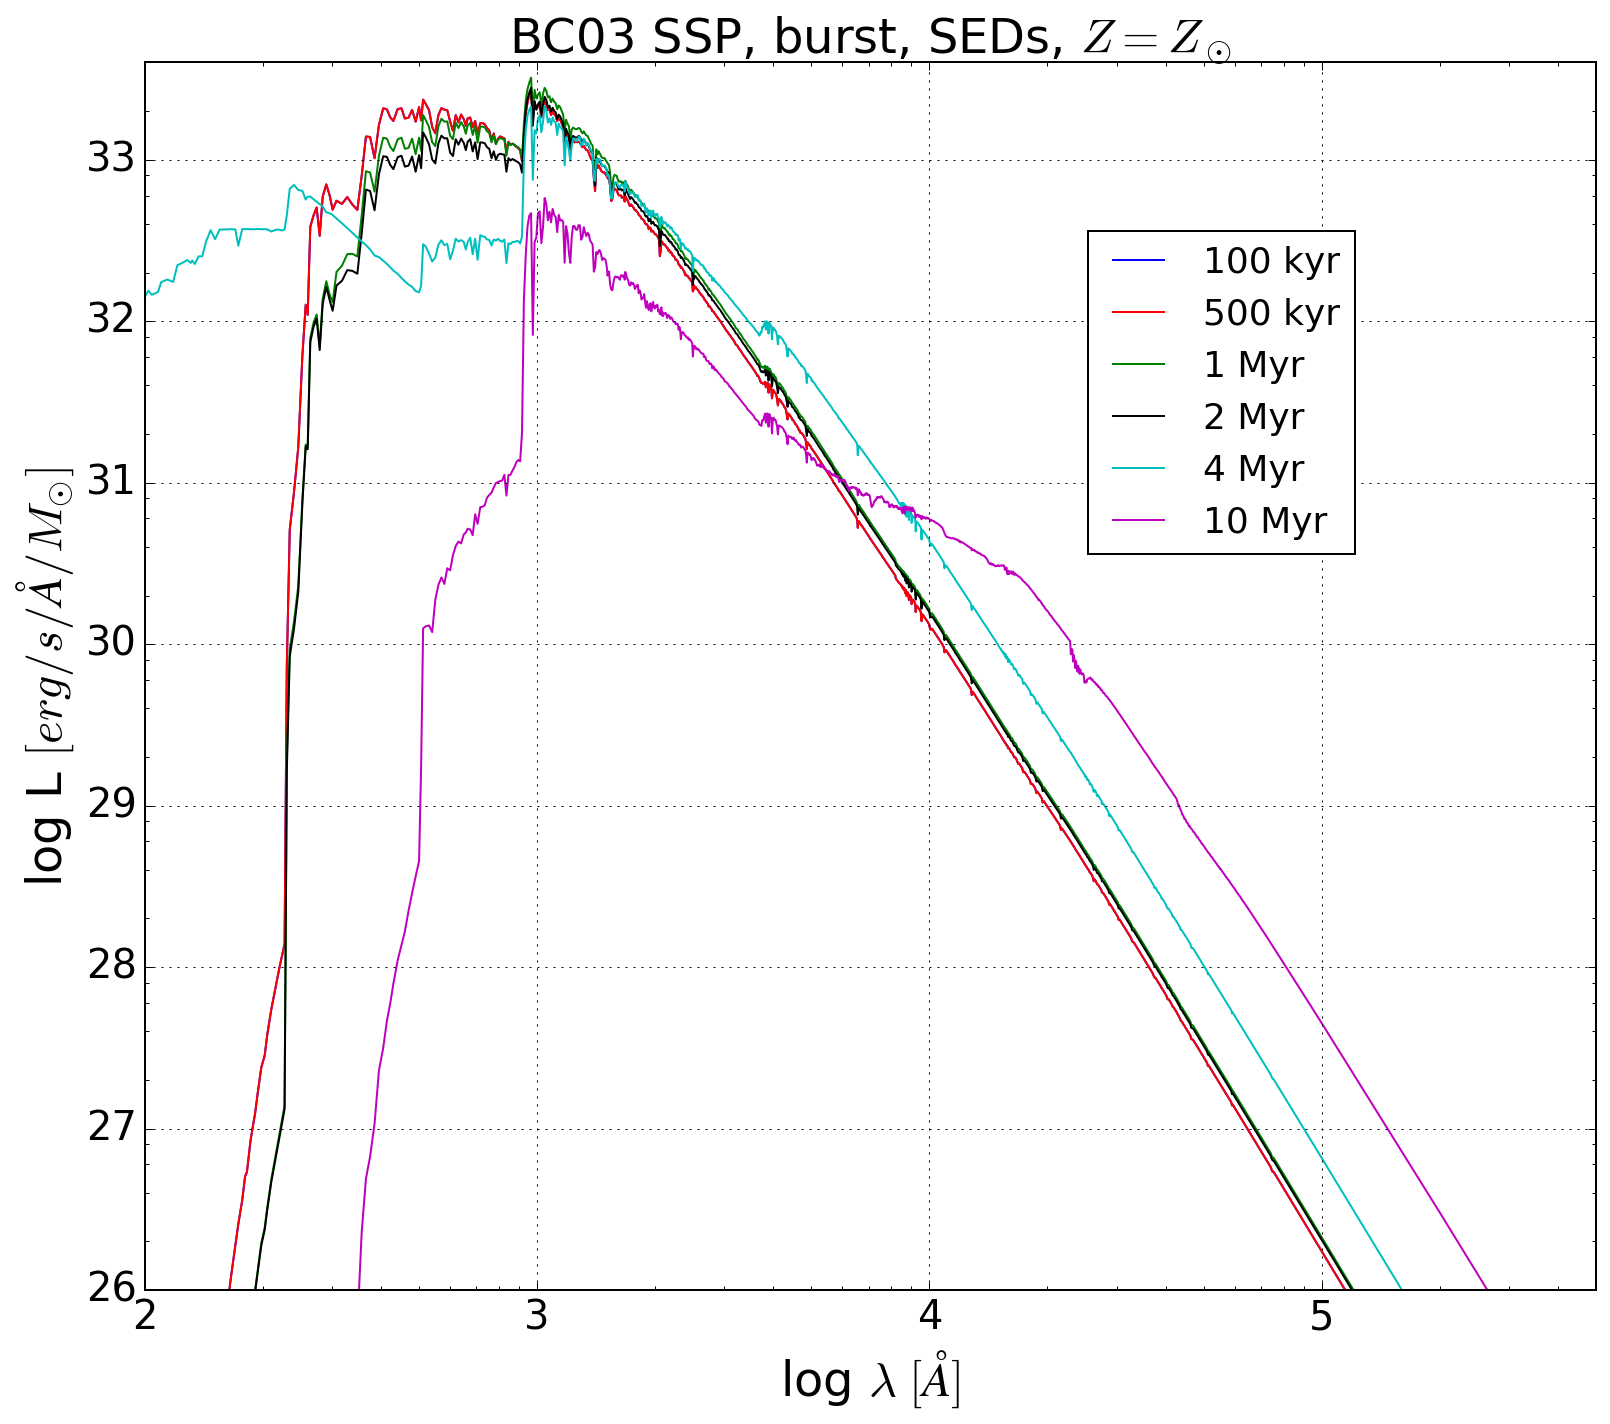

In [412]:
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(BC03ssp[0][:,0],BC03ssp[0][:,1],'b-') ##
ax.plot(BC03ssp[1][:,0],BC03ssp[1][:,1],'r-') ##
ax.plot(BC03ssp[2][:,0],BC03ssp[2][:,1],'g-') ##
ax.plot(BC03ssp[3][:,0],BC03ssp[3][:,1],'k-') ##
ax.plot(BC03ssp[4][:,0],BC03ssp[4][:,1],'c-') ##
ax.plot(BC03ssp[7][:,0],BC03ssp[7][:,1],'m-') ##

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([100,5e5])
ax.set_ylim([1e26,4e33])

ax.set_xlabel(r'log $\lambda\; [\AA]$', size=24)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(True,which="major",ls=":")

ax.legend([r'BC03 $\tau=10Myr$'],
              loc=(0.3,0.01), fontsize=18 )
ax.set_ylabel(r'log L $[erg/ s/ \AA/ M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','10 Myr'],
              loc=(0.65,0.6), fontsize=18 )

ax.set_title(r'BC03 SSP, burst, SEDs, $Z = Z_\odot$', fontsize=24)
gc.collect()

In [413]:
rsBC03ssp_100ky_wl, rsBC03ssp_100ky_LperA = lyA.rsSEDwavelen(BC03ssp[0][:,0],BC03ssp[0][:,1],2)
rsBC03ssp_500ky_wl, rsBC03ssp_500ky_LperA = lyA.rsSEDwavelen(BC03ssp[1][:,0],BC03ssp[1][:,1],2)
rsBC03ssp_1my_wl, rsBC03ssp_1my_LperA = lyA.rsSEDwavelen(BC03ssp[2][:,0],BC03ssp[2][:,1],2)
rsBC03ssp_2my_wl, rsBC03ssp_2my_LperA = lyA.rsSEDwavelen(BC03ssp[3][:,0],BC03ssp[3][:,1],2)
rsBC03ssp_4my_wl, rsBC03ssp_4my_LperA = lyA.rsSEDwavelen(BC03ssp[4][:,0],BC03ssp[4][:,1],2)
rsBC03ssp_5my_wl, rsBC03ssp_5my_LperA = lyA.rsSEDwavelen(BC03ssp[5][:,0],BC03ssp[5][:,1],2)
rsBC03ssp_10my_wl, rsBC03ssp_10my_LperA = lyA.rsSEDwavelen(BC03ssp[7][:,0],BC03ssp[7][:,1],2)


22127

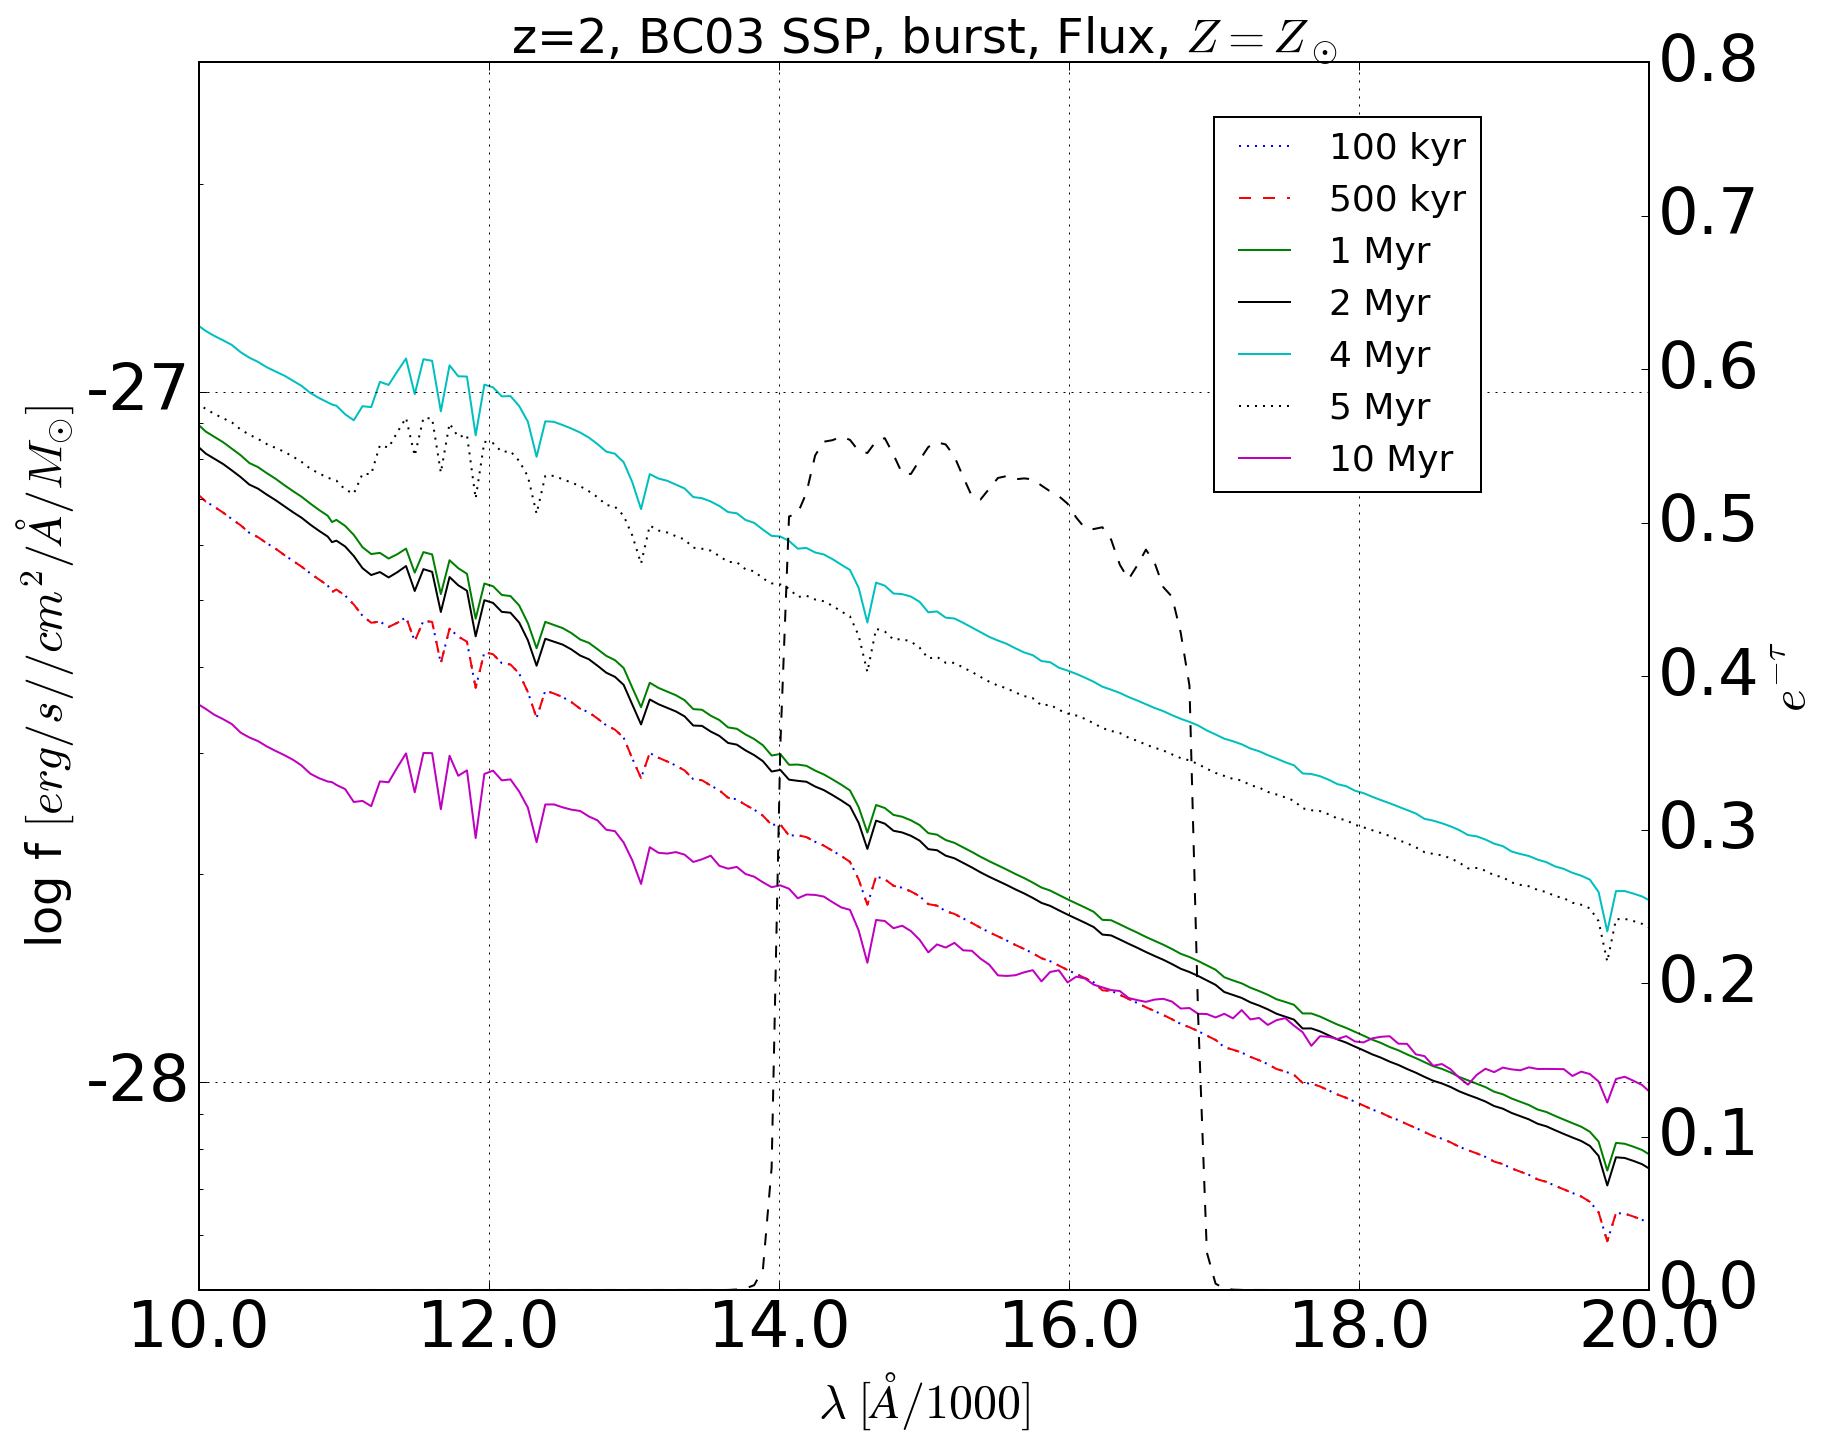

In [414]:
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03ssp_100ky_wl, rsBC03ssp_100ky_LperA,'b:')
ax.plot(rsBC03ssp_500ky_wl, rsBC03ssp_500ky_LperA,'r--')
ax.plot(rsBC03ssp_1my_wl, rsBC03ssp_1my_LperA,'g-')
ax.plot(rsBC03ssp_2my_wl, rsBC03ssp_2my_LperA,'k-')
ax.plot(rsBC03ssp_4my_wl, rsBC03ssp_4my_LperA,'c-')
ax.plot(rsBC03ssp_5my_wl, rsBC03ssp_5my_LperA,'k:')
ax.plot(rsBC03ssp_10my_wl, rsBC03ssp_10my_LperA,'m-')

ax2 = ax.twinx()
ax2.set_xlim([1e4,2e4])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot(rsBC03ssp_100MyrWaveLn,hubbleFilters['F160W_WFC3'](rsBC03ssp_100MyrWaveLn),'k--')

ax.xaxis.set_major_formatter(divfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([10000,20000])
ax.set_ylim([5e-29,3e-27])

ax.set_xlabel(r'$\lambda\; [\AA/1000]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/ \AA/ M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['100 kyr', '500 kyr','1 Myr','2 Myr','4 Myr','5 Myr','10 Myr'],
              loc=(0.7,0.65), fontsize=18 )

ax.set_title(r'z=2, BC03 SSP, burst, Flux, $Z = Z_\odot$', fontsize=24)
gc.collect()

In [433]:
rs100kyrA = (rsBC03ssp_100ky_wl * u.Angstrom)
rs100kyrLperA = rsBC03ssp_100ky_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_100kyr_hz     = (rs100kyrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_100kyr_LperHz = (rs100kyrLperA * (rs100kyrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]

rs500kyrA = (rsBC03ssp_500ky_wl * u.Angstrom)
rs500kyrLperA = rsBC03ssp_500ky_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_500kyr_hz     = (rs500kyrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_500kyr_LperHz = (rs500kyrLperA * (rs500kyrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]

rs1myrA = (rsBC03ssp_1my_wl * u.Angstrom)
rs1myrLperA = rsBC03ssp_1my_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_1myr_hz     = (rs1myrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_1myr_LperHz = (rs1myrLperA * (rs1myrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]


In [451]:
rs2myrA = (rsBC03ssp_2my_wl * u.Angstrom)
rs2myrLperA = rsBC03ssp_2my_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_2myr_hz     = (rs2myrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_2myr_LperHz = (rs2myrLperA * (rs2myrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]


In [453]:

rs4myrA = (rsBC03ssp_4my_wl * u.Angstrom)
rs4myrLperA = rsBC03ssp_4my_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_4myr_hz     = (rs4myrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_4myr_LperHz = (rs4myrLperA * (rs4myrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]


In [455]:

rs10myrA = (rsBC03ssp_10my_wl * u.Angstrom)
rs10myrLperA = rsBC03ssp_10my_LperA * u.erg/u.s/u.Angstrom 
rsBC03ssp_10myr_hz     = (rs10myrA).to(u.Hz, equivalencies=u.spectral())[::-1]
rsBC03ssp_10myr_LperHz = (rs10myrLperA * (rs10myrA**2/astropy.constants.c)).to(u.erg/u.s/u.Hz)[::-1]



In [456]:
rsBC03ssp_100kyr_hz.value, rsBC03ssp_100kyr_LperHz.value

(array([  6.24567621e+11,   7.13791567e+11,   8.32756828e+11, ...,   1.04094603e+16,
          1.06309382e+16,   1.09814087e+16]),
 array([  2.10003715e-43,   2.75881125e-43,   3.77978548e-43, ...,   4.29324984e-53,
          1.71887185e-53,   6.41648308e-54]))

14116

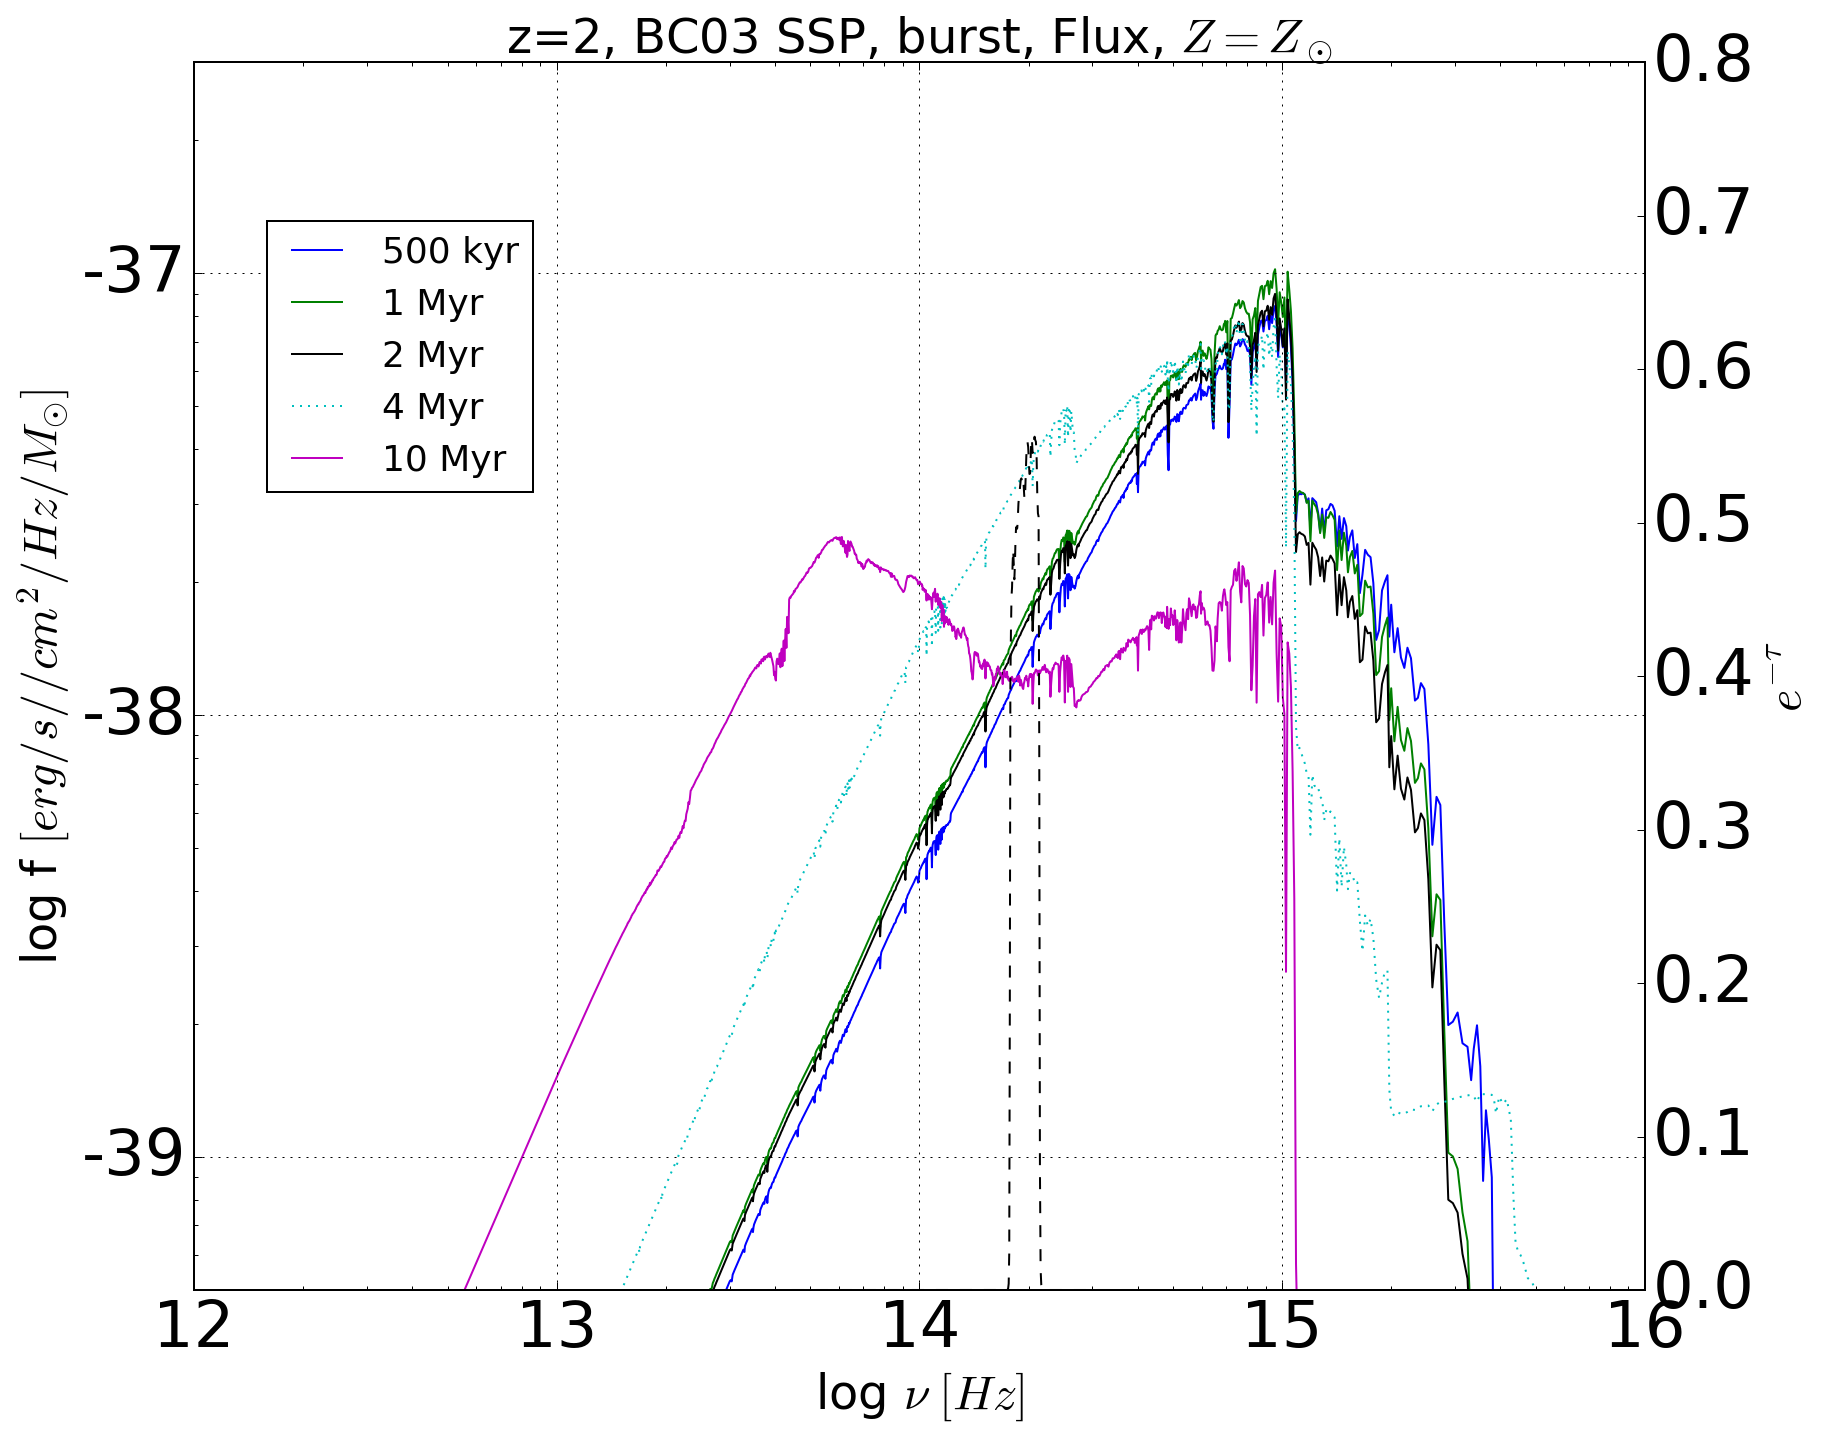

In [472]:
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(rsBC03ssp_500kyr_hz, rsBC03ssp_500kyr_LperHz,'b-')
ax.plot(rsBC03ssp_1myr_hz, rsBC03ssp_1myr_LperHz,'g-')
ax.plot(rsBC03ssp_2myr_hz, rsBC03ssp_2myr_LperHz,'k-')
ax.plot(rsBC03ssp_4myr_hz, rsBC03ssp_4myr_LperHz,'c:')
ax.plot(rsBC03ssp_10myr_hz, rsBC03ssp_10myr_LperHz,'m-')

ax2 = ax.twinx()
ax2.set_xlim([1e12,1e16])
ax2.set_ylim([0,0.8])
ax2.set_xscale('log')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot((rsBC03ssp_100MyrWaveLn * u.angstrom).to(u.Hz, equivalencies=u.spectral())[::-1],
         hubbleFilters['F160W_WFC3'](rsBC03ssp_100MyrWaveLn[::-1]),'k--')

ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e12,1e16])
ax.set_ylim([5e-40,3e-37])

ax.set_xlabel(r'log $\nu\; [Hz]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/Hz/ M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['500 kyr','1 Myr','2 Myr','4 Myr','10 Myr'],
              loc=(0.05,0.65), fontsize=18 )

ax.set_title(r'z=2, BC03 SSP, burst, Flux, $Z = Z_\odot$', fontsize=24)
gc.collect()

19567

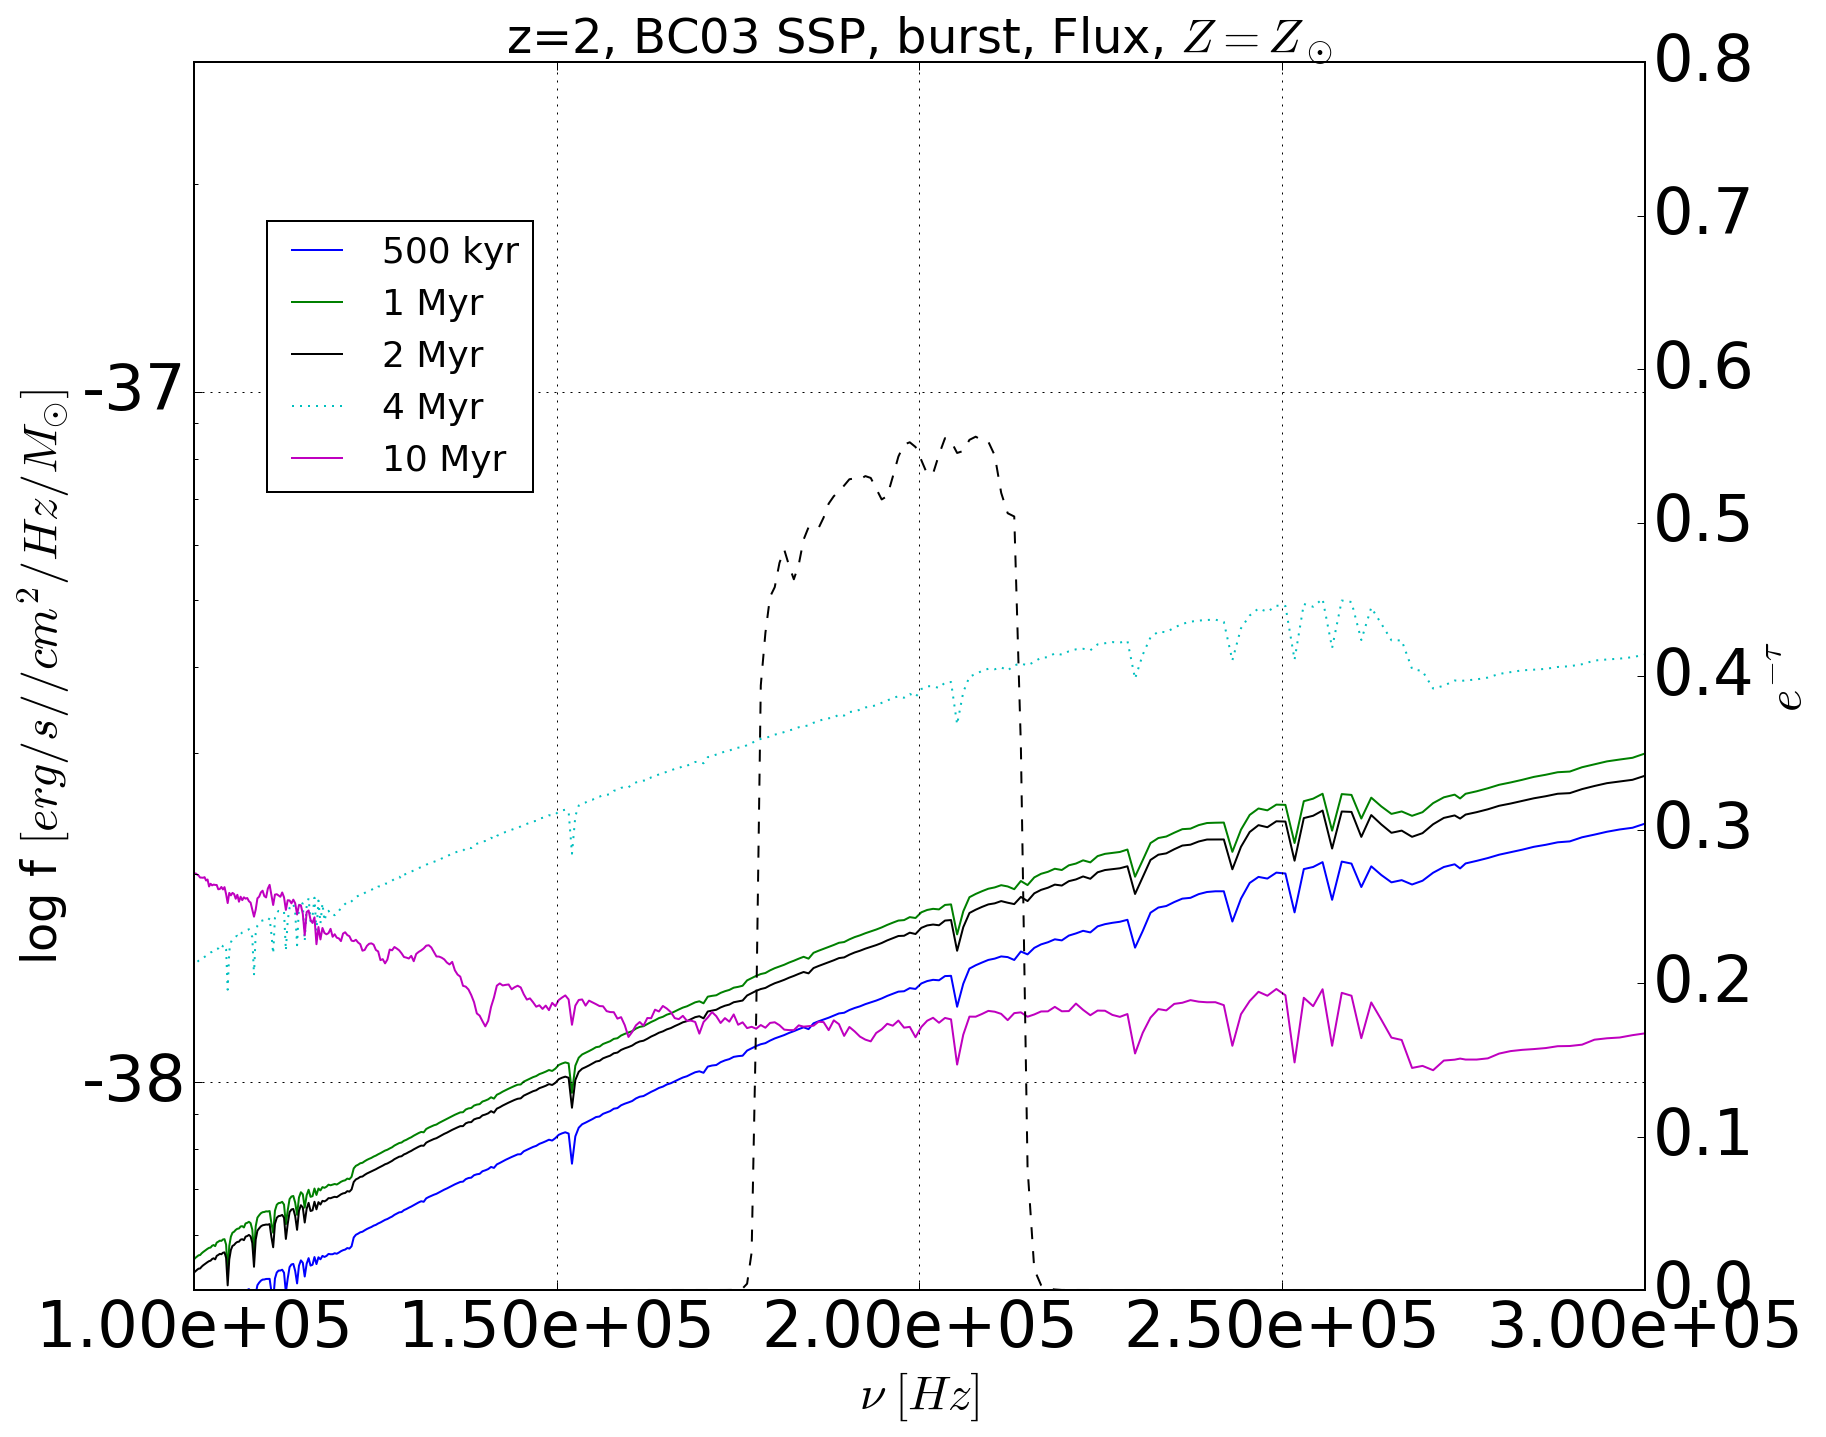

In [473]:
gc.collect()
fig.clear()
fig = plt.figure()
ax = plt.axes()

ax.set_xscale('linear')
ax.set_yscale('log')

ax.plot(rsBC03ssp_500kyr_hz, rsBC03ssp_500kyr_LperHz,'b-')
ax.plot(rsBC03ssp_1myr_hz, rsBC03ssp_1myr_LperHz,'g-')
ax.plot(rsBC03ssp_2myr_hz, rsBC03ssp_2myr_LperHz,'k-')
ax.plot(rsBC03ssp_4myr_hz, rsBC03ssp_4myr_LperHz,'c:')
ax.plot(rsBC03ssp_10myr_hz, rsBC03ssp_10myr_LperHz,'m-')

ax2 = ax.twinx()
# ax2.set_xlim([1e12,1e16])
ax2.set_ylim([0,0.8])
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel(r'$e^{-\tau}$', size=24)
ax2.plot((rsBC03ssp_100MyrWaveLn * u.angstrom).to(u.Hz, equivalencies=u.spectral())[::-1],
         hubbleFilters['F160W_WFC3'](rsBC03ssp_100MyrWaveLn[::-1]),'k--')

ax.xaxis.set_major_formatter(GHzfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.set_xlim([1e14,3e14])
ax.set_ylim([5e-39,3e-37])

ax.set_xlabel(r'$\nu\; [GHz]$', size=24)
ax.set_ylabel(r'log f $[erg/ s/ /cm^2/Hz/ M_{\odot}]$', size=24)

ax.grid(True,which="major",ls=":")

ax.legend(['500 kyr','1 Myr','2 Myr','4 Myr','10 Myr'],
              loc=(0.05,0.65), fontsize=18 )

ax.set_title(r'z=2, BC03 SSP, burst, Flux, $Z = Z_\odot$', fontsize=24)
gc.collect()